## Introduction

In my previous articles, I demonstrated how to collect financial data in an automated manner and store it in AWS S3 buckets. Additionally, we performed exploratory data analysis (EDA). Now, let's proceed with our journey to develop a stock predictions app.

In this series of blog posts, we'll develop a complete machine learning project using a variety of techniques and tools including AWS, Snowflake, Python, Snowpark, and Streamlit. The final outcome will be a web application that enables us to forecast future stock prices for Google

## Project Layout

Here are the high-level steps for this project 

1. **Data collection**: Automatically download the stock historical prices data in csv format and save it AWS S3 bucket.


2. **Data storage**: Store the data in a Snowflake data warehouse by creating data pipe between AWS and Snowflake.


3. **Data Extraction, Preprocessing & EDA**: Extract & Pre-process the data using Python and perform basic Exploratory Data Analysis.


4. **Model development**: Develop a machine learning model, Train the model on historical data, Evaluate the model and perform hyper parameter tunning 


5. **Model deployment**: Deploy the final model on Snowflake.


6. **App development**: Build a web app using Streamlit and Python to interact with the deployed model and display the predictions. And Deploy the final app on Streamlit Cloud.

## Data Extraction, Preprocessing & EDA

In this phase we connect to Snowflake from python, Extract the data and then we will perform data preprocessing & Exploratory Data Analysis. we will perform following steps.

* Set up Python environment  
* Configurations on Snowflake side 
* Connect Snowflake & Extract Data 
* Data Preprocessing  
* Exploratory Data Analysis (EDA) 

### Set up Python environment 

First we will set up the python environment

#### Prerequisites

* **Snowflake** : This is second part of 3 series articles, if you are here first time then please use this TODO link , we will use same Snowflake account from first blog. 


* **Anaconda or miniconada** : Use following URL to download & install Anaconda & miniconda (Any one from below)

    * Anaconda: https://www.anaconda.com/products/distribution

    * Miniconda: https://docs.conda.io/en/latest/miniconda.html


#### Create Python environment

Lets create Python environment for our project.

* **Open Anaconda / Miniconda terminal** : This step can deffer based on your operating system.

You can directly open from command prompt (as shown below)
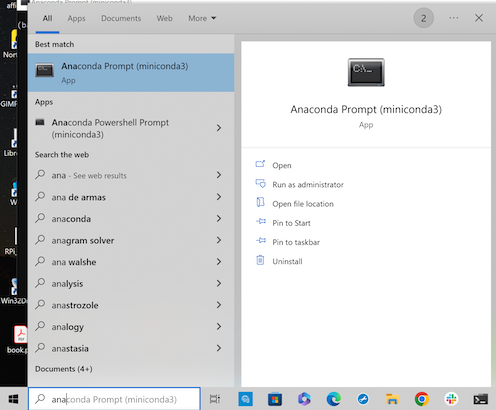


Or you can Open Anaconda Navigator -> Environments -> Select Base Environment -> Open Terminal (as shown below)
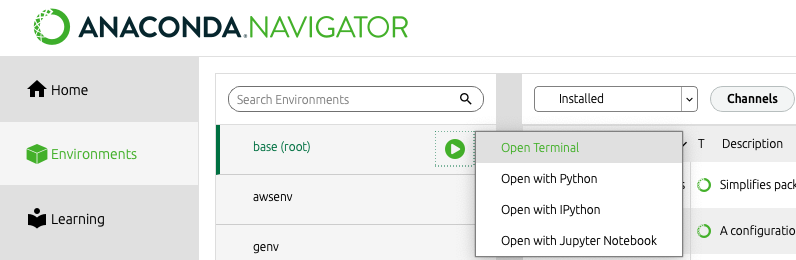



#### **Create Python env :**
Type following command one by one in the Terminal, Type Y if prompted  

**For Windows OS**<br>

`conda deactivate`<br> 
`conda create --name stocksenv --override-channels -c https://repo.anaconda.com/pkgs/snowflake python=3.8 numpy pandas`<br>
`conda activate stocksenv`


**For MAC OS**<br>

`conda deactivate`<br> 
`CONDA_SUBDIR=osx-64 conda create -n stocksenv python=3.8 numpy pandas --override-channels -c https://repo.anaconda.com/pkgs/snowflake`<br>
`conda activate stocksenv`<br>
`conda config --env --set subdir osx-64`

#### **Install Required Python Packages :** 
Type following command one by one in the Terminal, Type Y if prompted  

`python -m pip install pip==23.0.1`<br> 
`conda install snowflake-snowpark-python==0.10.0`<br>
`pip install scikit-learn==1.1.1`<br>
`pip install plotly`<br>
`pip install matplotlib`<br>
`pip install prophet`<br>
`pip install seaborn`<br>
`pip install jupyter`<br>
`python -m ipykernel install --user --name snowpack --display-name "stocksenv_3.8"`<br>
`pip install streamlit`<br>
`pip install pyarrow==8.0.0`<br>
`pip install pmdarima`<br>

We are done with python environment setup.

###  Configurations on Snowflake side

Before we start we need to configure few more things at Snowflake side.

#### Acknowledgment to use Third-Party Packages 
* Login to to snowflake web console using https://app.snowflake.com/

* From Left Panel Click the dropdown menu next to your login name, then click Switch Role -> ORGADMIN.

* After that on Left Panel Click Admin -> Billing & Terms

* Scroll to the Anaconda section and click the Enable button. The Anaconda Packages (Preview Feature) dialog opens.

* Click the link to review the Snowflake Third Party Terms.

* If you agree to the terms, click the Acknowledge & Continue button.


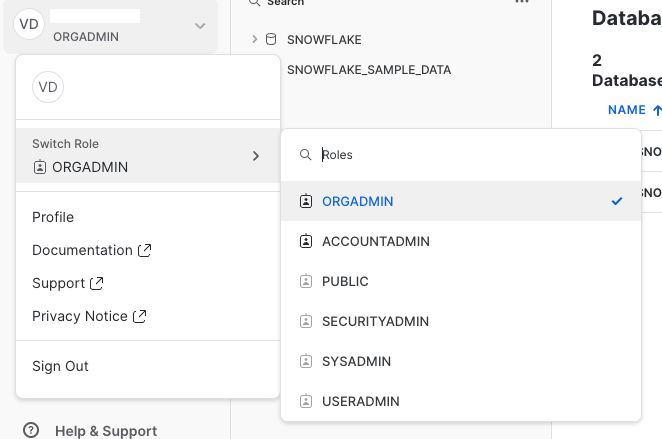


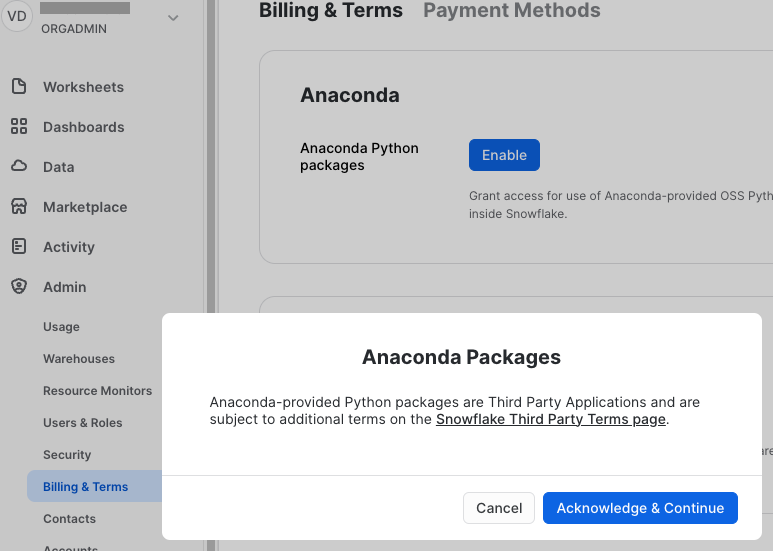






#### Identify Snowflake Account Name 

We need to find the Snowflake Account Name , this will be used to connect the snowflake from Python (Jupyter Notebook) 

* On the Left Panel bottom side you will see Snowflake icon , Some text and a **Down Arrow** icon 
* Click the Down Arrow -> This will pop-up one more window -> Then **Hover over** on that window -> This will open second window 
* On the top right side of second window , there should be **copy account identifier** icon -> Upon clicking that icon the account identifier will get copied in the clipboard.
* Paste the account identifier in the notepad, Please note that account  identifier would be in format of `<OrganizationName>.<AccountName>`.
* Replace Dot (.) with Hyphen (-) so that account identifier would be like `<OrganizationName>-<AccountName>`. Save this for future use.
    




you can refer [this](https://docs.snowflake.com/en/user-guide/admin-account-identifier) link to read more on this 


### Connect Snowflake & Extract Data 

In this section we will use Jupyter notebook to run the python code, and we will also connect to Snowflake and extract pricing data into Python.

Create a Project Folder in suitable location, we will save all configuration files, code in this project directory.

#### Create secrets.toml file 

Generally in any project we do not hard-code the values in the code, instead we create file (called as conf, ini, toml etc) and save parameters, credentials in that file and access that file in the code, in this project we will use  .toml file. 

Create "secrets.toml" file (.toml is extension) paste below content in that file, and save the file the project directory.

`[SNOWFLAKE]`<br>
`account="Type account identifier saved earlier<OrgaName>-<ActName>"`<br>
`user="Type Snowflake User"`<br>
`password="Type Snowflake Password"`<br>
`role="ACCOUNTADMIN"`<br>
`database="PRICE_PRED_DB"`<br>
`schema="PRICE_PRED_SCHEMA"`<br>
`warehouse="PRICE_PRED"`

**IMPORTANT NOTE : Do not share or upload this file or any user credentials** 





#### **Jupyter Notebook**

* Open Anaconda / Miniconda Terminal (as shown earlier)
* Type following commands<br> 
    `conda deactivate`<br>
    `conda activate stocksenv`<br>
* Navigate to Project directory using `cd` command
* Type command `jupyter notebook` on the terminal , This will open Jupyter Notebook on web browser.

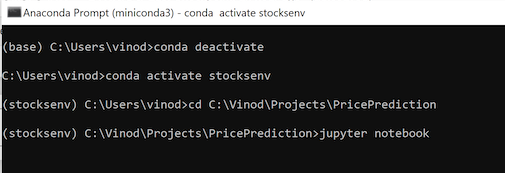

You should always used above steps open Jupyter notebook for this project. 

* Click the **New** button on top right side, then Select **stocksenv_3.8** this will create a new Jupyter Notebook using our Python environment. 



You can rename this notebook with suitable name. Lets begin the Python coding 

To perform expressive, and extensible interface with Snowflake, we are using **Snowpark Python**. Snowpark provides a native Python experience with a pandas for data extraction & manipulation


**Import required packages**

In [1]:
## Data Connect / process
from snowflake.snowpark.session import Session
import toml
import numpy as np
import pandas as pd
import sys

## Machine Learning
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima.arima import ARIMA
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.diagnostics import cross_validation, performance_metrics
import itertools

In [2]:
##Data viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode()
%matplotlib inline

## Default settings
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

**Load the credentials from toml file & Connect to Snowflake** 

In [3]:
secrets = toml.load("secrets.toml")

accountname = secrets["SNOWFLAKE"]["account"]
user = secrets["SNOWFLAKE"]["user"]
password = secrets["SNOWFLAKE"]["password"]
role = secrets["SNOWFLAKE"]["role"]
database = secrets["SNOWFLAKE"]["database"]
schema = secrets["SNOWFLAKE"]["schema"]
warehouse = secrets["SNOWFLAKE"]["warehouse"]

connection_parameters = {
    "account": accountname,
    "user": user,
    "password": password,
    "role": role,
    "database": database,
    "schema": schema,
    "warehouse": warehouse,
    "ocsp_fail_open":"False"
}

session = Session.builder.configs(connection_parameters).create()

**Test Connection**

Using **session** object you can run queries on snowflake or retrieve table data, Let's check if connection is working properly   

In [4]:
print(session.sql('select current_warehouse(), current_database(), current_schema()').collect())

[Row(CURRENT_WAREHOUSE()='PRICE_PRED', CURRENT_DATABASE()='PRICE_PRED_DB', CURRENT_SCHEMA()='PRICE_PRED_SCHEMA')]


warehouse, database & schema name is displayed in output, which means connection is successful 

**Getting data from snowflake into a Snowpark DataFrame**

Using session.table(<TABLE_NAME>) returns Snowpark DataFrame, it is similar to pandas DataFrame . it dose not holds the data it just points to table in snowflake. We can perform tons of operations like pandas DataFrame. Please refere [this](https://docs.snowflake.com/en/developer-guide/snowpark/python/working-with-dataframes) documentation link. 

Lets pull data from table **historical_prices**

In [5]:
price_sdf = session.table('historical_prices')
print(type(price_sdf))

<class 'snowflake.snowpark.table.Table'>


We can convert the Snowpark DataFrame to Pandas DataFrame 

In [6]:
price_df = price_sdf.to_pandas()
print(type(price_df))

<class 'pandas.core.frame.DataFrame'>


In [7]:
# Compare size
print('Size in MB of Snowpark DataFrame in Memory:', np.round(sys.getsizeof(price_sdf) / (1024.0**2), 2))
print('Size in MB of Pandas DataFrame in Memory:', np.round(sys.getsizeof(price_df) / (1024.0**2), 2))

Size in MB of Snowpark DataFrame in Memory: 0.0
Size in MB of Pandas DataFrame in Memory: 0.65


**View Pricing data** 

In [8]:
price_df

HIGH        LOW       OPEN      CLOSE    VOLUME   ADJCLOSE  \
0     96.300003  94.300003  94.360001  95.580002  28288200  95.580002   
1     96.089996  93.844002  95.419998  94.169998  24101500  94.169998   
2     96.239998  94.404999  94.404999  94.650002  25395200  94.650002   
3     95.919998  92.355003  94.489998  92.660004  24438900  92.660004   
4     92.480003  89.769997  89.860001  92.309998  23328600  92.309998   
...         ...        ...        ...        ...       ...        ...   
4681  96.089996  93.844002  95.419998  94.169998  24101500  94.169998   
4682  96.239998  94.404999  94.404999  94.650002  25395200  94.650002   
4683  94.110001  92.660004  92.739998  94.019997  30220900  94.019997   
4684  96.300003  94.300003  94.360001  95.580002  28288200  95.580002   
4685  96.089996  93.844002  95.419998  94.169998  24101500  94.169998   

            DATE TICKER  
0     2023-03-06   GOOG  
1     2023-03-07   GOOG  
2     2023-03-08   GOOG  
3     2023-03-09   GOOG  
4     2023-03-02   GOOG  
...          ...    ...  
4681  2023-03-07   GOOG  
4682  2023-03-08   GOOG  
4683  2023-03-03   GOOG  
4684  2023-03-06   GOOG  
4685  2023-03-07   GOOG  

[4686 rows x 8 columns]

### Data Preprocessing

After data extraction, we will check some basic information & statistics of the dataset. and perform the data preprocessing which involved handling null & duplicate data, take care of outliers, convert categorical data etc.

#### Basic information of the dataset

Here we will check some basic information like rows , columns nulls etc.

**View Number of rows & Columns** 

In [9]:
price_df.shape

(4686, 8)

**Check the for the Null Values**

In [10]:
price_df.isna().sum()

HIGH        0
LOW         0
OPEN        0
CLOSE       0
VOLUME      0
ADJCLOSE    0
DATE        0
TICKER      0
dtype: int64

No Null values found. One less thing to worry about, otherwise we would need to address the null. there are different techniques to handle nulls.  

**Check for duplicate data** 

In [11]:
price_df.duplicated().sum()

14

There are Duplicate rows in the dataset, We should get rid of Duplicate data as it may impact the model prediction. We can use **drop_duplicates** to remove duplicates.

In [12]:
price_df.drop_duplicates(subset='DATE', keep="last",inplace=True)
price_df.duplicated().sum()
price_df.shape

(4671, 8)

**Sort the DataFrame**

Looks like data is not sorted , lets sort the data based on **DATE**

In [13]:
price_df = price_df.sort_values(by='DATE',ignore_index=True)

#### Basic Stats of the dataset

checking stastical information about the dataset 

**df.info()**

We will use **df.info()** Method,its prints information about a DataFrame including the index dtype and columns, non-null values and memory usage.

In [14]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4671 entries, 0 to 4670
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   HIGH      4671 non-null   float64
 1   LOW       4671 non-null   float64
 2   OPEN      4671 non-null   float64
 3   CLOSE     4671 non-null   float64
 4   VOLUME    4671 non-null   int32  
 5   ADJCLOSE  4671 non-null   float64
 6   DATE      4671 non-null   object 
 7   TICKER    4671 non-null   object 
dtypes: float64(5), int32(1), object(2)
memory usage: 273.8+ KB


By Looking at the data and info() output, We can see there is no Categorical data present in the dataset. In general we need to encode the categorical data into columns using multiple techniques, but in this case we don't have such data.

**Format DATE Column**

Data type for ‘Date’ is an object. So we will change the data type to datetime format, This will be useful in EDA & features Extraction

In [15]:
price_df['DATE'] = pd.to_datetime(price_df['DATE'])

**Create New Features**

Adding New Features (YEAR, MONTH, DAY &  MONTHYEAR) derived from the Date, we will utilize this during Visualization 

In [16]:
price_df['YEAR'] = price_df['DATE'].dt.year
price_df['MONTH'] = price_df['DATE'].dt.month
price_df['DAY'] = price_df['DATE'].dt.day
price_df['MONTHYEAR'] = price_df['DATE'].dt.strftime('%Y%m').astype(int)

Let's check the revised data 

In [17]:
price_df.head()

HIGH       LOW      OPEN     CLOSE     VOLUME  ADJCLOSE       DATE  \
0  2.591785  2.390042  2.490664  2.499133  897427216  2.499133 2004-08-19   
1  2.716817  2.503118  2.515820  2.697639  458857488  2.697639 2004-08-20   
2  2.826406  2.716070  2.758411  2.724787  366857939  2.724787 2004-08-23   
3  2.779581  2.579581  2.770615  2.611960  306396159  2.611960 2004-08-24   
4  2.689918  2.587302  2.614201  2.640104  184645512  2.640104 2004-08-25   

  TICKER  YEAR  MONTH  DAY  MONTHYEAR  
0   GOOG  2004      8   19     200408  
1   GOOG  2004      8   20     200408  
2   GOOG  2004      8   23     200408  
3   GOOG  2004      8   24     200408  
4   GOOG  2004      8   25     200408

**df.describe()**

Lets try to find out more stats using pd.describe() method, This method is used for calculating some statistical data like percentile, mean and std of the numerical values of the Series or DataFrame.

In [18]:
price_df.describe()

HIGH          LOW         OPEN        CLOSE        VOLUME  \
count  4671.000000  4671.000000  4671.000000  4671.000000  4.671000e+03   
mean     38.580784    37.790060    38.183043    38.191447  1.227096e+08   
std      35.904489    35.126934    35.505808    35.517772  1.530120e+08   
min       2.534002     2.390042     2.470490     2.490913  1.584340e+05   
25%      12.760047    12.482338    12.652451    12.626050  2.967700e+07   
50%      25.738087    25.231527    25.505474    25.480045  6.707164e+07   
75%      55.095999    53.782249    54.410252    54.445749  1.530616e+08   
max     152.100006   149.887497   151.863495   150.709000  1.650833e+09   

          ADJCLOSE         YEAR        MONTH          DAY      MONTHYEAR  
count  4671.000000  4671.000000  4671.000000  4671.000000    4671.000000  
mean     38.191447  2013.402697     6.574395    15.726611  201346.844145  
std      35.517772     5.367631     3.453636     8.759722     536.558004  
min       2.490913  2004.000000     1.000000     1.000000  200408.000000  
25%      12.626050  2009.000000     4.000000     8.000000  200904.000000  
50%      25.480045  2013.000000     7.000000    16.000000  201311.000000  
75%      54.445749  2018.000000    10.000000    23.000000  201807.000000  
max     150.709000  2023.000000    12.000000    31.000000  202303.000000

By Observing statistical info we can notice that data is pretty much consistent, Also I do not see any Outliers.

Data is in good shape. Lets Move ahead to Exploratory Data Analysis.

### Exploratory Data Analysis (EDA)

In this step will perform Exploratory Data Analysis by data visualization to get some insides from data so we can use it in future model building phase.

**Closing price Trend**

I am using plotly to create Closing price trend, it is very powerful tool to generate interactive visualizations   

In [19]:
trace = go.Scatter(x=price_df['DATE'], 
                   y=price_df['CLOSE'],
                   line_color='deepskyblue', 
                   name = 'Actual Prices')

data = [trace]
layout = dict(
    title='Daily Closing Price Google',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                    label='1m',
                    step='month',
                    stepmode='backward'),
                dict(count=3,
                    label='3m',
                    step='month',
                    stepmode='backward'),
                dict(count=6,
                    label='6m',
                    step='month',
                    stepmode='backward'),
                dict(count=12,
                    label='1Y',
                    step='month',
                    stepmode='backward'),
                dict(count=5,
                    label='5Y',
                    step='year',
                    stepmode='backward'),
                dict(step="all")
            ])
        ),
        title='Date',
        rangeslider=dict(
            visible = True
        ), type='date'
    ),
    yaxis=dict(title='Closing Price')
)
fig = dict(data=data, layout=layout)
py.iplot(fig);

Prices are climbing up till Year 2021.

**BAR Plots**

Lets plot the average Closing Price based on Day, Month & Year 

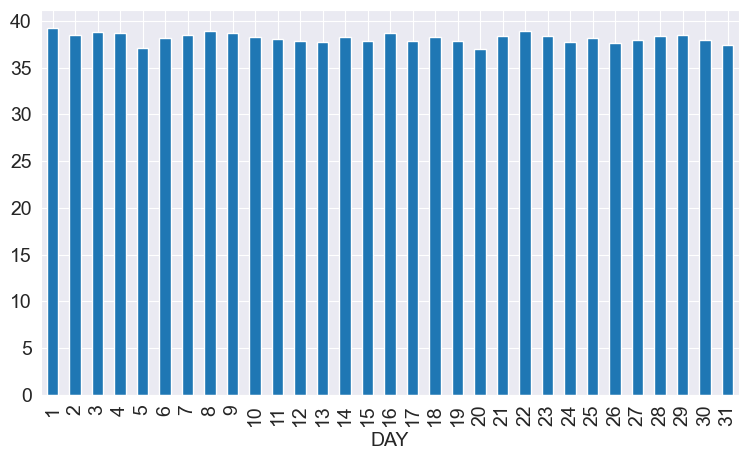

In [20]:
price_df.groupby(['DAY'])['CLOSE'].mean().plot.bar();

In [21]:
price_df.groupby(['MONTH'])['CLOSE'].mean().plot.bar();

In [22]:
price_df.groupby(['YEAR'])['CLOSE'].mean().plot.bar();

We cannot identify any pattern using DAY & MONTH, But there is definitive trend on Average Closing Price based on Year. Price has increased till 2021, after 2021 prices are falling.

**Correlation**

Lets try to find out if there is any correlation between any features (Columns)

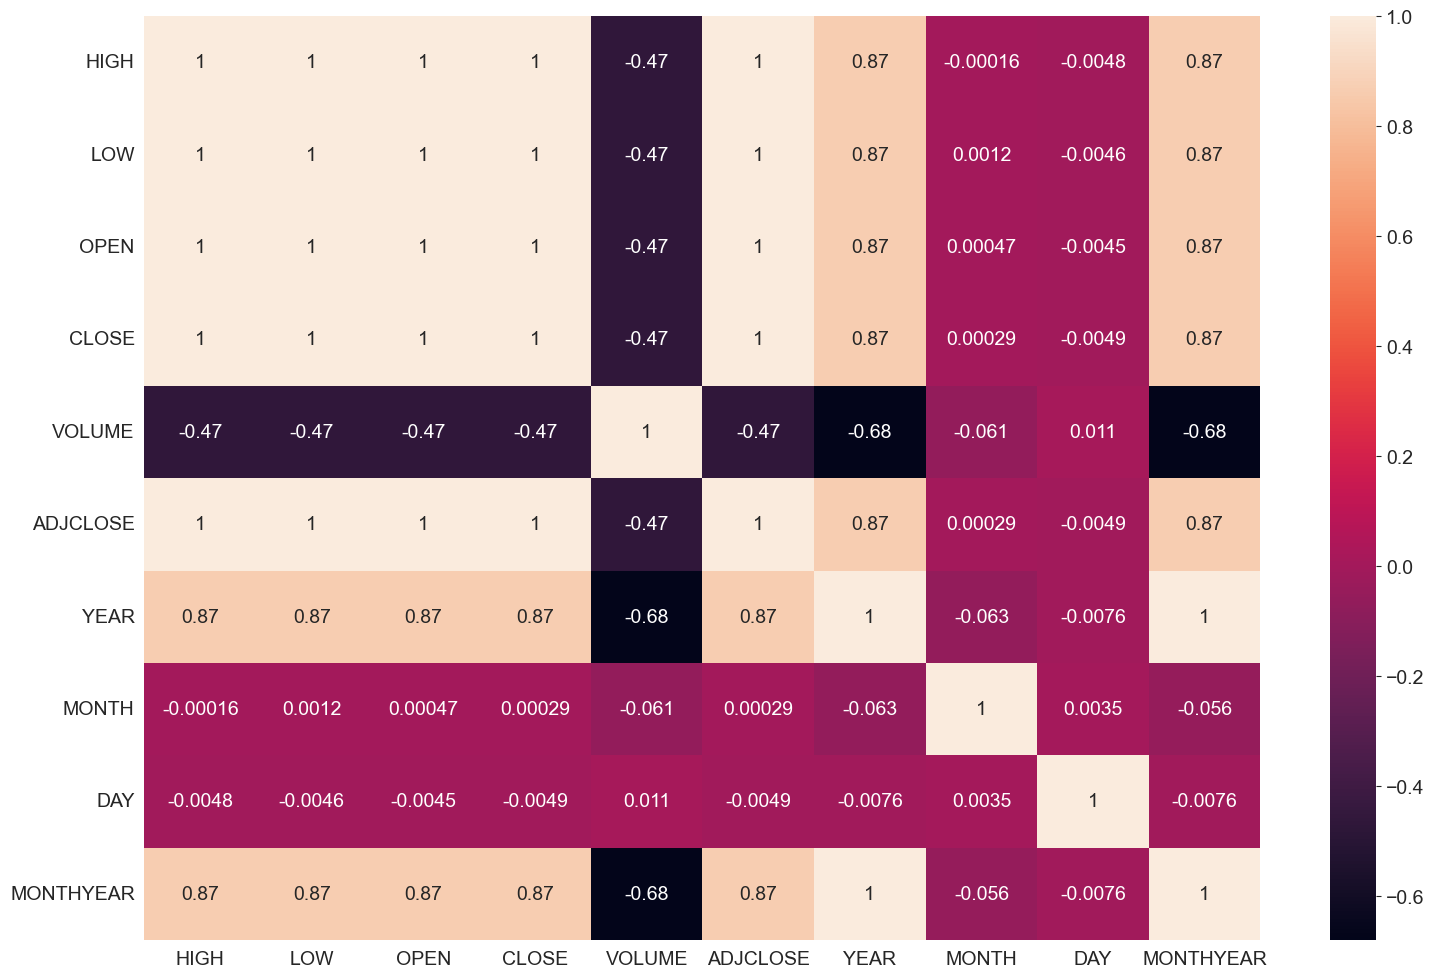

In [23]:
corr = price_df.corr()
plt.figure(figsize=(18,12))
sns.heatmap(corr,annot=True);

Again I see some correlation between Year, Month Year & Closing Price.As its a Time Series dataset that justifies the correlation & trend. 

We will use **Date** & **Closing Price** as features for the price prediction model.

I think its enough visualization for the project. I have also performed in depth Exploratory Data Analysis of market data, you can checkout [this](https://medium.com/jovianml/has-gold-been-a-good-investment-over-stock-market-e909086a859e) article.

## Model development

During this phase, we will utilize various machine learning models to forecast stock prices for future dates. For each model, we will carry out the following steps:

* Determine the appropriate model
* Split the data into a Training Set and Testing Set
* Build and train the model
* Predict outcomes & Visualize the data 
* Evaluate model's performance

Afterwards, we will choose the most promising model and conduct hyperparameter tuning to attain optimal results.


### Linear Regression Model

Lets start with a **Baseline model**, a Baseline model is a simple model that serves as a point of reference for comparing the performance of more complex models. The performance of other models is measured against the baseline model to determine if the more complex models are actually providing any improvement over the simple model

We will use a simple Linear Regression model as Baseline (Note that Linear Regression is not commonly used in time series analysis). 

**Whats is Linear Regression**

Linear regression is a statistical approach used to identify the linear relationship between a dependent variable and one or more independent variables. It is commonly used for prediction and forecasting purposes. Linear regression works by calculating the best-fit line through the data, which can be used to make predictions about the dependent variable based on the values of the independent variables.

#### Preparing Data for Linear Regression 

Here I am using only one feature (column) **Closing Price**, Idea is to to predict the prices against number of the day. So I have create new column **index** which is representing the row number (or day number) of the dataset. 

We will use day number as input and try to predict output as Closing price.

In [24]:
data = price_df[["CLOSE"]]
data.reset_index(inplace=True)
data.head()

index     CLOSE
0      0  2.499133
1      1  2.697639
2      2  2.724787
3      3  2.611960
4      4  2.640104

In a typical machine learning model, **X** refers to the input features or independent variables, and **y** refers to the output or dependent variable that we are trying to predict. In summary, X represents the input data and y represents the output data we are trying to predict.

In [25]:
X = np.array(data[['index']])
y = np.array(data['CLOSE'])

#### Split the data into a Training Set and Testing Set

Generally we segment the data in in to **Training Set** & **Testing Set**. A Training set is a subset of a dataset that is used to train a machine learning model. It is the data on which the model learns patterns and relationships between the input variables and the output variable. A Testing set, on the other hand, is a subset of the data that is held back and used to evaluate the performance of the model on new, unseen data.

Train - Test split should be done randomly but since its time series dataset, we will use first 80 % of the data as Training set and remain as Test set.  

In [26]:
train_len = int(len(X)* 0.8)
X_train, X_test = X[:train_len], X[train_len:]
y_train, y_test = y[:train_len], y[train_len:]

#### Build and train the model

Lets create linear regression model and train the model using Testing set 

In [27]:
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)

LinearRegression()

#### Predict outcomes & Visualize the data 

Here we will predict the outcomes using **predict** method, then Visualize the predictions against actual data. 

In [28]:
y_pred = linear_model.predict(X_test)

Creating a function **plot_prediction** for plotting data, since we will plot this for multiple models 

In [29]:
def plot_prediction(actual, prediction, title, y_label='Closing Price', x_label='Trading Days'):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values

    plt.plot(actual, '#00FF00', label='Actual Price')
    plt.plot(prediction, '#0000FF', label='Predicted Price')

    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')

    plt.show()  

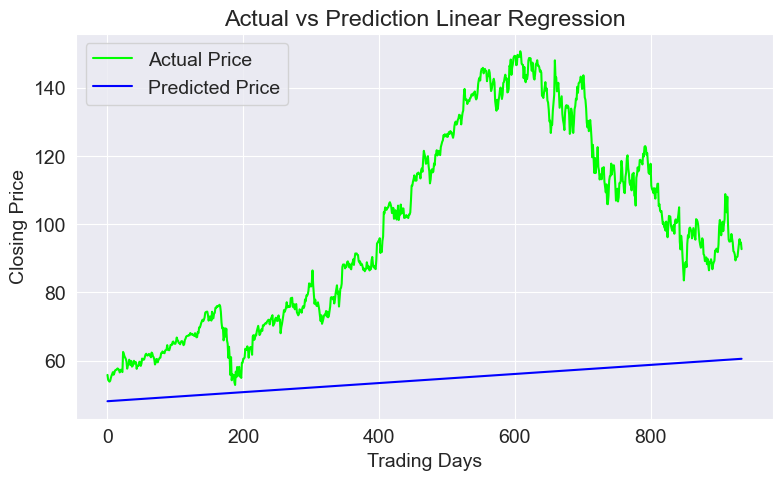

In [30]:
plot_prediction(y_test,y_pred,'Actual vs Prediction Linear Regression')

Predicted Data is more off than the Actual values, Since its is baseline model this is Expected result.

#### Evaluate Liner Regression model performance

Model evaluation is the process of assessing the performance of a trained machine learning model using various metrics to determine its accuracy, precision and other measures of prediction quality. The evaluation results help to determine if the model is suitable for its intended use or if it requires further improvement.

Following three metrics are used widely of evaluating the time series forecasting models, we will use the same.

* RMSE (Root Mean Square Error)
* MAE (Mean Absolute Error)
* MAPE (Mean Absolute Percentage Error)

To study more on evaluation matrices you can refer [this](https://towardsdatascience.com/forecast-kpi-rmse-mae-mape-bias-cdc5703d242d) article. 

I am creating a function **evaluate_model**

In [31]:
def evaluate_model(y_true, y_pred):
    print(f"Root Mean squared error: {mean_squared_error(y_true , y_pred,  squared=False)}")
    print(f"Mean absolute error: {mean_absolute_error(y_true , y_pred)}")
    print(f"Mean absolute percentage error: {mean_absolute_percentage_error(y_true , y_pred)}")    

In [32]:
evaluate_model(y_test,y_pred)

Root Mean squared error: 51.14367140707529
Mean absolute error: 43.9546464827016
Mean absolute percentage error: 0.4057506581072211


Lets try Different models 

### ARIMA (AutoRegressive Integrated Moving Average) model

ARIMA is a time series forecasting model used to make predictions based on past data. It models the time series as a combination of autoregressive (AR) and moving average (MA) components, and incorporates differencing to remove non-stationarity. ARIMA is commonly used for univariate time series analysis, where a single variable is observed over time. 

The model is specified by three parameters: 

* p : order of autoregressive component
* d : order of differencing 
* q : order of moving average component


#### Split the data into a Training Set and Testing Set

In [33]:
train_len = int(price_df.shape[0] * 0.8)
train_data, test_data = price_df[:train_len], price_df[train_len:]

y_train = train_data['CLOSE'].values
y_test = test_data['CLOSE'].values

#### Build and train the model

In [34]:
parima_model = ARIMA(order=(1,1,1))
parima_model.fit(y_train)

ARIMA(order=(1, 1, 1))

#### Predict outcomes & Visualize the data

In [35]:
y_parima_pred = parima_model.predict(len(y_test))

In [36]:
plot_prediction(y_test, y_parima_pred,'Actual vs Prediction ARIMA')

#### Evaluate ARIMA model performance

In [37]:
evaluate_model(y_test, y_parima_pred)

Root Mean squared error: 43.92862053324947
Mean absolute error: 35.55651723057638
Mean absolute percentage error: 0.3140326054814006


ARIMA model Evaluation figures looks better that Linear Regression, Let's move ahead with one more interesting model.

### Prophet Model 

Prophet is a time series forecasting model developed by Facebook's Core Data Science team. It is a statistical model that uses an additive approach to capture various components of a time series, including trend, seasonality, holidays, and other effects. Prophet also employs Bayesian modeling techniques to estimate the model parameters and uncertainty, which helps to provide more accurate predictions and forecast intervals.

#### Preparing Data for Prophet Model

The input to Prophet is always a DataFrame with two columns **ds** and **y**. The ds (datestamp) column and the y column must be numeric, and represents the measurement we wish to forecast.


In [38]:
data = price_df[["DATE","CLOSE"]] 
data.columns = ("ds","y") #renaming the columns of the dataset
data.head(5)

ds         y
0 2004-08-19  2.499133
1 2004-08-20  2.697639
2 2004-08-23  2.724787
3 2004-08-24  2.611960
4 2004-08-25  2.640104

#### Split the data into a Training Set and Testing Set

In [39]:
train_len = int(data.shape[0] * 0.8)
train_data, test_data = data[:train_len], data[train_len:]

#### Build and train the model

In [40]:
prophet_model = Prophet() 
prophet_model.fit(train_data)

18:48:09 - cmdstanpy - INFO - Chain [1] start processing
18:48:10 - cmdstanpy - INFO - Chain [1] done processing


#### Predict outcomes & Visualize the data

The predict method will return a DataFrame representing future dates and predictions. The column **yhat** is the predicted value , also there other components like uncertainty intervals, trends etc.

In [41]:
future = test_data[['ds']]
#future = prophet_model.make_future_dataframe(periods=4,include_history=True) #we need to specify the number of days in future
prophed_pred_df = prophet_model.predict(future)
prophed_pred_df.tail()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
930 2023-03-03  90.543648   67.123733  113.428011    67.607160   113.384284   
931 2023-03-06  90.608365   67.305175  113.919067    67.627601   113.494551   
932 2023-03-07  90.629937   67.547460  114.798488    67.604897   113.561674   
933 2023-03-08  90.651510   67.158858  114.934209    67.582193   113.631449   
934 2023-03-09  90.673082   68.100749  114.263898    67.559490   113.701895   

     additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
930        0.108929              0.108929              0.108929  0.050319   
931        0.109462              0.109462              0.109462  0.032764   
932        0.147583              0.147583              0.147583  0.068774   
933        0.154704              0.154704              0.154704  0.075897   
934        0.144566              0.144566              0.144566  0.067926   

     weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
930      0.050319      0.050319  0.058610      0.058610      0.058610   
931      0.032764      0.032764  0.076699      0.076699      0.076699   
932      0.068774      0.068774  0.078808      0.078808      0.078808   
933      0.075897      0.075897  0.078807      0.078807      0.078807   
934      0.067926      0.067926  0.076640      0.076640      0.076640   

     multiplicative_terms  multiplicative_terms_lower  \
930                   0.0                         0.0   
931                   0.0                         0.0   
932                   0.0                         0.0   
933                   0.0                         0.0   
934                   0.0                         0.0   

     multiplicative_terms_upper       yhat  
930                         0.0  90.652578  
931                         0.0  90.717828  
932                         0.0  90.777520  
933                         0.0  90.806214  
934                         0.0  90.817648

Prophet model also provides couple of visualization methods **.plot()** & **.plot_components()** , which gives better visualization & stats info.

In [42]:
prophet_model.plot(prophed_pred_df)

plt.title("Prediction of the Google Stock Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show(fig);

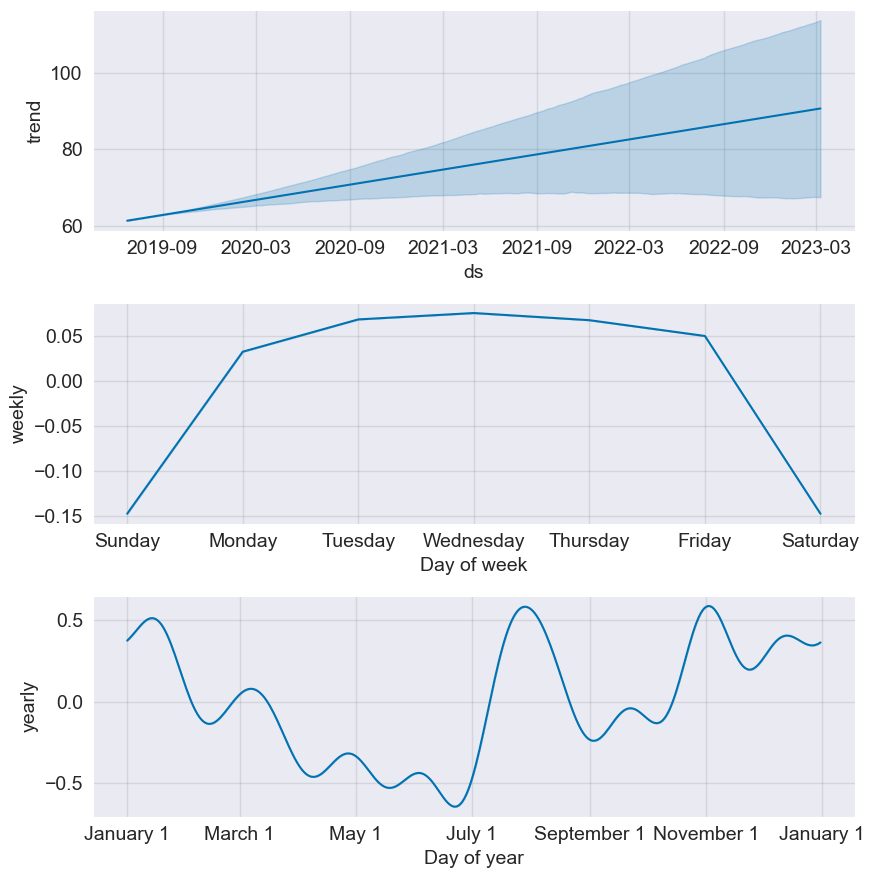

In [43]:
prophet_model.plot_components(prophed_pred_df);

#### Evaluate Prophet model performance

In [44]:
evaluate_model(test_data[['y']], prophed_pred_df[['yhat']])

Root Mean squared error: 32.282137071880996
Mean absolute error: 23.49874407473416
Mean absolute percentage error: 0.19902085469893316


Based on the evaluation metrics of the three models, it is evident that the Prophet model outperforms the others

### Hyper Parameter Tunning of Prophet model

Hyperparameter tuning is the process of selecting the optimal values for the parameters of a machine learning model that are not learned during training. The goal of hyperparameter tuning is to improve the performance of a model by finding the best combination of hyperparameters that minimize the error on the validation set or maximize some other performance metric. This is typically done by performing a grid search or a randomized search over a range of hyperparameter values.

I have used [this](https://facebook.github.io/prophet/docs/diagnostics.html) documentation for hyperparameter tunning.


We will **cross_validation** and **performance_metrics** methods provided by Prophet for Hyper Parameter Tunning.

**cross_validation**

Cross-validation is a resampling method that uses different portions of the data to test and train a model on different iterations. It is mainly used to estimate how accurately a predictive model will perform in practice. Prophet provides inbuilt **cross_validation** function.

**performance_metrics**
This utility takes output of the cross_validation and provides multiple evaluation matrices.

Lets see how it works. 

#### Baseline Prophet model 

Lets apply these techniques on plane vanilla baseline model 

In [45]:
# Initiate the model
baseline_model = Prophet()
# Fit the model on the training dataset
baseline_model.fit(data)
# Cross validation
baseline_model_cv = cross_validation(model=baseline_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")

18:48:16 - cmdstanpy - INFO - Chain [1] start processing
18:48:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:48:19 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] done processing
18:48:19 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] done processing
18:48:19 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] done processing
18:48:19 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] start processing
18:48:19 - cmdstanpy - INFO - Chain [1] done processing
18:48:19 - cmdstanpy - INFO - Chain [1] done p

18:48:24 - cmdstanpy - INFO - Chain [1] done processing
18:48:24 - cmdstanpy - INFO - Chain [1] done processing
18:48:24 - cmdstanpy - INFO - Chain [1] done processing
18:48:24 - cmdstanpy - INFO - Chain [1] done processing
18:48:24 - cmdstanpy - INFO - Chain [1] start processing
18:48:24 - cmdstanpy - INFO - Chain [1] start processing
18:48:24 - cmdstanpy - INFO - Chain [1] start processing
18:48:24 - cmdstanpy - INFO - Chain [1] done processing
18:48:24 - cmdstanpy - INFO - Chain [1] start processing
18:48:24 - cmdstanpy - INFO - Chain [1] done processing
18:48:24 - cmdstanpy - INFO - Chain [1] done processing
18:48:24 - cmdstanpy - INFO - Chain [1] start processing
18:48:24 - cmdstanpy - INFO - Chain [1] start processing
18:48:24 - cmdstanpy - INFO - Chain [1] start processing
18:48:24 - cmdstanpy - INFO - Chain [1] done processing
18:48:24 - cmdstanpy - INFO - Chain [1] done processing
18:48:24 - cmdstanpy - INFO - Chain [1] start processing
18:48:24 - cmdstanpy - INFO - Chain [1] 

18:48:40 - cmdstanpy - INFO - Chain [1] start processing
18:48:40 - cmdstanpy - INFO - Chain [1] start processing
18:48:40 - cmdstanpy - INFO - Chain [1] start processing
18:48:40 - cmdstanpy - INFO - Chain [1] start processing
18:48:40 - cmdstanpy - INFO - Chain [1] done processing
18:48:41 - cmdstanpy - INFO - Chain [1] done processing
18:48:41 - cmdstanpy - INFO - Chain [1] start processing
18:48:41 - cmdstanpy - INFO - Chain [1] done processing
18:48:41 - cmdstanpy - INFO - Chain [1] start processing
18:48:41 - cmdstanpy - INFO - Chain [1] done processing
18:48:42 - cmdstanpy - INFO - Chain [1] start processing
18:48:42 - cmdstanpy - INFO - Chain [1] start processing
18:48:42 - cmdstanpy - INFO - Chain [1] done processing
18:48:43 - cmdstanpy - INFO - Chain [1] start processing
18:48:43 - cmdstanpy - INFO - Chain [1] done processing
18:48:44 - cmdstanpy - INFO - Chain [1] done processing
18:48:44 - cmdstanpy - INFO - Chain [1] done processing
18:48:44 - cmdstanpy - INFO - Chain [1]

18:49:18 - cmdstanpy - INFO - Chain [1] done processing


Getting evaluation matrices using **performance_metrics**, Prophet provides six commonly used performance metrics.
* Mean Squared Error(MSE) 
* Root Mean Square Error(RMSE) 
* Mean Absolute Error(MAE) 
* Mean Absolute Percentage Error(MAPE) 
* Median Absolute Percentage Error(MDAPE) 
* Symmetric Mean Absolute Percentage Error(SMAPE) 

Refer following links to understand more on evaluation matrices

* https://stephenallwright.com/mdape/
* https://towardsdatascience.com/forecast-kpi-rmse-mae-mape-bias-cdc5703d242d
* https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error


We will use **Mean Absolute Percentage Error (MAPE)** to compare the model performance.


In [46]:
baseline_model_p = performance_metrics(baseline_model_cv, rolling_window=1)
baseline_model_p

horizon        mse      rmse       mae      mape     mdape     smape  \
0 30 days  128.73579  11.34618  5.452657  0.113067  0.076289  0.113342   

   coverage  
0  0.352616

In [47]:
print("Baseline Prophet model MAPE :",baseline_model_p['mape'].values[0])

Baseline Prophet model MAPE : 0.11306741475685418


#### Manual Hyperparameter Tunning

According to document **changepoint_range** hyperparameter we can tune manually. changepoint_range is a value between 0 and 1 indicating the percentage of historical data that allow a trend change.

Read more about cangepoint_range [here](https://facebook.github.io/prophet/docs/diagnostics.html)


In [49]:
print("Default value of changepoint_range :",prophet_model.changepoint_range)

Default value of changepoint_range : 0.8


Lets increase changepoint_range from 0.8 to 0.99 and calculate the MAPE

In [50]:
# Initiate the model
manual_model = Prophet(changepoint_range=0.99)
# Fit the model on the training dataset
manual_model.fit(data)
# Cross validation
manual_model_cv = cross_validation(manual_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
# Model performance metrics
manual_model_p = performance_metrics(manual_model_cv, rolling_window=1)

18:49:46 - cmdstanpy - INFO - Chain [1] start processing
18:49:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing
18:49:50 - cmdstanpy - INFO - Chain [1] done processing
18:49:50 - cmdstanpy - INFO - Chain [1] start processing
18:49:50 - cmdstanpy - INFO - Chain [1] done pr

18:49:55 - cmdstanpy - INFO - Chain [1] done processing
18:49:55 - cmdstanpy - INFO - Chain [1] start processing
18:49:55 - cmdstanpy - INFO - Chain [1] done processing
18:49:55 - cmdstanpy - INFO - Chain [1] done processing
18:49:55 - cmdstanpy - INFO - Chain [1] done processing
18:49:55 - cmdstanpy - INFO - Chain [1] start processing
18:49:55 - cmdstanpy - INFO - Chain [1] start processing
18:49:56 - cmdstanpy - INFO - Chain [1] done processing
18:49:56 - cmdstanpy - INFO - Chain [1] start processing
18:49:56 - cmdstanpy - INFO - Chain [1] done processing
18:49:56 - cmdstanpy - INFO - Chain [1] start processing
18:49:56 - cmdstanpy - INFO - Chain [1] done processing
18:49:56 - cmdstanpy - INFO - Chain [1] start processing
18:49:56 - cmdstanpy - INFO - Chain [1] done processing
18:49:56 - cmdstanpy - INFO - Chain [1] done processing
18:49:56 - cmdstanpy - INFO - Chain [1] start processing
18:49:56 - cmdstanpy - INFO - Chain [1] done processing
18:49:56 - cmdstanpy - INFO - Chain [1] s

18:50:13 - cmdstanpy - INFO - Chain [1] done processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing
18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing
18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] start processing
18:50:13 - cmdstanpy - INFO - Chain [1] done processing
18:50:14 - cmdstanpy - INFO - Chain [1] start processing
18:50:14 - cmdstanpy - INFO - Chain [1] done processing
18:50:14 - cmdstanpy - INFO - Chain [1] start processing
18:50:14 - cmdstanpy - INFO - Chain [1] done processing
18:50:15 - cmdstanpy - INFO - Chain [1] done processing
18:50:15 - cmdstanpy - INFO - Chain [1] start processing
18:50:15 - cmdstanpy - INFO - Chain [1] start processing
18:50:16 - cmdstanpy - INFO - Chain [1] done processing
18:50:16 - cmdstanpy - INFO - Chain [1] 

In [51]:
print("Manual Prophet model MAPE :",manual_model_p['mape'].values[0])

Manual Prophet model MAPE : 0.07426088232342526


MAPE values has decreased, Thats a good sign Model is performing better for this setting 

#### Automatic Hyperparameter Tuning

According to documentation, following hyperparameters that are suitable to be tuned automatically, we will use grid search method for the tunning 

* changepoint_prior_scale
* seasonality_prior_scale
* seasonality_mode.

Read more about each parameter [here](https://facebook.github.io/prophet/docs/diagnostics.html)


In [52]:
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_range': [0.99,0.8]
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Create a list to store MAPE values for each combination
mapes = [] 
# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(data)  
    # Cross-validation
    df_cv = cross_validation(m, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

18:51:49 - cmdstanpy - INFO - Chain [1] start processing
18:51:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:51:51 - cmdstanpy - INFO - Chain [1] start processing
18:51:51 - cmdstanpy - INFO - Chain [1] start processing
18:51:51 - cmdstanpy - INFO - Chain [1] done processing
18:51:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:51:51 - cmdstanpy - INFO - Chain [1] start processing
18:51:51 - cmdstanpy - INFO - Chain [1] done processing
18:51:51 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:51:52 - cmdstanpy - INFO - Chain [1] start processing
18:51:52 - cmdstanpy - INFO - Chain [1] start processing
18:51:52 - cmdstanpy - INFO - Chain [1] start processing
18:51:52 - cmdstanpy 

18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing
18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing
18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing
18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] start processing
18:51:55 - cmdstanpy - INFO - Chain [1] done processing
18:51:55 - cmdstanpy - INFO - Chain [1

18:52:00 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] start processing
18:52:00 - cmdstanpy - INFO - Chain [1] done processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing
18:52:01 - cmdstanpy - INFO - Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing
18:52:01 - cmdstanpy - INFO - Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1] done processing
18:52:01 - cmdstanpy - INFO - Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1] start processing
18:52:01 - cmdstanpy - INFO - Chain [1

18:52:08 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] done processing
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1] start processing
18:52:10 - cmdstanpy - INFO - Chain [1]

18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] done processing
18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] done processing
18:52:18 - cmdstanpy - INFO - Chain [1] done processing
18:52:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:52:18 - cmdstanpy - INFO - Chain [1] done processing
18:52:18 - cmdstanpy - INFO - Chain [1] done processing
18:52:18 - cmdstanpy - INFO - Chain [1] done processing
18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] start processing
18:52:18 - cmdstanpy - INFO - Chain [1] start processi

18:52:27 - cmdstanpy - INFO - Chain [1] done processing
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
18:52:27 - cmdstanpy - INFO - Chain [1] start processing
18:52:27 - cmdstanpy - INFO - Chain [1] done processing
18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] 

18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
18:52:33 - cmdstanpy - INFO - Chain [1] start processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
18:52:33 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] 

18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processin

18:52:50 - cmdstanpy - INFO - Chain [1] start processing
18:52:50 - cmdstanpy - INFO - Chain [1] done processing
18:52:50 - cmdstanpy - INFO - Chain [1] start processing
18:52:50 - cmdstanpy - INFO - Chain [1] done processing
18:52:50 - cmdstanpy - INFO - Chain [1] done processing
18:52:50 - cmdstanpy - INFO - Chain [1] start processing
18:52:50 - cmdstanpy - INFO - Chain [1] done processing
18:52:50 - cmdstanpy - INFO - Chain [1] start processing
18:52:50 - cmdstanpy - INFO - Chain [1] start processing
18:52:50 - cmdstanpy - INFO - Chain [1] done processing
18:52:50 - cmdstanpy - INFO - Chain [1] start processing
18:52:50 - cmdstanpy - INFO - Chain [1] done processing
18:52:50 - cmdstanpy - INFO - Chain [1] done processing
18:52:50 - cmdstanpy - INFO - Chain [1] start processing
18:52:50 - cmdstanpy - INFO - Chain [1] done processing
18:52:51 - cmdstanpy - INFO - Chain [1] done processing
18:52:51 - cmdstanpy - INFO - Chain [1] start processing
18:52:51 - cmdstanpy - INFO - Chain [1] 

18:52:56 - cmdstanpy - INFO - Chain [1] done processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
18:52:56 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
18:52:56 - cmdstanpy - INFO - Chain [1] start processing
18:52:56 - cmdstanpy - INFO - Chain [1] done processing
18:52:57 - cmdstanpy - INFO - Chain [1] start processing
18:52:57 - cmdstanpy - INFO - Chain [1] done processing
18:52:57 - cmdstanpy - INFO - Chain [1] done processing
18:52:57 - cmdstanpy - INFO - Chain [1] done processing
18:52:57 - cmdstanpy - INFO - Chain [1] done processing
18:52:57 - cmdstanpy - INFO - Chain [1] start processing
18:52:57 - cmdstanpy - INFO - Chain [1] done processing
18:52:57 - cmdstanpy - INFO - Chain [1] s

18:53:07 - cmdstanpy - INFO - Chain [1] start processing
18:53:07 - cmdstanpy - INFO - Chain [1] done processing
18:53:07 - cmdstanpy - INFO - Chain [1] done processing
18:53:07 - cmdstanpy - INFO - Chain [1] start processing
18:53:07 - cmdstanpy - INFO - Chain [1] done processing
18:53:07 - cmdstanpy - INFO - Chain [1] start processing
18:53:07 - cmdstanpy - INFO - Chain [1] start processing
18:53:08 - cmdstanpy - INFO - Chain [1] done processing
18:53:08 - cmdstanpy - INFO - Chain [1] done processing
18:53:08 - cmdstanpy - INFO - Chain [1] done processing
18:53:08 - cmdstanpy - INFO - Chain [1] done processing
18:53:08 - cmdstanpy - INFO - Chain [1] done processing
18:53:08 - cmdstanpy - INFO - Chain [1] start processing
18:53:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:53:11 - cmdstanpy - INFO - Chain [1] start processing
18:53:11 - cmdstanpy - INFO - Chain [1] done proce

18:53:14 - cmdstanpy - INFO - Chain [1] done processing
18:53:14 - cmdstanpy - INFO - Chain [1] start processing
18:53:14 - cmdstanpy - INFO - Chain [1] done processing
18:53:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:53:14 - cmdstanpy - INFO - Chain [1] done processing
18:53:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:53:14 - cmdstanpy - INFO - Chain [1] done processing
18:53:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:53:14 - cmdstanpy - INFO - Chain [1] done processing
18:53:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:53:14 - cmdstanpy - INFO - Chain [1] start p

18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing
18:53:24 - cmdstanpy - INFO - Chain [1] 

18:53:30 - cmdstanpy - INFO - Chain [1] done processing
18:53:30 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1]

18:53:40 - cmdstanpy - INFO - Chain [1] done processing
18:53:40 - cmdstanpy - INFO - Chain [1] start processing
18:53:41 - cmdstanpy - INFO - Chain [1] start processing
18:53:41 - cmdstanpy - INFO - Chain [1] start processing
18:53:41 - cmdstanpy - INFO - Chain [1] start processing
18:53:41 - cmdstanpy - INFO - Chain [1] done processing
18:53:41 - cmdstanpy - INFO - Chain [1] done processing
18:53:41 - cmdstanpy - INFO - Chain [1] done processing
18:53:41 - cmdstanpy - INFO - Chain [1] start processing
18:53:41 - cmdstanpy - INFO - Chain [1] start processing
18:53:41 - cmdstanpy - INFO - Chain [1] done processing
18:53:41 - cmdstanpy - INFO - Chain [1] start processing
18:53:41 - cmdstanpy - INFO - Chain [1] done processing
18:53:41 - cmdstanpy - INFO - Chain [1] start processing
18:53:41 - cmdstanpy - INFO - Chain [1] done processing
18:53:41 - cmdstanpy - INFO - Chain [1] done processing
18:53:41 - cmdstanpy - INFO - Chain [1] start processing
18:53:41 - cmdstanpy - INFO - Chain [1]

18:53:46 - cmdstanpy - INFO - Chain [1] done processing
18:53:46 - cmdstanpy - INFO - Chain [1] done processing
18:53:46 - cmdstanpy - INFO - Chain [1] done processing
18:53:46 - cmdstanpy - INFO - Chain [1] done processing
18:53:46 - cmdstanpy - INFO - Chain [1] start processing
18:53:47 - cmdstanpy - INFO - Chain [1] start processing
18:53:47 - cmdstanpy - INFO - Chain [1] start processing
18:53:47 - cmdstanpy - INFO - Chain [1] start processing
18:53:47 - cmdstanpy - INFO - Chain [1] start processing
18:53:47 - cmdstanpy - INFO - Chain [1] done processing
18:53:47 - cmdstanpy - INFO - Chain [1] done processing
18:53:47 - cmdstanpy - INFO - Chain [1] done processing
18:53:47 - cmdstanpy - INFO - Chain [1] done processing
18:53:47 - cmdstanpy - INFO - Chain [1] done processing
18:53:47 - cmdstanpy - INFO - Chain [1] start processing
18:53:47 - cmdstanpy - INFO - Chain [1] start processing
18:53:47 - cmdstanpy - INFO - Chain [1] start processing
18:53:47 - cmdstanpy - INFO - Chain [1] 

18:53:53 - cmdstanpy - INFO - Chain [1] done processing
18:53:53 - cmdstanpy - INFO - Chain [1] done processing
18:53:53 - cmdstanpy - INFO - Chain [1] start processing
18:53:54 - cmdstanpy - INFO - Chain [1] start processing
18:53:54 - cmdstanpy - INFO - Chain [1] start processing
18:53:54 - cmdstanpy - INFO - Chain [1] start processing
18:53:54 - cmdstanpy - INFO - Chain [1] done processing
18:53:54 - cmdstanpy - INFO - Chain [1] done processing
18:53:54 - cmdstanpy - INFO - Chain [1] start processing
18:53:54 - cmdstanpy - INFO - Chain [1] done processing
18:53:54 - cmdstanpy - INFO - Chain [1] done processing
18:53:54 - cmdstanpy - INFO - Chain [1] done processing
18:53:54 - cmdstanpy - INFO - Chain [1] done processing
18:53:54 - cmdstanpy - INFO - Chain [1] done processing
18:53:54 - cmdstanpy - INFO - Chain [1] start processing
18:53:54 - cmdstanpy - INFO - Chain [1] start processing
18:53:54 - cmdstanpy - INFO - Chain [1] start processing
18:53:54 - cmdstanpy - INFO - Chain [1] 

18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] done processing
18:54:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] done processing
18:54:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:54:05 - cmdstanpy - INFO - Chain [1] done processing
18:54:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO 

18:54:08 - cmdstanpy - INFO - Chain [1] start processing
18:54:08 - cmdstanpy - INFO - Chain [1] done processing
18:54:08 - cmdstanpy - INFO - Chain [1] start processing
18:54:08 - cmdstanpy - INFO - Chain [1] done processing
18:54:09 - cmdstanpy - INFO - Chain [1] start processing
18:54:09 - cmdstanpy - INFO - Chain [1] done processing
18:54:09 - cmdstanpy - INFO - Chain [1] start processing
18:54:09 - cmdstanpy - INFO - Chain [1] done processing
18:54:09 - cmdstanpy - INFO - Chain [1] start processing
18:54:09 - cmdstanpy - INFO - Chain [1] done processing
18:54:09 - cmdstanpy - INFO - Chain [1] start processing
18:54:10 - cmdstanpy - INFO - Chain [1] done processing
18:54:10 - cmdstanpy - INFO - Chain [1] start processing
18:54:10 - cmdstanpy - INFO - Chain [1] done processing
18:54:10 - cmdstanpy - INFO - Chain [1] start processing
18:54:10 - cmdstanpy - INFO - Chain [1] done processing
18:54:10 - cmdstanpy - INFO - Chain [1] start processing
18:54:11 - cmdstanpy - INFO - Chain [1]

18:54:15 - cmdstanpy - INFO - Chain [1] start processing
18:54:15 - cmdstanpy - INFO - Chain [1] start processing
18:54:15 - cmdstanpy - INFO - Chain [1] start processing
18:54:15 - cmdstanpy - INFO - Chain [1] start processing
18:54:15 - cmdstanpy - INFO - Chain [1] start processing
18:54:15 - cmdstanpy - INFO - Chain [1] start processing
18:54:15 - cmdstanpy - INFO - Chain [1] done processing
18:54:15 - cmdstanpy - INFO - Chain [1] start processing
18:54:15 - cmdstanpy - INFO - Chain [1] done processing
18:54:15 - cmdstanpy - INFO - Chain [1] done processing
18:54:15 - cmdstanpy - INFO - Chain [1] done processing
18:54:15 - cmdstanpy - INFO - Chain [1] done processing
18:54:15 - cmdstanpy - INFO - Chain [1] done processing
18:54:15 - cmdstanpy - INFO - Chain [1] done processing
18:54:15 - cmdstanpy - INFO - Chain [1] start processing
18:54:15 - cmdstanpy - INFO - Chain [1] start processing
18:54:15 - cmdstanpy - INFO - Chain [1] start processing
18:54:15 - cmdstanpy - INFO - Chain [1

18:54:22 - cmdstanpy - INFO - Chain [1] done processing
18:54:22 - cmdstanpy - INFO - Chain [1] done processing
18:54:22 - cmdstanpy - INFO - Chain [1] done processing
18:54:22 - cmdstanpy - INFO - Chain [1] start processing
18:54:22 - cmdstanpy - INFO - Chain [1] done processing
18:54:22 - cmdstanpy - INFO - Chain [1] done processing
18:54:22 - cmdstanpy - INFO - Chain [1] done processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] done processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] done processing
18:54:23 - cmdstanpy - INFO - Chain [1]

18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing
18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing
18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing
18:54:31 - cmdstanpy - INFO - Chain [1]

18:54:35 - cmdstanpy - INFO - Chain [1] done processing
18:54:35 - cmdstanpy - INFO - Chain [1] start processing
18:54:35 - cmdstanpy - INFO - Chain [1] start processing
18:54:35 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] 

18:54:43 - cmdstanpy - INFO - Chain [1] start processing
18:54:43 - cmdstanpy - INFO - Chain [1] start processing
18:54:43 - cmdstanpy - INFO - Chain [1] start processing
18:54:43 - cmdstanpy - INFO - Chain [1] start processing
18:54:43 - cmdstanpy - INFO - Chain [1] start processing
18:54:43 - cmdstanpy - INFO - Chain [1] start processing
18:54:43 - cmdstanpy - INFO - Chain [1] done processing
18:54:43 - cmdstanpy - INFO - Chain [1] start processing
18:54:43 - cmdstanpy - INFO - Chain [1] done processing
18:54:44 - cmdstanpy - INFO - Chain [1] done processing
18:54:44 - cmdstanpy - INFO - Chain [1] done processing
18:54:44 - cmdstanpy - INFO - Chain [1] done processing
18:54:44 - cmdstanpy - INFO - Chain [1] start processing
18:54:44 - cmdstanpy - INFO - Chain [1] start processing
18:54:44 - cmdstanpy - INFO - Chain [1] start processing
18:54:44 - cmdstanpy - INFO - Chain [1] start processing
18:54:44 - cmdstanpy - INFO - Chain [1] done processing
18:54:44 - cmdstanpy - INFO - Chain [

18:55:01 - cmdstanpy - INFO - Chain [1] start processing
18:55:01 - cmdstanpy - INFO - Chain [1] done processing
18:55:01 - cmdstanpy - INFO - Chain [1] start processing
18:55:01 - cmdstanpy - INFO - Chain [1] done processing
18:55:01 - cmdstanpy - INFO - Chain [1] done processing
18:55:01 - cmdstanpy - INFO - Chain [1] start processing
18:55:01 - cmdstanpy - INFO - Chain [1] start processing
18:55:01 - cmdstanpy - INFO - Chain [1] done processing
18:55:01 - cmdstanpy - INFO - Chain [1] done processing
18:55:01 - cmdstanpy - INFO - Chain [1] start processing
18:55:01 - cmdstanpy - INFO - Chain [1] start processing
18:55:01 - cmdstanpy - INFO - Chain [1] done processing
18:55:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:55:01 - cmdstanpy - INFO - Chain [1] start processing
18:55:01 - cmdstanpy - INFO - Chain [1] done processing
18:55:01 - cmdstanpy - ERROR - Chain [1] error: error d

18:55:07 - cmdstanpy - INFO - Chain [1] start processing
18:55:07 - cmdstanpy - INFO - Chain [1] start processing
18:55:07 - cmdstanpy - INFO - Chain [1] start processing
18:55:07 - cmdstanpy - INFO - Chain [1] done processing
18:55:07 - cmdstanpy - INFO - Chain [1] start processing
18:55:07 - cmdstanpy - INFO - Chain [1] done processing
18:55:07 - cmdstanpy - INFO - Chain [1] done processing
18:55:08 - cmdstanpy - INFO - Chain [1] done processing
18:55:08 - cmdstanpy - INFO - Chain [1] done processing
18:55:08 - cmdstanpy - INFO - Chain [1] done processing
18:55:08 - cmdstanpy - INFO - Chain [1] done processing
18:55:08 - cmdstanpy - INFO - Chain [1] start processing
18:55:08 - cmdstanpy - INFO - Chain [1] start processing
18:55:08 - cmdstanpy - INFO - Chain [1] done processing
18:55:08 - cmdstanpy - INFO - Chain [1] start processing
18:55:08 - cmdstanpy - INFO - Chain [1] start processing
18:55:08 - cmdstanpy - INFO - Chain [1] done processing
18:55:08 - cmdstanpy - INFO - Chain [1] 

18:55:12 - cmdstanpy - INFO - Chain [1] done processing
18:55:12 - cmdstanpy - INFO - Chain [1] done processing
18:55:12 - cmdstanpy - INFO - Chain [1] start processing
18:55:12 - cmdstanpy - INFO - Chain [1] start processing
18:55:12 - cmdstanpy - INFO - Chain [1] done processing
18:55:12 - cmdstanpy - INFO - Chain [1] start processing
18:55:12 - cmdstanpy - INFO - Chain [1] start processing
18:55:12 - cmdstanpy - INFO - Chain [1] start processing
18:55:12 - cmdstanpy - INFO - Chain [1] start processing
18:55:12 - cmdstanpy - INFO - Chain [1] done processing
18:55:12 - cmdstanpy - INFO - Chain [1] done processing
18:55:12 - cmdstanpy - INFO - Chain [1] start processing
18:55:12 - cmdstanpy - INFO - Chain [1] done processing
18:55:13 - cmdstanpy - INFO - Chain [1] start processing
18:55:13 - cmdstanpy - INFO - Chain [1] start processing
18:55:13 - cmdstanpy - INFO - Chain [1] start processing
18:55:13 - cmdstanpy - INFO - Chain [1] done processing
18:55:13 - cmdstanpy - INFO - Chain [1

18:55:27 - cmdstanpy - INFO - Chain [1] start processing
18:55:27 - cmdstanpy - INFO - Chain [1] done processing
18:55:27 - cmdstanpy - INFO - Chain [1] start processing
18:55:27 - cmdstanpy - INFO - Chain [1] start processing
18:55:28 - cmdstanpy - INFO - Chain [1] start processing
18:55:28 - cmdstanpy - INFO - Chain [1] done processing
18:55:28 - cmdstanpy - INFO - Chain [1] done processing
18:55:29 - cmdstanpy - INFO - Chain [1] start processing
18:55:29 - cmdstanpy - INFO - Chain [1] start processing
18:55:29 - cmdstanpy - INFO - Chain [1] done processing
18:55:29 - cmdstanpy - INFO - Chain [1] done processing
18:55:29 - cmdstanpy - INFO - Chain [1] done processing
18:55:29 - cmdstanpy - INFO - Chain [1] done processing
18:55:29 - cmdstanpy - INFO - Chain [1] done processing
18:55:29 - cmdstanpy - INFO - Chain [1] done processing
18:55:29 - cmdstanpy - INFO - Chain [1] start processing
18:55:29 - cmdstanpy - INFO - Chain [1] start processing
18:55:30 - cmdstanpy - INFO - Chain [1] 

18:55:35 - cmdstanpy - INFO - Chain [1] start processing
18:55:35 - cmdstanpy - INFO - Chain [1] start processing
18:55:35 - cmdstanpy - INFO - Chain [1] start processing
18:55:36 - cmdstanpy - INFO - Chain [1] done processing
18:55:36 - cmdstanpy - INFO - Chain [1] start processing
18:55:36 - cmdstanpy - INFO - Chain [1] done processing
18:55:36 - cmdstanpy - INFO - Chain [1] done processing
18:55:36 - cmdstanpy - INFO - Chain [1] done processing
18:55:36 - cmdstanpy - INFO - Chain [1] start processing
18:55:36 - cmdstanpy - INFO - Chain [1] start processing
18:55:36 - cmdstanpy - INFO - Chain [1] start processing
18:55:36 - cmdstanpy - INFO - Chain [1] start processing
18:55:36 - cmdstanpy - INFO - Chain [1] done processing
18:55:36 - cmdstanpy - INFO - Chain [1] done processing
18:55:36 - cmdstanpy - INFO - Chain [1] done processing
18:55:36 - cmdstanpy - INFO - Chain [1] done processing
18:55:36 - cmdstanpy - INFO - Chain [1] done processing
18:55:36 - cmdstanpy - INFO - Chain [1] 

18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing
18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing
18:55:42 - cmdstanpy - INFO - Chain [1] done processing
18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1] start processing
18:55:42 - cmdstanpy - INFO - Chain [1]

18:55:49 - cmdstanpy - INFO - Chain [1] done processing
18:55:49 - cmdstanpy - INFO - Chain [1] done processing
18:55:49 - cmdstanpy - INFO - Chain [1] start processing
18:55:49 - cmdstanpy - INFO - Chain [1] done processing
18:55:49 - cmdstanpy - INFO - Chain [1] done processing
18:55:49 - cmdstanpy - INFO - Chain [1] done processing
18:55:49 - cmdstanpy - INFO - Chain [1] done processing
18:55:49 - cmdstanpy - INFO - Chain [1] start processing
18:55:49 - cmdstanpy - INFO - Chain [1] start processing
18:55:49 - cmdstanpy - INFO - Chain [1] done processing
18:55:50 - cmdstanpy - INFO - Chain [1] start processing
18:55:50 - cmdstanpy - INFO - Chain [1] done processing
18:55:50 - cmdstanpy - INFO - Chain [1] start processing
18:55:50 - cmdstanpy - INFO - Chain [1] done processing
18:55:50 - cmdstanpy - INFO - Chain [1] start processing
18:55:50 - cmdstanpy - INFO - Chain [1] start processing
18:55:50 - cmdstanpy - INFO - Chain [1] start processing
18:55:50 - cmdstanpy - INFO - Chain [1] 

18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:58 - cmdstanpy - INFO - Chain [1] done processing
18:55:58 - cmdstanpy - INFO - Chain [1] done processing
18:55:58 - cmdstanpy - INFO - Chain [1] done processing
18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:58 - cmdstanpy - INFO - Chain [1] done processing
18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:58 - cmdstanpy - INFO - Chain [1] done processing
18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:58 - cmdstanpy - INFO - Chain [1] done processing
18:55:58 - cmdstanpy - INFO - Chain [1] done processing
18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:58 - cmdstanpy - INFO - Chain [1] done processing
18:55:58 - cmdstanpy - INFO - Chain [1] start processing
18:55:58 - cmdstanpy - INFO - Chain [1]

18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1

18:56:10 - cmdstanpy - INFO - Chain [1] start processing
18:56:10 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing
18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] done processing
18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1] start processing
18:56:11 - cmdstanpy - INFO - Chain [1

18:56:22 - cmdstanpy - INFO - Chain [1] start processing
18:56:22 - cmdstanpy - INFO - Chain [1] start processing
18:56:22 - cmdstanpy - INFO - Chain [1] start processing
18:56:22 - cmdstanpy - INFO - Chain [1] done processing
18:56:22 - cmdstanpy - INFO - Chain [1] done processing
18:56:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:56:22 - cmdstanpy - INFO - Chain [1] start processing
18:56:22 - cmdstanpy - INFO - Chain [1] done processing
18:56:22 - cmdstanpy - INFO - Chain [1] start processing
18:56:22 - cmdstanpy - INFO - Chain [1] done processing
18:56:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:56:22 - cmdstanpy - INFO - Chain [1] start processing
18:56:22 - cmdstanpy - INFO - Chain [1] start processing
18:56:22 - cmdstanpy - INFO - Chain [1] start processing
18:56:22 - c

18:56:25 - cmdstanpy - INFO - Chain [1] start processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
18:56:26 - cmdstanpy - INFO - Chain [1] start processing
18:56:26 - cmdstanpy - INFO - Chain [1] start processing
18:56:26 - cmdstanpy - INFO - Chain [1] start processing
18:56:26 - cmdstanpy - INFO - Chain [1] start processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
18:56:26 - cmdstanpy - INFO - Chain [1] start processing
18:56:26 - cmdstanpy - INFO - Chain [1] start processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
18:56:26 - cmdstanpy - INFO - Chain [1] start processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
18:56:26 - cmdstanpy - INFO - Chain [1] done processing
18:56:26 - cmdstanpy - INFO - Chain [1] 

18:56:31 - cmdstanpy - INFO - Chain [1] start processing
18:56:31 - cmdstanpy - INFO - Chain [1] start processing
18:56:31 - cmdstanpy - INFO - Chain [1] done processing
18:56:31 - cmdstanpy - INFO - Chain [1] start processing
18:56:31 - cmdstanpy - INFO - Chain [1] done processing
18:56:31 - cmdstanpy - INFO - Chain [1] done processing
18:56:31 - cmdstanpy - INFO - Chain [1] done processing
18:56:31 - cmdstanpy - INFO - Chain [1] start processing
18:56:31 - cmdstanpy - INFO - Chain [1] done processing
18:56:31 - cmdstanpy - INFO - Chain [1] done processing
18:56:31 - cmdstanpy - INFO - Chain [1] start processing
18:56:31 - cmdstanpy - INFO - Chain [1] start processing
18:56:31 - cmdstanpy - INFO - Chain [1] done processing
18:56:32 - cmdstanpy - INFO - Chain [1] done processing
18:56:32 - cmdstanpy - INFO - Chain [1] start processing
18:56:32 - cmdstanpy - INFO - Chain [1] done processing
18:56:32 - cmdstanpy - INFO - Chain [1] start processing
18:56:32 - cmdstanpy - INFO - Chain [1] 

18:56:48 - cmdstanpy - INFO - Chain [1] start processing
18:56:48 - cmdstanpy - INFO - Chain [1] start processing
18:56:48 - cmdstanpy - INFO - Chain [1] start processing
18:56:48 - cmdstanpy - INFO - Chain [1] done processing
18:56:48 - cmdstanpy - INFO - Chain [1] start processing
18:56:49 - cmdstanpy - INFO - Chain [1] start processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing
18:56:50 - cmdstanpy - INFO - Chain [1] start processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing
18:56:51 - cmdstanpy - INFO - Chain [1] done processing
18:56:51 - cmdstanpy - INFO - Chain [1] start processing
18:56:52 - cmdstanpy - INFO - Chain [1] d

18:56:57 - cmdstanpy - INFO - Chain [1] done processing
18:56:57 - cmdstanpy - INFO - Chain [1] start processing
18:56:57 - cmdstanpy - INFO - Chain [1] start processing
18:56:57 - cmdstanpy - INFO - Chain [1] start processing
18:56:57 - cmdstanpy - INFO - Chain [1] start processing
18:56:57 - cmdstanpy - INFO - Chain [1] done processing
18:56:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:56:57 - cmdstanpy - INFO - Chain [1] done processing
18:56:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:56:57 - cmdstanpy - INFO - Chain [1] done processing
18:56:57 - cmdstanpy - INFO - Chain [1] done processing
18:56:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:56:57 - cmdstanpy - INFO - 

18:57:04 - cmdstanpy - INFO - Chain [1] done processing
18:57:04 - cmdstanpy - INFO - Chain [1] done processing
18:57:04 - cmdstanpy - INFO - Chain [1] done processing
18:57:04 - cmdstanpy - INFO - Chain [1] done processing
18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:04 - cmdstanpy - INFO - Chain [1] done processing
18:57:04 - cmdstanpy - INFO - Chain [1] done processing
18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:04 - cmdstanpy - INFO - Chain [1] done processing
18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:04 - cmdstanpy - INFO - Chain [1] done processing
18:57:04 - cmdstanpy - INFO - Chain [1] done processing
18:57:04 - cmdstanpy - INFO - Chain [1] 

18:57:12 - cmdstanpy - INFO - Chain [1] start processing
18:57:12 - cmdstanpy - INFO - Chain [1] done processing
18:57:13 - cmdstanpy - INFO - Chain [1] start processing
18:57:13 - cmdstanpy - INFO - Chain [1] done processing
18:57:13 - cmdstanpy - INFO - Chain [1] start processing
18:57:13 - cmdstanpy - INFO - Chain [1] start processing
18:57:13 - cmdstanpy - INFO - Chain [1] done processing
18:57:13 - cmdstanpy - INFO - Chain [1] start processing
18:57:14 - cmdstanpy - INFO - Chain [1] start processing
18:57:14 - cmdstanpy - INFO - Chain [1] done processing
18:57:14 - cmdstanpy - INFO - Chain [1] done processing
18:57:14 - cmdstanpy - INFO - Chain [1] done processing
18:57:14 - cmdstanpy - INFO - Chain [1] done processing
18:57:14 - cmdstanpy - INFO - Chain [1] start processing
18:57:15 - cmdstanpy - INFO - Chain [1] start processing
18:57:15 - cmdstanpy - INFO - Chain [1] done processing
18:57:15 - cmdstanpy - INFO - Chain [1] start processing
18:57:15 - cmdstanpy - INFO - Chain [1]

18:57:27 - cmdstanpy - INFO - Chain [1] start processing
18:57:27 - cmdstanpy - INFO - Chain [1] start processing
18:57:27 - cmdstanpy - INFO - Chain [1] done processing
18:57:27 - cmdstanpy - INFO - Chain [1] done processing
18:57:27 - cmdstanpy - INFO - Chain [1] done processing
18:57:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:57:27 - cmdstanpy - INFO - Chain [1] start processing
18:57:27 - cmdstanpy - INFO - Chain [1] done processing
18:57:27 - cmdstanpy - INFO - Chain [1] start processing
18:57:27 - cmdstanpy - INFO - Chain [1] start processing
18:57:27 - cmdstanpy - INFO - Chain [1] start processing
18:57:27 - cmdstanpy - INFO - Chain [1] done processing
18:57:27 - cmdstanpy - INFO - Chain [1] start processing
18:57:27 - cmdstanpy - INFO - Chain [1] done processing
18:57:27 - cmdstanpy - INFO - Chain [1] done processing
18:57:27 - cmdstanpy - INFO - Chain [1] done processing

18:57:31 - cmdstanpy - INFO - Chain [1] done processing
18:57:31 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing
18:57:31 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing
18:57:31 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing
18:57:31 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing
18:57:31 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] start processing
18:57:31 - cmdstanpy - INFO - Chain [1] done processing
18:57:31 - cmdstanpy - INFO - Chain [1]

18:57:36 - cmdstanpy - INFO - Chain [1] start processing
18:57:36 - cmdstanpy - INFO - Chain [1] done processing
18:57:36 - cmdstanpy - INFO - Chain [1] done processing
18:57:36 - cmdstanpy - INFO - Chain [1] done processing
18:57:36 - cmdstanpy - INFO - Chain [1] done processing
18:57:36 - cmdstanpy - INFO - Chain [1] start processing
18:57:36 - cmdstanpy - INFO - Chain [1] done processing
18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] done processing
18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1] done processing
18:57:37 - cmdstanpy - INFO - Chain [1] done processing
18:57:37 - cmdstanpy - INFO - Chain [1] start processing
18:57:37 - cmdstanpy - INFO - Chain [1]

18:57:47 - cmdstanpy - INFO - Chain [1] start processing
18:57:47 - cmdstanpy - INFO - Chain [1] start processing
18:57:47 - cmdstanpy - INFO - Chain [1] start processing
18:57:47 - cmdstanpy - INFO - Chain [1] done processing
18:57:48 - cmdstanpy - INFO - Chain [1] done processing
18:57:48 - cmdstanpy - INFO - Chain [1] done processing
18:57:48 - cmdstanpy - INFO - Chain [1] start processing
18:57:48 - cmdstanpy - INFO - Chain [1] start processing
18:57:48 - cmdstanpy - INFO - Chain [1] done processing
18:57:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:57:48 - cmdstanpy - INFO - Chain [1] done processing
18:57:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:57:48 - cmdstanpy - INFO - Chain [1] start processing
18:57:48 - cmdstanpy - INFO - Chain [1] start processing
18:57:48 - cm

18:57:51 - cmdstanpy - INFO - Chain [1] start processing
18:57:51 - cmdstanpy - INFO - Chain [1] done processing
18:57:51 - cmdstanpy - INFO - Chain [1] start processing
18:57:51 - cmdstanpy - INFO - Chain [1] done processing
18:57:51 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing
18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing
18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing
18:57:52 - cmdstanpy - INFO - Chain [1] start processing
18:57:52 - cmdstanpy - INFO - Chain [1] done processing
18:57:53 - cmdstanpy - INFO - Chain [1] start processing
18:57:53 - cmdstanpy - INFO - Chain [1] done processing
18:57:53 - cmdstanpy - INFO - Chain [1] start processing
18:57:53 - cmdstanpy - INFO - Chain [1] done processing
18:57:53 - cmdstanpy - INFO - Chain [1] start processing
18:57:54 - cmdstanpy - INFO - Chain [1]

18:57:58 - cmdstanpy - INFO - Chain [1] done processing
18:57:58 - cmdstanpy - INFO - Chain [1] done processing
18:57:58 - cmdstanpy - INFO - Chain [1] done processing
18:57:58 - cmdstanpy - INFO - Chain [1] done processing
18:57:58 - cmdstanpy - INFO - Chain [1] done processing
18:57:58 - cmdstanpy - INFO - Chain [1] done processing
18:57:58 - cmdstanpy - INFO - Chain [1] done processing
18:57:58 - cmdstanpy - INFO - Chain [1] start processing
18:57:58 - cmdstanpy - INFO - Chain [1] start processing
18:57:58 - cmdstanpy - INFO - Chain [1] start processing
18:57:58 - cmdstanpy - INFO - Chain [1] start processing
18:57:58 - cmdstanpy - INFO - Chain [1] start processing
18:57:58 - cmdstanpy - INFO - Chain [1] start processing
18:57:58 - cmdstanpy - INFO - Chain [1] start processing
18:57:58 - cmdstanpy - INFO - Chain [1] done processing
18:57:58 - cmdstanpy - INFO - Chain [1] start processing
18:57:59 - cmdstanpy - INFO - Chain [1] done processing
18:57:59 - cmdstanpy - INFO - Chain [1] 

18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:06 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] start processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:06 - cmdstanpy - INFO - Chain [1] done processing
18:58:07 - cmdstanpy - INFO - Chain [1] done processing
18:58:07 - cmdstanpy - INFO - Chain [1] d

18:58:13 - cmdstanpy - INFO - Chain [1] done processing
18:58:13 - cmdstanpy - INFO - Chain [1] start processing
18:58:13 - cmdstanpy - INFO - Chain [1] done processing
18:58:13 - cmdstanpy - INFO - Chain [1] done processing
18:58:13 - cmdstanpy - INFO - Chain [1] start processing
18:58:13 - cmdstanpy - INFO - Chain [1] done processing
18:58:13 - cmdstanpy - INFO - Chain [1] done processing
18:58:13 - cmdstanpy - INFO - Chain [1] start processing
18:58:13 - cmdstanpy - INFO - Chain [1] done processing
18:58:13 - cmdstanpy - INFO - Chain [1] done processing
18:58:13 - cmdstanpy - INFO - Chain [1] start processing
18:58:13 - cmdstanpy - INFO - Chain [1] start processing
18:58:13 - cmdstanpy - INFO - Chain [1] start processing
18:58:13 - cmdstanpy - INFO - Chain [1] start processing
18:58:13 - cmdstanpy - INFO - Chain [1] done processing
18:58:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.

18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] start processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] done processing
18:58:19 - cmdstanpy - INFO - Chain [1] d

18:58:27 - cmdstanpy - INFO - Chain [1] done processing
18:58:27 - cmdstanpy - INFO - Chain [1] done processing
18:58:27 - cmdstanpy - INFO - Chain [1] start processing
18:58:27 - cmdstanpy - INFO - Chain [1] start processing
18:58:27 - cmdstanpy - INFO - Chain [1] done processing
18:58:27 - cmdstanpy - INFO - Chain [1] done processing
18:58:27 - cmdstanpy - INFO - Chain [1] start processing
18:58:27 - cmdstanpy - INFO - Chain [1] done processing
18:58:27 - cmdstanpy - INFO - Chain [1] start processing
18:58:27 - cmdstanpy - INFO - Chain [1] start processing
18:58:27 - cmdstanpy - INFO - Chain [1] start processing
18:58:28 - cmdstanpy - INFO - Chain [1] done processing
18:58:28 - cmdstanpy - INFO - Chain [1] start processing
18:58:28 - cmdstanpy - INFO - Chain [1] done processing
18:58:28 - cmdstanpy - INFO - Chain [1] done processing
18:58:28 - cmdstanpy - INFO - Chain [1] start processing
18:58:28 - cmdstanpy - INFO - Chain [1] start processing
18:58:28 - cmdstanpy - INFO - Chain [1]

18:58:43 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processing
18:58:44 - cmdstanpy - INFO - Chain [1] done processing
18:58:44 - cmdstanpy - INFO - Chain [1] start processin

18:58:50 - cmdstanpy - INFO - Chain [1] start processing
18:58:50 - cmdstanpy - INFO - Chain [1] done processing
18:58:50 - cmdstanpy - INFO - Chain [1] start processing
18:58:50 - cmdstanpy - INFO - Chain [1] done processing
18:58:50 - cmdstanpy - INFO - Chain [1] done processing
18:58:50 - cmdstanpy - INFO - Chain [1] start processing
18:58:50 - cmdstanpy - INFO - Chain [1] done processing
18:58:50 - cmdstanpy - INFO - Chain [1] done processing
18:58:50 - cmdstanpy - INFO - Chain [1] start processing
18:58:50 - cmdstanpy - INFO - Chain [1] done processing
18:58:50 - cmdstanpy - INFO - Chain [1] start processing
18:58:50 - cmdstanpy - INFO - Chain [1] start processing
18:58:50 - cmdstanpy - INFO - Chain [1] start processing
18:58:50 - cmdstanpy - INFO - Chain [1] start processing
18:58:50 - cmdstanpy - INFO - Chain [1] done processing
18:58:50 - cmdstanpy - INFO - Chain [1] done processing
18:58:50 - cmdstanpy - INFO - Chain [1] start processing
18:58:50 - cmdstanpy - INFO - Chain [1]

18:58:54 - cmdstanpy - INFO - Chain [1] done processing
18:58:54 - cmdstanpy - INFO - Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] done processing
18:58:55 - cmdstanpy - INFO - Chain [1] done processing
18:58:55 - cmdstanpy - INFO - Chain [1] done processing
18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] done processing
18:58:55 - cmdstanpy - INFO - Chain [1] done processing
18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] done processing
18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] done processing
18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1] start processing
18:58:55 - cmdstanpy - INFO - Chain [1]

18:59:09 - cmdstanpy - INFO - Chain [1] done processing
18:59:09 - cmdstanpy - INFO - Chain [1] start processing
18:59:09 - cmdstanpy - INFO - Chain [1] done processing
18:59:09 - cmdstanpy - INFO - Chain [1] done processing
18:59:09 - cmdstanpy - INFO - Chain [1] done processing
18:59:09 - cmdstanpy - INFO - Chain [1] done processing
18:59:09 - cmdstanpy - INFO - Chain [1] done processing
18:59:10 - cmdstanpy - INFO - Chain [1] done processing
18:59:10 - cmdstanpy - INFO - Chain [1] start processing
18:59:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
18:59:13 - cmdstanpy - INFO - Chain [1] start processing
18:59:13 - cmdstanpy - INFO - Chain [1] done processing
18:59:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:59:13 - cmdstanpy - INFO - Chain [1] start processing
18:59:13 -

18:59:16 - cmdstanpy - INFO - Chain [1] done processing
18:59:16 - cmdstanpy - INFO - Chain [1] start processing
18:59:16 - cmdstanpy - INFO - Chain [1] start processing
18:59:16 - cmdstanpy - INFO - Chain [1] done processing
18:59:16 - cmdstanpy - INFO - Chain [1] done processing
18:59:16 - cmdstanpy - INFO - Chain [1] done processing
18:59:16 - cmdstanpy - INFO - Chain [1] start processing
18:59:16 - cmdstanpy - INFO - Chain [1] start processing
18:59:16 - cmdstanpy - INFO - Chain [1] start processing
18:59:16 - cmdstanpy - INFO - Chain [1] done processing
18:59:16 - cmdstanpy - INFO - Chain [1] done processing
18:59:16 - cmdstanpy - INFO - Chain [1] done processing
18:59:16 - cmdstanpy - INFO - Chain [1] start processing
18:59:16 - cmdstanpy - INFO - Chain [1] start processing
18:59:16 - cmdstanpy - INFO - Chain [1] start processing
18:59:16 - cmdstanpy - INFO - Chain [1] done processing
18:59:16 - cmdstanpy - INFO - Chain [1] done processing
18:59:16 - cmdstanpy - INFO - Chain [1] 

18:59:21 - cmdstanpy - INFO - Chain [1] done processing
18:59:21 - cmdstanpy - INFO - Chain [1] done processing
18:59:21 - cmdstanpy - INFO - Chain [1] done processing
18:59:22 - cmdstanpy - INFO - Chain [1] done processing
18:59:22 - cmdstanpy - INFO - Chain [1] done processing
18:59:22 - cmdstanpy - INFO - Chain [1] done processing
18:59:22 - cmdstanpy - INFO - Chain [1] done processing
18:59:22 - cmdstanpy - INFO - Chain [1] start processing
18:59:22 - cmdstanpy - INFO - Chain [1] start processing
18:59:22 - cmdstanpy - INFO - Chain [1] start processing
18:59:22 - cmdstanpy - INFO - Chain [1] start processing
18:59:22 - cmdstanpy - INFO - Chain [1] done processing
18:59:22 - cmdstanpy - INFO - Chain [1] start processing
18:59:22 - cmdstanpy - INFO - Chain [1] start processing
18:59:22 - cmdstanpy - INFO - Chain [1] start processing
18:59:22 - cmdstanpy - INFO - Chain [1] done processing
18:59:22 - cmdstanpy - INFO - Chain [1] start processing
18:59:22 - cmdstanpy - INFO - Chain [1] 

18:59:28 - cmdstanpy - INFO - Chain [1] done processing
18:59:28 - cmdstanpy - INFO - Chain [1] start processing
18:59:28 - cmdstanpy - INFO - Chain [1] start processing
18:59:28 - cmdstanpy - INFO - Chain [1] done processing
18:59:28 - cmdstanpy - INFO - Chain [1] done processing
18:59:29 - cmdstanpy - INFO - Chain [1] start processing
18:59:29 - cmdstanpy - INFO - Chain [1] done processing
18:59:29 - cmdstanpy - INFO - Chain [1] start processing
18:59:29 - cmdstanpy - INFO - Chain [1] done processing
18:59:29 - cmdstanpy - INFO - Chain [1] start processing
18:59:29 - cmdstanpy - INFO - Chain [1] start processing
18:59:29 - cmdstanpy - INFO - Chain [1] done processing
18:59:29 - cmdstanpy - INFO - Chain [1] start processing
18:59:29 - cmdstanpy - INFO - Chain [1] done processing
18:59:29 - cmdstanpy - INFO - Chain [1] start processing
18:59:29 - cmdstanpy - INFO - Chain [1] done processing
18:59:29 - cmdstanpy - INFO - Chain [1] done processing
18:59:29 - cmdstanpy - INFO - Chain [1] 

18:59:36 - cmdstanpy - INFO - Chain [1] start processing
18:59:36 - cmdstanpy - INFO - Chain [1] start processing
18:59:36 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] done processing
18:59:37 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] done processing
18:59:37 - cmdstanpy - INFO - Chain [1] done processing
18:59:37 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] done processing
18:59:37 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] done processing
18:59:37 - cmdstanpy - INFO - Chain [1] done processing
18:59:37 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] start processing
18:59:37 - cmdstanpy - INFO - Chain [1] done processing
18:59:37 - cmdstanpy - INFO - Chain [1

18:59:43 - cmdstanpy - INFO - Chain [1] done processing
18:59:43 - cmdstanpy - INFO - Chain [1] done processing
18:59:43 - cmdstanpy - INFO - Chain [1] start processing
18:59:43 - cmdstanpy - INFO - Chain [1] done processing
18:59:43 - cmdstanpy - INFO - Chain [1] done processing
18:59:43 - cmdstanpy - INFO - Chain [1] start processing
18:59:43 - cmdstanpy - INFO - Chain [1] done processing
18:59:43 - cmdstanpy - INFO - Chain [1] start processing
18:59:43 - cmdstanpy - INFO - Chain [1] start processing
18:59:44 - cmdstanpy - INFO - Chain [1] done processing
18:59:44 - cmdstanpy - INFO - Chain [1] start processing
18:59:44 - cmdstanpy - INFO - Chain [1] start processing
18:59:44 - cmdstanpy - INFO - Chain [1] done processing
18:59:44 - cmdstanpy - INFO - Chain [1] done processing
18:59:44 - cmdstanpy - INFO - Chain [1] start processing
18:59:44 - cmdstanpy - INFO - Chain [1] done processing
18:59:44 - cmdstanpy - INFO - Chain [1] done processing
18:59:44 - cmdstanpy - INFO - Chain [1] s

18:59:48 - cmdstanpy - INFO - Chain [1] done processing
18:59:48 - cmdstanpy - INFO - Chain [1] done processing
18:59:48 - cmdstanpy - INFO - Chain [1] start processing
18:59:48 - cmdstanpy - INFO - Chain [1] done processing
18:59:48 - cmdstanpy - INFO - Chain [1] done processing
18:59:48 - cmdstanpy - INFO - Chain [1] done processing
18:59:48 - cmdstanpy - INFO - Chain [1] start processing
18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:49 - cmdstanpy - INFO - Chain [1] done processing
18:59:49 - cmdstanpy - INFO - Chain [1] done processing
18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:49 - cmdstanpy - INFO - Chain [1] done processing
18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:49 - cmdstanpy - INFO - Chain [1]

18:59:59 - cmdstanpy - INFO - Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] done processing
18:59:59 - cmdstanpy - INFO - Chain [1] done processing
18:59:59 - cmdstanpy - INFO - Chain [1] done processing
18:59:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
18:59:59 - cmdstanpy - INFO - Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] done processing
18:59:59 - cmdstanpy - INFO - Chain [1] done processing
18:59:59 - cmdstanpy - INFO - Chain [1] done processing
18:59:59 - cmdstanpy - INFO - Chain [1] start processing
18:59:59 - cmdstanpy - INFO - Chain [1] start processi

19:00:02 - cmdstanpy - INFO - Chain [1] done processing
19:00:02 - cmdstanpy - INFO - Chain [1] done processing
19:00:02 - cmdstanpy - INFO - Chain [1] done processing
19:00:02 - cmdstanpy - INFO - Chain [1] done processing
19:00:02 - cmdstanpy - INFO - Chain [1] start processing
19:00:02 - cmdstanpy - INFO - Chain [1] start processing
19:00:02 - cmdstanpy - INFO - Chain [1] start processing
19:00:02 - cmdstanpy - INFO - Chain [1] start processing
19:00:02 - cmdstanpy - INFO - Chain [1] done processing
19:00:02 - cmdstanpy - INFO - Chain [1] done processing
19:00:02 - cmdstanpy - INFO - Chain [1] done processing
19:00:02 - cmdstanpy - INFO - Chain [1] done processing
19:00:02 - cmdstanpy - INFO - Chain [1] start processing
19:00:02 - cmdstanpy - INFO - Chain [1] start processing
19:00:02 - cmdstanpy - INFO - Chain [1] start processing
19:00:02 - cmdstanpy - INFO - Chain [1] start processing
19:00:02 - cmdstanpy - INFO - Chain [1] done processing
19:00:03 - cmdstanpy - INFO - Chain [1] 

19:00:07 - cmdstanpy - INFO - Chain [1] done processing
19:00:07 - cmdstanpy - INFO - Chain [1] start processing
19:00:07 - cmdstanpy - INFO - Chain [1] done processing
19:00:07 - cmdstanpy - INFO - Chain [1] done processing
19:00:07 - cmdstanpy - INFO - Chain [1] start processing
19:00:07 - cmdstanpy - INFO - Chain [1] start processing
19:00:07 - cmdstanpy - INFO - Chain [1] done processing
19:00:07 - cmdstanpy - INFO - Chain [1] start processing
19:00:07 - cmdstanpy - INFO - Chain [1] done processing
19:00:07 - cmdstanpy - INFO - Chain [1] done processing
19:00:08 - cmdstanpy - INFO - Chain [1] start processing
19:00:08 - cmdstanpy - INFO - Chain [1] start processing
19:00:08 - cmdstanpy - INFO - Chain [1] start processing
19:00:08 - cmdstanpy - INFO - Chain [1] done processing
19:00:08 - cmdstanpy - INFO - Chain [1] start processing
19:00:08 - cmdstanpy - INFO - Chain [1] done processing
19:00:08 - cmdstanpy - INFO - Chain [1] done processing
19:00:08 - cmdstanpy - INFO - Chain [1] 

19:00:18 - cmdstanpy - INFO - Chain [1] start processing
19:00:18 - cmdstanpy - INFO - Chain [1] start processing
19:00:18 - cmdstanpy - INFO - Chain [1] done processing
19:00:19 - cmdstanpy - INFO - Chain [1] start processing
19:00:19 - cmdstanpy - INFO - Chain [1] start processing
19:00:20 - cmdstanpy - INFO - Chain [1] done processing
19:00:21 - cmdstanpy - INFO - Chain [1] start processing
19:00:21 - cmdstanpy - INFO - Chain [1] done processing
19:00:21 - cmdstanpy - INFO - Chain [1] start processing
19:00:22 - cmdstanpy - INFO - Chain [1] done processing
19:00:22 - cmdstanpy - INFO - Chain [1] done processing
19:00:23 - cmdstanpy - INFO - Chain [1] done processing
19:00:23 - cmdstanpy - INFO - Chain [1] start processing
19:00:23 - cmdstanpy - INFO - Chain [1] done processing
19:00:23 - cmdstanpy - INFO - Chain [1] done processing
19:00:23 - cmdstanpy - INFO - Chain [1] start processing
19:00:23 - cmdstanpy - INFO - Chain [1] start processing
19:00:23 - cmdstanpy - INFO - Chain [1]

19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
19:00:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Stale NFS file handle
Optimization terminated abnormally. Falling back to Newton.
19:00:33 - cmdstanpy - INFO - Chain [1] done processing
19:00:33 - cmdstanpy - INFO - Chain [1] start processing
19:00:34 - cmdstanpy - INFO - Chain [1] start processin

19:00:39 - cmdstanpy - INFO - Chain [1] start processing
19:00:39 - cmdstanpy - INFO - Chain [1] done processing
19:00:40 - cmdstanpy - INFO - Chain [1] done processing
19:00:40 - cmdstanpy - INFO - Chain [1] start processing
19:00:40 - cmdstanpy - INFO - Chain [1] done processing
19:00:40 - cmdstanpy - INFO - Chain [1] start processing
19:00:40 - cmdstanpy - INFO - Chain [1] done processing
19:00:40 - cmdstanpy - INFO - Chain [1] start processing
19:00:40 - cmdstanpy - INFO - Chain [1] start processing
19:00:40 - cmdstanpy - INFO - Chain [1] start processing
19:00:40 - cmdstanpy - INFO - Chain [1] start processing
19:00:40 - cmdstanpy - INFO - Chain [1] done processing
19:00:40 - cmdstanpy - INFO - Chain [1] done processing
19:00:40 - cmdstanpy - INFO - Chain [1] done processing
19:00:40 - cmdstanpy - INFO - Chain [1] start processing
19:00:40 - cmdstanpy - INFO - Chain [1] done processing
19:00:40 - cmdstanpy - INFO - Chain [1] done processing
19:00:40 - cmdstanpy - INFO - Chain [1] 

19:00:46 - cmdstanpy - INFO - Chain [1] start processing
19:00:46 - cmdstanpy - INFO - Chain [1] start processing
19:00:46 - cmdstanpy - INFO - Chain [1] done processing
19:00:46 - cmdstanpy - INFO - Chain [1] done processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1] done processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1] done processing
19:00:47 - cmdstanpy - INFO - Chain [1] done processing
19:00:47 - cmdstanpy - INFO - Chain [1] done processing
19:00:47 - cmdstanpy - INFO - Chain [1] done processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1] start processing
19:00:47 - cmdstanpy - INFO - Chain [1] done processing
19:00:48 - cmdstanpy - INFO - Chain [1]

19:01:05 - cmdstanpy - INFO - Chain [1] start processing
19:01:05 - cmdstanpy - INFO - Chain [1] start processing
19:01:05 - cmdstanpy - INFO - Chain [1] done processing
19:01:05 - cmdstanpy - INFO - Chain [1] done processing
19:01:05 - cmdstanpy - INFO - Chain [1] done processing
19:01:05 - cmdstanpy - INFO - Chain [1] done processing
19:01:05 - cmdstanpy - INFO - Chain [1] start processing
19:01:05 - cmdstanpy - INFO - Chain [1] done processing
19:01:05 - cmdstanpy - INFO - Chain [1] done processing
19:01:05 - cmdstanpy - INFO - Chain [1] done processing
19:01:05 - cmdstanpy - INFO - Chain [1] start processing
19:01:05 - cmdstanpy - INFO - Chain [1] start processing
19:01:05 - cmdstanpy - INFO - Chain [1] start processing
19:01:05 - cmdstanpy - INFO - Chain [1] start processing
19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:01:06 - cmdstanpy - INFO - Chain [1] start processing
19:01:06 - cmdstanpy - INFO - Chain [1] done processing
19:01:06 - cmdstanpy - INFO - Chain [1]

19:01:11 - cmdstanpy - INFO - Chain [1] done processing
19:01:11 - cmdstanpy - INFO - Chain [1] start processing
19:01:11 - cmdstanpy - INFO - Chain [1] start processing
19:01:11 - cmdstanpy - INFO - Chain [1] start processing
19:01:12 - cmdstanpy - INFO - Chain [1] done processing
19:01:12 - cmdstanpy - INFO - Chain [1] start processing
19:01:12 - cmdstanpy - INFO - Chain [1] done processing
19:01:12 - cmdstanpy - INFO - Chain [1] done processing
19:01:12 - cmdstanpy - INFO - Chain [1] done processing
19:01:12 - cmdstanpy - INFO - Chain [1] start processing
19:01:12 - cmdstanpy - INFO - Chain [1] start processing
19:01:12 - cmdstanpy - INFO - Chain [1] start processing
19:01:12 - cmdstanpy - INFO - Chain [1] done processing
19:01:12 - cmdstanpy - INFO - Chain [1] done processing
19:01:12 - cmdstanpy - INFO - Chain [1] done processing
19:01:12 - cmdstanpy - INFO - Chain [1] done processing
19:01:12 - cmdstanpy - INFO - Chain [1] start processing
19:01:12 - cmdstanpy - INFO - Chain [1] 

19:01:31 - cmdstanpy - INFO - Chain [1] done processing
19:01:32 - cmdstanpy - INFO - Chain [1] start processing
19:01:32 - cmdstanpy - INFO - Chain [1] done processing
19:01:32 - cmdstanpy - INFO - Chain [1] done processing
19:01:33 - cmdstanpy - INFO - Chain [1] start processing
19:01:33 - cmdstanpy - INFO - Chain [1] start processing
19:01:33 - cmdstanpy - INFO - Chain [1] done processing
19:01:33 - cmdstanpy - INFO - Chain [1] start processing
19:01:34 - cmdstanpy - INFO - Chain [1] done processing
19:01:34 - cmdstanpy - INFO - Chain [1] start processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
19:01:35 - cmdstanpy - INFO - Chain [1] done processing
19:01:36 - cmdstanpy - INFO - Chain [1] start processing
19:01:36 - cmdstanpy - INFO - Chain [1] done processing
19:01:36 - cmdstanpy - INFO - Chain [1] start processing
19:01:36 - cmdstanpy - INFO - Chain [1] start processing
19:01:36 - cmdstanpy - INFO - Chain [1] 

19:02:23 - cmdstanpy - INFO - Chain [1] start processing
19:02:23 - cmdstanpy - INFO - Chain [1] done processing
19:02:23 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1]

19:02:29 - cmdstanpy - INFO - Chain [1] done processing
19:02:29 - cmdstanpy - INFO - Chain [1] start processing
19:02:29 - cmdstanpy - INFO - Chain [1] done processing
19:02:30 - cmdstanpy - INFO - Chain [1] done processing
19:02:30 - cmdstanpy - INFO - Chain [1] done processing
19:02:30 - cmdstanpy - INFO - Chain [1] done processing
19:02:30 - cmdstanpy - INFO - Chain [1] start processing
19:02:30 - cmdstanpy - INFO - Chain [1] done processing
19:02:30 - cmdstanpy - INFO - Chain [1] start processing
19:02:30 - cmdstanpy - INFO - Chain [1] start processing
19:02:30 - cmdstanpy - INFO - Chain [1] start processing
19:02:30 - cmdstanpy - INFO - Chain [1] done processing
19:02:30 - cmdstanpy - INFO - Chain [1] start processing
19:02:30 - cmdstanpy - INFO - Chain [1] start processing
19:02:30 - cmdstanpy - INFO - Chain [1] start processing
19:02:30 - cmdstanpy - INFO - Chain [1] done processing
19:02:31 - cmdstanpy - INFO - Chain [1] start processing
19:02:31 - cmdstanpy - INFO - Chain [1]

19:02:51 - cmdstanpy - INFO - Chain [1] start processing
19:02:51 - cmdstanpy - INFO - Chain [1] done processing
19:02:51 - cmdstanpy - INFO - Chain [1] done processing
19:02:51 - cmdstanpy - INFO - Chain [1] done processing
19:02:51 - cmdstanpy - INFO - Chain [1] done processing
19:02:51 - cmdstanpy - INFO - Chain [1] done processing
19:02:51 - cmdstanpy - INFO - Chain [1] done processing
19:02:52 - cmdstanpy - INFO - Chain [1] start processing
19:02:52 - cmdstanpy - INFO - Chain [1] start processing
19:02:52 - cmdstanpy - INFO - Chain [1] start processing
19:02:52 - cmdstanpy - INFO - Chain [1] start processing
19:02:52 - cmdstanpy - INFO - Chain [1] start processing
19:02:52 - cmdstanpy - INFO - Chain [1] start processing
19:02:54 - cmdstanpy - INFO - Chain [1] done processing
19:02:54 - cmdstanpy - INFO - Chain [1] done processing
19:02:55 - cmdstanpy - INFO - Chain [1] done processing
19:02:55 - cmdstanpy - INFO - Chain [1] done processing
19:02:55 - cmdstanpy - INFO - Chain [1] s

19:03:26 - cmdstanpy - INFO - Chain [1] start processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing
19:03:26 - cmdstanpy - INFO - Chain [1] start processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing
19:03:26 - cmdstanpy - INFO - Chain [1] start processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing
19:03:26 - cmdstanpy - INFO - Chain [1] start processing
19:03:26 - cmdstanpy - INFO - Chain [1] start processing
19:03:26 - cmdstanpy - INFO - Chain [1] start processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing
19:03:26 - cmdstanpy - INFO - Chain [1] start processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing
19:03:26 - cmdstanpy - INFO - Chain [1] start processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing
19:03:26 - cmdstanpy - INFO - Chain [1] done processing
19:03:26 - cmdstanpy - INFO - Chain [1] 

19:03:32 - cmdstanpy - INFO - Chain [1] done processing
19:03:32 - cmdstanpy - INFO - Chain [1] done processing
19:03:32 - cmdstanpy - INFO - Chain [1] start processing
19:03:32 - cmdstanpy - INFO - Chain [1] start processing
19:03:32 - cmdstanpy - INFO - Chain [1] done processing
19:03:32 - cmdstanpy - INFO - Chain [1] done processing
19:03:32 - cmdstanpy - INFO - Chain [1] done processing
19:03:32 - cmdstanpy - INFO - Chain [1] start processing
19:03:32 - cmdstanpy - INFO - Chain [1] done processing
19:03:32 - cmdstanpy - INFO - Chain [1] start processing
19:03:32 - cmdstanpy - INFO - Chain [1] done processing
19:03:32 - cmdstanpy - INFO - Chain [1] start processing
19:03:32 - cmdstanpy - INFO - Chain [1] done processing
19:03:33 - cmdstanpy - INFO - Chain [1] start processing
19:03:33 - cmdstanpy - INFO - Chain [1] done processing
19:03:33 - cmdstanpy - INFO - Chain [1] start processing
19:03:33 - cmdstanpy - INFO - Chain [1] start processing
19:03:33 - cmdstanpy - INFO - Chain [1] 

19:03:52 - cmdstanpy - INFO - Chain [1] start processing
19:03:52 - cmdstanpy - INFO - Chain [1] start processing
19:03:52 - cmdstanpy - INFO - Chain [1] done processing
19:03:53 - cmdstanpy - INFO - Chain [1] start processing
19:03:54 - cmdstanpy - INFO - Chain [1] done processing
19:03:54 - cmdstanpy - INFO - Chain [1] done processing
19:03:54 - cmdstanpy - INFO - Chain [1] done processing
19:03:54 - cmdstanpy - INFO - Chain [1] done processing
19:03:55 - cmdstanpy - INFO - Chain [1] start processing
19:03:55 - cmdstanpy - INFO - Chain [1] start processing
19:03:55 - cmdstanpy - INFO - Chain [1] start processing
19:03:55 - cmdstanpy - INFO - Chain [1] done processing
19:03:55 - cmdstanpy - INFO - Chain [1] start processing
19:03:55 - cmdstanpy - INFO - Chain [1] done processing
19:03:55 - cmdstanpy - INFO - Chain [1] start processing
19:03:56 - cmdstanpy - INFO - Chain [1] start processing
19:03:56 - cmdstanpy - INFO - Chain [1] done processing
19:03:56 - cmdstanpy - INFO - Chain [1]

19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] done processing
19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] start processing
19:20:54 - cmdstanpy - INFO - Chain [1] d

19:21:01 - cmdstanpy - INFO - Chain [1] start processing
19:21:01 - cmdstanpy - INFO - Chain [1] done processing
19:21:01 - cmdstanpy - INFO - Chain [1] start processing
19:21:01 - cmdstanpy - INFO - Chain [1] start processing
19:21:01 - cmdstanpy - INFO - Chain [1] done processing
19:21:01 - cmdstanpy - INFO - Chain [1] start processing
19:21:01 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1]

19:21:22 - cmdstanpy - INFO - Chain [1] done processing
19:21:23 - cmdstanpy - INFO - Chain [1] start processing
19:21:23 - cmdstanpy - INFO - Chain [1] done processing
19:21:23 - cmdstanpy - INFO - Chain [1] start processing
19:21:23 - cmdstanpy - INFO - Chain [1] done processing
19:21:23 - cmdstanpy - INFO - Chain [1] done processing
19:21:24 - cmdstanpy - INFO - Chain [1] done processing
19:21:24 - cmdstanpy - INFO - Chain [1] start processing
19:21:24 - cmdstanpy - INFO - Chain [1] start processing
19:21:24 - cmdstanpy - INFO - Chain [1] done processing
19:21:24 - cmdstanpy - INFO - Chain [1] start processing
19:21:24 - cmdstanpy - INFO - Chain [1] start processing
19:21:25 - cmdstanpy - INFO - Chain [1] done processing
19:21:25 - cmdstanpy - INFO - Chain [1] done processing
19:21:26 - cmdstanpy - INFO - Chain [1] start processing
19:21:26 - cmdstanpy - INFO - Chain [1] start processing
19:21:26 - cmdstanpy - INFO - Chain [1] done processing
19:21:27 - cmdstanpy - INFO - Chain [1] 

19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] 

19:22:00 - cmdstanpy - INFO - Chain [1] done processing
19:22:00 - cmdstanpy - INFO - Chain [1] done processing
19:22:00 - cmdstanpy - INFO - Chain [1] done processing
19:22:00 - cmdstanpy - INFO - Chain [1] start processing
19:22:00 - cmdstanpy - INFO - Chain [1] start processing
19:22:00 - cmdstanpy - INFO - Chain [1] start processing
19:22:00 - cmdstanpy - INFO - Chain [1] done processing
19:22:00 - cmdstanpy - INFO - Chain [1] done processing
19:22:00 - cmdstanpy - INFO - Chain [1] done processing
19:22:00 - cmdstanpy - INFO - Chain [1] start processing
19:22:00 - cmdstanpy - INFO - Chain [1] done processing
19:22:01 - cmdstanpy - INFO - Chain [1] start processing
19:22:01 - cmdstanpy - INFO - Chain [1] done processing
19:22:01 - cmdstanpy - INFO - Chain [1] start processing
19:22:01 - cmdstanpy - INFO - Chain [1] start processing
19:22:01 - cmdstanpy - INFO - Chain [1] start processing
19:22:01 - cmdstanpy - INFO - Chain [1] done processing
19:22:01 - cmdstanpy - INFO - Chain [1] 

19:22:23 - cmdstanpy - INFO - Chain [1] start processing
19:22:24 - cmdstanpy - INFO - Chain [1] done processing
19:22:24 - cmdstanpy - INFO - Chain [1] done processing
19:22:25 - cmdstanpy - INFO - Chain [1] start processing
19:22:25 - cmdstanpy - INFO - Chain [1] start processing
19:22:25 - cmdstanpy - INFO - Chain [1] done processing
19:22:25 - cmdstanpy - INFO - Chain [1] done processing
19:22:25 - cmdstanpy - INFO - Chain [1] start processing
19:22:26 - cmdstanpy - INFO - Chain [1] start processing
19:22:26 - cmdstanpy - INFO - Chain [1] done processing
19:22:26 - cmdstanpy - INFO - Chain [1] start processing
19:22:26 - cmdstanpy - INFO - Chain [1] done processing
19:22:27 - cmdstanpy - INFO - Chain [1] done processing
19:22:27 - cmdstanpy - INFO - Chain [1] start processing
19:22:27 - cmdstanpy - INFO - Chain [1] start processing
19:22:27 - cmdstanpy - INFO - Chain [1] done processing
19:22:27 - cmdstanpy - INFO - Chain [1] done processing
19:22:28 - cmdstanpy - INFO - Chain [1] 

19:23:11 - cmdstanpy - INFO - Chain [1] done processing
19:23:11 - cmdstanpy - INFO - Chain [1] done processing
19:23:11 - cmdstanpy - INFO - Chain [1] start processing
19:23:11 - cmdstanpy - INFO - Chain [1] start processing
19:23:11 - cmdstanpy - INFO - Chain [1] done processing
19:23:11 - cmdstanpy - INFO - Chain [1] start processing
19:23:11 - cmdstanpy - INFO - Chain [1] done processing
19:23:11 - cmdstanpy - INFO - Chain [1] start processing
19:23:12 - cmdstanpy - INFO - Chain [1] start processing
19:23:12 - cmdstanpy - INFO - Chain [1] start processing
19:23:12 - cmdstanpy - INFO - Chain [1] start processing
19:23:12 - cmdstanpy - INFO - Chain [1] start processing
19:23:12 - cmdstanpy - INFO - Chain [1] done processing
19:23:12 - cmdstanpy - INFO - Chain [1] done processing
19:23:12 - cmdstanpy - INFO - Chain [1] done processing
19:23:12 - cmdstanpy - INFO - Chain [1] done processing
19:23:12 - cmdstanpy - INFO - Chain [1] done processing
19:23:12 - cmdstanpy - INFO - Chain [1] 

19:23:19 - cmdstanpy - INFO - Chain [1] done processing
19:23:19 - cmdstanpy - INFO - Chain [1] done processing
19:23:19 - cmdstanpy - INFO - Chain [1] start processing
19:23:19 - cmdstanpy - INFO - Chain [1] start processing
19:23:19 - cmdstanpy - INFO - Chain [1] start processing
19:23:19 - cmdstanpy - INFO - Chain [1] done processing
19:23:19 - cmdstanpy - INFO - Chain [1] done processing
19:23:19 - cmdstanpy - INFO - Chain [1] done processing
19:23:19 - cmdstanpy - INFO - Chain [1] start processing
19:23:20 - cmdstanpy - INFO - Chain [1] start processing
19:23:20 - cmdstanpy - INFO - Chain [1] start processing
19:23:20 - cmdstanpy - INFO - Chain [1] done processing
19:23:20 - cmdstanpy - INFO - Chain [1] done processing
19:23:20 - cmdstanpy - INFO - Chain [1] done processing
19:23:20 - cmdstanpy - INFO - Chain [1] done processing
19:23:20 - cmdstanpy - INFO - Chain [1] start processing
19:23:20 - cmdstanpy - INFO - Chain [1] start processing
19:23:20 - cmdstanpy - INFO - Chain [1] 

19:23:43 - cmdstanpy - INFO - Chain [1] done processing
19:23:43 - cmdstanpy - INFO - Chain [1] start processing
19:23:43 - cmdstanpy - INFO - Chain [1] start processing
19:23:46 - cmdstanpy - INFO - Chain [1] done processing
19:23:46 - cmdstanpy - INFO - Chain [1] done processing
19:23:46 - cmdstanpy - INFO - Chain [1] done processing
19:23:46 - cmdstanpy - INFO - Chain [1] done processing
19:23:46 - cmdstanpy - INFO - Chain [1] start processing
19:23:46 - cmdstanpy - INFO - Chain [1] done processing
19:23:46 - cmdstanpy - INFO - Chain [1] start processing
19:23:46 - cmdstanpy - INFO - Chain [1] start processing
19:23:46 - cmdstanpy - INFO - Chain [1] start processing
19:23:46 - cmdstanpy - INFO - Chain [1] start processing
19:23:47 - cmdstanpy - INFO - Chain [1] done processing
19:23:47 - cmdstanpy - INFO - Chain [1] done processing
19:23:47 - cmdstanpy - INFO - Chain [1] done processing
19:23:47 - cmdstanpy - INFO - Chain [1] start processing
19:23:47 - cmdstanpy - INFO - Chain [1] 

19:24:17 - cmdstanpy - INFO - Chain [1] done processing
19:24:17 - cmdstanpy - INFO - Chain [1] done processing
19:24:17 - cmdstanpy - INFO - Chain [1] start processing
19:24:17 - cmdstanpy - INFO - Chain [1] start processing
19:24:17 - cmdstanpy - INFO - Chain [1] done processing
19:24:17 - cmdstanpy - INFO - Chain [1] done processing
19:24:17 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing
19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing
19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing
19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] 

19:24:38 - cmdstanpy - INFO - Chain [1] start processing
19:24:38 - cmdstanpy - INFO - Chain [1] start processing
19:24:39 - cmdstanpy - INFO - Chain [1] done processing
19:24:39 - cmdstanpy - INFO - Chain [1] start processing
19:24:40 - cmdstanpy - INFO - Chain [1] done processing
19:24:40 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] done processing
19:24:41 - cmdstanpy - INFO - Chain [1] done processing
19:24:41 - cmdstanpy - INFO - Chain [1] done processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] start processing
19:24:41 - cmdstanpy - INFO - Chain [1] done processing
19:24:42 - cmdstanpy - INFO - Chain [1] start processing
19:24:42 - cmdstanpy - INFO - Chain [1] start processing
19:24:42 - cmdstanpy - INFO - Chain [1] done processing
19:24:42 - cmdstanpy - INFO - Chain [1] start processing
19:24:43 - cmdstanpy - INFO - Chain [1] done processing
19:24:43 - cmdstanpy - INFO - Chain [1]

19:25:46 - cmdstanpy - INFO - Chain [1] start processing
19:25:46 - cmdstanpy - INFO - Chain [1] done processing
19:25:46 - cmdstanpy - INFO - Chain [1] start processing
19:25:47 - cmdstanpy - INFO - Chain [1] done processing
19:25:48 - cmdstanpy - INFO - Chain [1] start processing
19:25:48 - cmdstanpy - INFO - Chain [1] done processing
19:25:49 - cmdstanpy - INFO - Chain [1] start processing
19:25:50 - cmdstanpy - INFO - Chain [1] done processing
19:25:50 - cmdstanpy - INFO - Chain [1] start processing
19:25:51 - cmdstanpy - INFO - Chain [1] done processing
19:25:51 - cmdstanpy - INFO - Chain [1] start processing
19:25:53 - cmdstanpy - INFO - Chain [1] done processing
19:25:53 - cmdstanpy - INFO - Chain [1] start processing
19:25:54 - cmdstanpy - INFO - Chain [1] done processing
19:25:54 - cmdstanpy - INFO - Chain [1] start processing
19:25:55 - cmdstanpy - INFO - Chain [1] done processing
19:25:55 - cmdstanpy - INFO - Chain [1] done processing
19:25:55 - cmdstanpy - INFO - Chain [1] 

19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing
19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing
19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing
19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:19 - cmdstanpy - INFO - Chain [1] done processing
19:27:19 - cmdstanpy - INFO - Chain [1] done processing
19:27:19 - cmdstanpy - INFO - Chain [1] done processing
19:27:19 - cmdstanpy - INFO - Chain [1] start processing
19:27:19 - cmdstanpy - INFO - Chain [1] 

19:27:41 - cmdstanpy - INFO - Chain [1] start processing
19:27:41 - cmdstanpy - INFO - Chain [1] done processing
19:27:41 - cmdstanpy - INFO - Chain [1] start processing
19:27:43 - cmdstanpy - INFO - Chain [1] done processing
19:27:43 - cmdstanpy - INFO - Chain [1] start processing
19:27:44 - cmdstanpy - INFO - Chain [1] done processing
19:27:44 - cmdstanpy - INFO - Chain [1] start processing
19:27:45 - cmdstanpy - INFO - Chain [1] done processing
19:27:45 - cmdstanpy - INFO - Chain [1] done processing
19:27:45 - cmdstanpy - INFO - Chain [1] start processing
19:27:45 - cmdstanpy - INFO - Chain [1] start processing
19:27:46 - cmdstanpy - INFO - Chain [1] done processing
19:27:46 - cmdstanpy - INFO - Chain [1] done processing
19:27:46 - cmdstanpy - INFO - Chain [1] done processing
19:27:46 - cmdstanpy - INFO - Chain [1] done processing
19:27:46 - cmdstanpy - INFO - Chain [1] start processing
19:27:46 - cmdstanpy - INFO - Chain [1] start processing
19:27:46 - cmdstanpy - INFO - Chain [1] 

19:28:44 - cmdstanpy - INFO - Chain [1] done processing
19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing
19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing
19:28:46 - cmdstanpy - INFO - Chain [1] start processing
19:28:46 - cmdstanpy - INFO - Chain [1] start processing
19:28:49 - cmdstanpy - INFO - Chain [1] done processing
19:28:50 - cmdstanpy - INFO - Chain [1] done processing
19:28:50 - cmdstanpy - INFO - Chain [1] start processing
19:28:50 - cmdstanpy - INFO - Chain [1] start processing
19:28:51 - cmdstanpy - INFO - Chain [1] done processing
19:28:51 - cmdstanpy - INFO - Chain [1] start processing
19:28:52 - cmdstanpy - INFO - Chain [1] done processing
19:28:52 - cmdstanpy - INFO - Chain [1] start processing
19:28:52 - cmdstanpy - INFO - Chain [1] done processing
19:28:52 - cmdstanpy - INFO - Chain [1] 

19:29:51 - cmdstanpy - INFO - Chain [1] done processing
19:29:51 - cmdstanpy - INFO - Chain [1] start processing
19:29:51 - cmdstanpy - INFO - Chain [1] done processing
19:29:51 - cmdstanpy - INFO - Chain [1] start processing
19:29:51 - cmdstanpy - INFO - Chain [1] start processing
19:29:51 - cmdstanpy - INFO - Chain [1] start processing
19:29:51 - cmdstanpy - INFO - Chain [1] start processing
19:29:51 - cmdstanpy - INFO - Chain [1] start processing
19:29:51 - cmdstanpy - INFO - Chain [1] done processing
19:29:51 - cmdstanpy - INFO - Chain [1] done processing
19:29:51 - cmdstanpy - INFO - Chain [1] start processing
19:29:51 - cmdstanpy - INFO - Chain [1] done processing
19:29:51 - cmdstanpy - INFO - Chain [1] done processing
19:29:51 - cmdstanpy - INFO - Chain [1] start processing
19:29:51 - cmdstanpy - INFO - Chain [1] start processing
19:29:51 - cmdstanpy - INFO - Chain [1] done processing
19:29:51 - cmdstanpy - INFO - Chain [1] start processing
19:29:51 - cmdstanpy - INFO - Chain [1

19:29:59 - cmdstanpy - INFO - Chain [1] done processing
19:29:59 - cmdstanpy - INFO - Chain [1] done processing
19:29:59 - cmdstanpy - INFO - Chain [1] start processing
19:29:59 - cmdstanpy - INFO - Chain [1] start processing
19:29:59 - cmdstanpy - INFO - Chain [1] start processing
19:29:59 - cmdstanpy - INFO - Chain [1] start processing
19:29:59 - cmdstanpy - INFO - Chain [1] start processing
19:29:59 - cmdstanpy - INFO - Chain [1] done processing
19:29:59 - cmdstanpy - INFO - Chain [1] done processing
19:30:00 - cmdstanpy - INFO - Chain [1] start processing
19:30:00 - cmdstanpy - INFO - Chain [1] start processing
19:30:00 - cmdstanpy - INFO - Chain [1] done processing
19:30:00 - cmdstanpy - INFO - Chain [1] done processing
19:30:00 - cmdstanpy - INFO - Chain [1] done processing
19:30:00 - cmdstanpy - INFO - Chain [1] done processing
19:30:00 - cmdstanpy - INFO - Chain [1] start processing
19:30:00 - cmdstanpy - INFO - Chain [1] start processing
19:30:00 - cmdstanpy - INFO - Chain [1]

19:30:23 - cmdstanpy - INFO - Chain [1] done processing
19:30:23 - cmdstanpy - INFO - Chain [1] done processing
19:30:23 - cmdstanpy - INFO - Chain [1] start processing
19:30:23 - cmdstanpy - INFO - Chain [1] done processing
19:30:23 - cmdstanpy - INFO - Chain [1] start processing
19:30:24 - cmdstanpy - INFO - Chain [1] done processing
19:30:24 - cmdstanpy - INFO - Chain [1] start processing
19:30:24 - cmdstanpy - INFO - Chain [1] done processing
19:30:24 - cmdstanpy - INFO - Chain [1] start processing
19:30:24 - cmdstanpy - INFO - Chain [1] done processing
19:30:24 - cmdstanpy - INFO - Chain [1] start processing
19:30:25 - cmdstanpy - INFO - Chain [1] start processing
19:30:25 - cmdstanpy - INFO - Chain [1] done processing
19:30:25 - cmdstanpy - INFO - Chain [1] done processing
19:30:25 - cmdstanpy - INFO - Chain [1] start processing
19:30:25 - cmdstanpy - INFO - Chain [1] start processing
19:30:26 - cmdstanpy - INFO - Chain [1] done processing
19:30:27 - cmdstanpy - INFO - Chain [1] 

19:31:12 - cmdstanpy - INFO - Chain [1] start processing
19:31:12 - cmdstanpy - INFO - Chain [1] start processing
19:31:12 - cmdstanpy - INFO - Chain [1] start processing
19:31:12 - cmdstanpy - INFO - Chain [1] start processing
19:31:12 - cmdstanpy - INFO - Chain [1] done processing
19:31:12 - cmdstanpy - INFO - Chain [1] done processing
19:31:13 - cmdstanpy - INFO - Chain [1] done processing
19:31:13 - cmdstanpy - INFO - Chain [1] done processing
19:31:13 - cmdstanpy - INFO - Chain [1] start processing
19:31:13 - cmdstanpy - INFO - Chain [1] done processing
19:31:13 - cmdstanpy - INFO - Chain [1] done processing
19:31:13 - cmdstanpy - INFO - Chain [1] done processing
19:31:13 - cmdstanpy - INFO - Chain [1] start processing
19:31:13 - cmdstanpy - INFO - Chain [1] done processing
19:31:13 - cmdstanpy - INFO - Chain [1] start processing
19:31:13 - cmdstanpy - INFO - Chain [1] start processing
19:31:13 - cmdstanpy - INFO - Chain [1] start processing
19:31:13 - cmdstanpy - INFO - Chain [1]

19:31:21 - cmdstanpy - INFO - Chain [1] start processing
19:31:21 - cmdstanpy - INFO - Chain [1] done processing
19:31:21 - cmdstanpy - INFO - Chain [1] start processing
19:31:21 - cmdstanpy - INFO - Chain [1] done processing
19:31:21 - cmdstanpy - INFO - Chain [1] start processing
19:31:21 - cmdstanpy - INFO - Chain [1] done processing
19:31:21 - cmdstanpy - INFO - Chain [1] done processing
19:31:21 - cmdstanpy - INFO - Chain [1] start processing
19:31:21 - cmdstanpy - INFO - Chain [1] done processing
19:31:21 - cmdstanpy - INFO - Chain [1] done processing
19:31:21 - cmdstanpy - INFO - Chain [1] start processing
19:31:22 - cmdstanpy - INFO - Chain [1] start processing
19:31:22 - cmdstanpy - INFO - Chain [1] start processing
19:31:22 - cmdstanpy - INFO - Chain [1] start processing
19:31:22 - cmdstanpy - INFO - Chain [1] done processing
19:31:22 - cmdstanpy - INFO - Chain [1] done processing
19:31:22 - cmdstanpy - INFO - Chain [1] done processing
19:31:23 - cmdstanpy - INFO - Chain [1] 

19:56:45 - cmdstanpy - INFO - Chain [1] start processing
19:56:47 - cmdstanpy - INFO - Chain [1] done processing
19:56:47 - cmdstanpy - INFO - Chain [1] start processing
19:56:54 - cmdstanpy - INFO - Chain [1] done processing
19:56:55 - cmdstanpy - INFO - Chain [1] start processing
19:56:59 - cmdstanpy - INFO - Chain [1] done processing
19:57:00 - cmdstanpy - INFO - Chain [1] start processing
19:57:10 - cmdstanpy - INFO - Chain [1] done processing
19:57:11 - cmdstanpy - INFO - Chain [1] start processing
19:57:24 - cmdstanpy - INFO - Chain [1] done processing
19:57:25 - cmdstanpy - INFO - Chain [1] start processing
20:05:17 - cmdstanpy - INFO - Chain [1] done processing
20:05:18 - cmdstanpy - INFO - Chain [1] start processing
20:05:19 - cmdstanpy - INFO - Chain [1] done processing
20:05:20 - cmdstanpy - INFO - Chain [1] start processing
20:05:20 - cmdstanpy - INFO - Chain [1] done processing
20:05:20 - cmdstanpy - INFO - Chain [1] done processing
20:05:21 - cmdstanpy - INFO - Chain [1] 

20:26:49 - cmdstanpy - INFO - Chain [1] done processing
20:26:49 - cmdstanpy - INFO - Chain [1] start processing
20:26:49 - cmdstanpy - INFO - Chain [1] done processing
20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing
20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing
20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:51 - cmdstanpy - INFO - Chain [1] done processing
20:26:51 - cmdstanpy - INFO - Chain [1] done processing
20:26:51 - cmdstanpy - INFO - Chain [1] done processing
20:26:51 - cmdstanpy - INFO - Chain [1] done processing
20:26:51 - cmdstanpy - INFO - Chain [1] s

20:27:18 - cmdstanpy - INFO - Chain [1] done processing
20:27:18 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing
20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] done processing
20:27:20 - cmdstanpy - INFO - Chain [1] done processing
20:27:20 - cmdstanpy - INFO - Chain [1] done processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:20 - cmdstanpy - INFO - Chain [1] start processing
20:27:22 - cmdstanpy - INFO - Chain [1] done processing
20:27:22 - cmdstanpy - INFO - Chain [1] start processing
20:27:23 - cmdstanpy - INFO - Chain [1] done processing
20:27:23 - cmdstanpy - INFO - Chain [1] done processing
20:27:23 - cmdstanpy - INFO - Chain [1] done processing
20:27:23 - cmdstanpy - INFO - Chain [1] s

20:28:41 - cmdstanpy - INFO - Chain [1] done processing
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
20:28:42 - cmdstanpy - INFO - Chain [1] done processing
20:28:42 - cmdstanpy - INFO - Chain [1] done processing
20:28:42 - cmdstanpy - INFO - Chain [1] start processing
20:28:43 - cmdstanpy - INFO - Chain [1] start processing
20:28:46 - cmdstanpy - INFO - Chain [1] done processing
20:28:46 - cmdstanpy - INFO - Chain [1] done processing
20:28:46 - cmdstanpy - INFO - Chain [1] start processing
20:28:46 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] done processing
20:28:47 - cmdstanpy - INFO - Chain [1] done processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:47 - cmdstanpy - INFO - Chain [1] start processing
20:28:53 - cmdstanpy - INFO - Chain [1] done processing
20:28:53 - cmdstanpy - INFO - Chain [1] done processing
20:28:53 - cmdstanpy - INFO - Chain [1] start processing
20:28:53 - cmdstanpy - INFO - Chain [1] 

20:30:30 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing
20:30:30 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing
20:30:30 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing
20:30:30 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing
20:30:30 - cmdstanpy - INFO - Chain [1] start processing
20:30:31 - cmdstanpy - INFO - Chain [1] start processing
20:30:31 - cmdstanpy - INFO - Chain [1] done processing
20:30:31 - cmdstanpy - INFO - Chain [1] done processing
20:30:31 - cmdstanpy - INFO - Chain [1] 

20:31:01 - cmdstanpy - INFO - Chain [1] done processing
20:31:01 - cmdstanpy - INFO - Chain [1] start processing
20:31:02 - cmdstanpy - INFO - Chain [1] done processing
20:31:02 - cmdstanpy - INFO - Chain [1] done processing
20:31:02 - cmdstanpy - INFO - Chain [1] start processing
20:31:03 - cmdstanpy - INFO - Chain [1] done processing
20:31:03 - cmdstanpy - INFO - Chain [1] start processing
20:31:03 - cmdstanpy - INFO - Chain [1] start processing
20:31:04 - cmdstanpy - INFO - Chain [1] done processing
20:31:05 - cmdstanpy - INFO - Chain [1] start processing
20:31:05 - cmdstanpy - INFO - Chain [1] done processing
20:31:06 - cmdstanpy - INFO - Chain [1] start processing
20:31:08 - cmdstanpy - INFO - Chain [1] done processing
20:31:08 - cmdstanpy - INFO - Chain [1] start processing
20:31:10 - cmdstanpy - INFO - Chain [1] done processing
20:31:10 - cmdstanpy - INFO - Chain [1] done processing
20:31:10 - cmdstanpy - INFO - Chain [1] done processing
20:31:10 - cmdstanpy - INFO - Chain [1] s

20:32:26 - cmdstanpy - INFO - Chain [1] done processing
20:32:26 - cmdstanpy - INFO - Chain [1] start processing
20:32:29 - cmdstanpy - INFO - Chain [1] done processing
20:32:29 - cmdstanpy - INFO - Chain [1] done processing
20:32:30 - cmdstanpy - INFO - Chain [1] start processing
20:32:30 - cmdstanpy - INFO - Chain [1] start processing
20:32:32 - cmdstanpy - INFO - Chain [1] done processing
20:32:33 - cmdstanpy - INFO - Chain [1] start processing
20:32:34 - cmdstanpy - INFO - Chain [1] done processing
20:32:34 - cmdstanpy - INFO - Chain [1] start processing
20:32:36 - cmdstanpy - INFO - Chain [1] done processing
20:32:36 - cmdstanpy - INFO - Chain [1] start processing
20:32:38 - cmdstanpy - INFO - Chain [1] done processing
20:32:38 - cmdstanpy - INFO - Chain [1] start processing
20:32:40 - cmdstanpy - INFO - Chain [1] done processing
20:32:40 - cmdstanpy - INFO - Chain [1] start processing
20:32:41 - cmdstanpy - INFO - Chain [1] done processing
20:32:42 - cmdstanpy - INFO - Chain [1] 

20:34:02 - cmdstanpy - INFO - Chain [1] done processing
20:34:02 - cmdstanpy - INFO - Chain [1] done processing
20:34:02 - cmdstanpy - INFO - Chain [1] done processing
20:34:02 - cmdstanpy - INFO - Chain [1] done processing
20:34:02 - cmdstanpy - INFO - Chain [1] start processing
20:34:02 - cmdstanpy - INFO - Chain [1] done processing
20:34:02 - cmdstanpy - INFO - Chain [1] done processing
20:34:02 - cmdstanpy - INFO - Chain [1] done processing
20:34:02 - cmdstanpy - INFO - Chain [1] start processing
20:34:02 - cmdstanpy - INFO - Chain [1] start processing
20:34:02 - cmdstanpy - INFO - Chain [1] start processing
20:34:02 - cmdstanpy - INFO - Chain [1] start processing
20:34:02 - cmdstanpy - INFO - Chain [1] start processing
20:34:02 - cmdstanpy - INFO - Chain [1] start processing
20:34:02 - cmdstanpy - INFO - Chain [1] done processing
20:34:02 - cmdstanpy - INFO - Chain [1] start processing
20:34:02 - cmdstanpy - INFO - Chain [1] done processing
20:34:02 - cmdstanpy - INFO - Chain [1] 

20:34:09 - cmdstanpy - INFO - Chain [1] start processing
20:34:09 - cmdstanpy - INFO - Chain [1] start processing
20:34:09 - cmdstanpy - INFO - Chain [1] start processing
20:34:10 - cmdstanpy - INFO - Chain [1] done processing
20:34:10 - cmdstanpy - INFO - Chain [1] done processing
20:34:10 - cmdstanpy - INFO - Chain [1] done processing
20:34:10 - cmdstanpy - INFO - Chain [1] start processing
20:34:10 - cmdstanpy - INFO - Chain [1] done processing
20:34:10 - cmdstanpy - INFO - Chain [1] start processing
20:34:10 - cmdstanpy - INFO - Chain [1] done processing
20:34:11 - cmdstanpy - INFO - Chain [1] start processing
20:34:11 - cmdstanpy - INFO - Chain [1] done processing
20:34:11 - cmdstanpy - INFO - Chain [1] start processing
20:34:11 - cmdstanpy - INFO - Chain [1] done processing
20:34:11 - cmdstanpy - INFO - Chain [1] start processing
20:34:11 - cmdstanpy - INFO - Chain [1] start processing
20:34:11 - cmdstanpy - INFO - Chain [1] done processing
20:34:11 - cmdstanpy - INFO - Chain [1]

20:34:36 - cmdstanpy - INFO - Chain [1] start processing
20:34:36 - cmdstanpy - INFO - Chain [1] start processing
20:34:37 - cmdstanpy - INFO - Chain [1] done processing
20:34:37 - cmdstanpy - INFO - Chain [1] done processing
20:34:38 - cmdstanpy - INFO - Chain [1] done processing
20:34:38 - cmdstanpy - INFO - Chain [1] start processing
20:34:38 - cmdstanpy - INFO - Chain [1] start processing
20:34:38 - cmdstanpy - INFO - Chain [1] start processing
20:34:40 - cmdstanpy - INFO - Chain [1] done processing
20:34:40 - cmdstanpy - INFO - Chain [1] done processing
20:34:40 - cmdstanpy - INFO - Chain [1] done processing
20:34:40 - cmdstanpy - INFO - Chain [1] done processing
20:34:40 - cmdstanpy - INFO - Chain [1] start processing
20:34:40 - cmdstanpy - INFO - Chain [1] start processing
20:34:40 - cmdstanpy - INFO - Chain [1] start processing
20:34:40 - cmdstanpy - INFO - Chain [1] done processing
20:34:40 - cmdstanpy - INFO - Chain [1] start processing
20:34:41 - cmdstanpy - INFO - Chain [1]

20:35:26 - cmdstanpy - INFO - Chain [1] start processing
20:35:26 - cmdstanpy - INFO - Chain [1] done processing
20:35:26 - cmdstanpy - INFO - Chain [1] done processing
20:35:26 - cmdstanpy - INFO - Chain [1] done processing
20:35:26 - cmdstanpy - INFO - Chain [1] done processing
20:35:26 - cmdstanpy - INFO - Chain [1] start processing
20:35:26 - cmdstanpy - INFO - Chain [1] start processing
20:35:26 - cmdstanpy - INFO - Chain [1] done processing
20:35:26 - cmdstanpy - INFO - Chain [1] start processing
20:35:26 - cmdstanpy - INFO - Chain [1] start processing
20:35:26 - cmdstanpy - INFO - Chain [1] start processing
20:35:26 - cmdstanpy - INFO - Chain [1] start processing
20:35:26 - cmdstanpy - INFO - Chain [1] done processing
20:35:26 - cmdstanpy - INFO - Chain [1] done processing
20:35:26 - cmdstanpy - INFO - Chain [1] done processing
20:35:26 - cmdstanpy - INFO - Chain [1] start processing
20:35:26 - cmdstanpy - INFO - Chain [1] done processing
20:35:26 - cmdstanpy - INFO - Chain [1] 

20:35:32 - cmdstanpy - INFO - Chain [1] start processing
20:35:32 - cmdstanpy - INFO - Chain [1] done processing
20:35:32 - cmdstanpy - INFO - Chain [1] start processing
20:35:33 - cmdstanpy - INFO - Chain [1] start processing
20:35:33 - cmdstanpy - INFO - Chain [1] done processing
20:35:33 - cmdstanpy - INFO - Chain [1] start processing
20:35:33 - cmdstanpy - INFO - Chain [1] done processing
20:35:33 - cmdstanpy - INFO - Chain [1] done processing
20:35:33 - cmdstanpy - INFO - Chain [1] done processing
20:35:33 - cmdstanpy - INFO - Chain [1] done processing
20:35:33 - cmdstanpy - INFO - Chain [1] start processing
20:35:33 - cmdstanpy - INFO - Chain [1] done processing
20:35:33 - cmdstanpy - INFO - Chain [1] start processing
20:35:33 - cmdstanpy - INFO - Chain [1] start processing
20:35:33 - cmdstanpy - INFO - Chain [1] start processing
20:35:33 - cmdstanpy - INFO - Chain [1] done processing
20:35:33 - cmdstanpy - INFO - Chain [1] done processing
20:35:33 - cmdstanpy - INFO - Chain [1] 

20:35:55 - cmdstanpy - INFO - Chain [1] start processing
20:35:56 - cmdstanpy - INFO - Chain [1] done processing
20:35:57 - cmdstanpy - INFO - Chain [1] start processing
20:35:57 - cmdstanpy - INFO - Chain [1] done processing
20:35:57 - cmdstanpy - INFO - Chain [1] done processing
20:35:58 - cmdstanpy - INFO - Chain [1] done processing
20:35:58 - cmdstanpy - INFO - Chain [1] start processing
20:35:58 - cmdstanpy - INFO - Chain [1] start processing
20:35:58 - cmdstanpy - INFO - Chain [1] start processing
20:35:58 - cmdstanpy - INFO - Chain [1] done processing
20:35:58 - cmdstanpy - INFO - Chain [1] done processing
20:35:58 - cmdstanpy - INFO - Chain [1] done processing
20:35:58 - cmdstanpy - INFO - Chain [1] start processing
20:35:58 - cmdstanpy - INFO - Chain [1] start processing
20:35:59 - cmdstanpy - INFO - Chain [1] start processing
20:35:59 - cmdstanpy - INFO - Chain [1] done processing
20:36:00 - cmdstanpy - INFO - Chain [1] start processing
20:36:01 - cmdstanpy - INFO - Chain [1]

20:36:30 - cmdstanpy - INFO - Chain [1] done processing
20:36:30 - cmdstanpy - INFO - Chain [1] done processing
20:36:30 - cmdstanpy - INFO - Chain [1] done processing
20:36:31 - cmdstanpy - INFO - Chain [1] start processing
20:36:31 - cmdstanpy - INFO - Chain [1] start processing
20:36:31 - cmdstanpy - INFO - Chain [1] done processing
20:36:31 - cmdstanpy - INFO - Chain [1] start processing
20:36:31 - cmdstanpy - INFO - Chain [1] start processing
20:36:31 - cmdstanpy - INFO - Chain [1] done processing
20:36:31 - cmdstanpy - INFO - Chain [1] start processing
20:36:31 - cmdstanpy - INFO - Chain [1] done processing
20:36:31 - cmdstanpy - INFO - Chain [1] start processing
20:36:31 - cmdstanpy - INFO - Chain [1] done processing
20:36:32 - cmdstanpy - INFO - Chain [1] start processing
20:36:32 - cmdstanpy - INFO - Chain [1] done processing
20:36:32 - cmdstanpy - INFO - Chain [1] start processing
20:36:32 - cmdstanpy - INFO - Chain [1] done processing
20:36:32 - cmdstanpy - INFO - Chain [1] 

20:36:56 - cmdstanpy - INFO - Chain [1] start processing
20:36:56 - cmdstanpy - INFO - Chain [1] start processing
20:36:56 - cmdstanpy - INFO - Chain [1] done processing
20:36:56 - cmdstanpy - INFO - Chain [1] start processing
20:36:57 - cmdstanpy - INFO - Chain [1] done processing
20:36:58 - cmdstanpy - INFO - Chain [1] start processing
20:36:58 - cmdstanpy - INFO - Chain [1] done processing
20:36:59 - cmdstanpy - INFO - Chain [1] start processing
20:36:59 - cmdstanpy - INFO - Chain [1] done processing
20:37:00 - cmdstanpy - INFO - Chain [1] done processing
20:37:00 - cmdstanpy - INFO - Chain [1] start processing
20:37:00 - cmdstanpy - INFO - Chain [1] done processing
20:37:00 - cmdstanpy - INFO - Chain [1] start processing
20:37:00 - cmdstanpy - INFO - Chain [1] start processing
20:37:00 - cmdstanpy - INFO - Chain [1] done processing
20:37:00 - cmdstanpy - INFO - Chain [1] start processing
20:37:01 - cmdstanpy - INFO - Chain [1] done processing
20:37:02 - cmdstanpy - INFO - Chain [1]

20:38:11 - cmdstanpy - INFO - Chain [1] done processing
20:38:11 - cmdstanpy - INFO - Chain [1] start processing
20:38:12 - cmdstanpy - INFO - Chain [1] done processing
20:38:13 - cmdstanpy - INFO - Chain [1] start processing
20:38:16 - cmdstanpy - INFO - Chain [1] done processing
20:38:16 - cmdstanpy - INFO - Chain [1] start processing
20:38:19 - cmdstanpy - INFO - Chain [1] done processing
20:38:19 - cmdstanpy - INFO - Chain [1] start processing
20:38:20 - cmdstanpy - INFO - Chain [1] done processing
20:38:20 - cmdstanpy - INFO - Chain [1] start processing
20:38:21 - cmdstanpy - INFO - Chain [1] done processing
20:38:21 - cmdstanpy - INFO - Chain [1] done processing
20:38:21 - cmdstanpy - INFO - Chain [1] done processing
20:38:22 - cmdstanpy - INFO - Chain [1] start processing
20:38:22 - cmdstanpy - INFO - Chain [1] start processing
20:38:22 - cmdstanpy - INFO - Chain [1] start processing
20:38:23 - cmdstanpy - INFO - Chain [1] done processing
20:38:23 - cmdstanpy - INFO - Chain [1] 

20:40:12 - cmdstanpy - INFO - Chain [1] done processing
20:40:12 - cmdstanpy - INFO - Chain [1] start processing
20:40:12 - cmdstanpy - INFO - Chain [1] start processing
20:40:12 - cmdstanpy - INFO - Chain [1] done processing
20:40:12 - cmdstanpy - INFO - Chain [1] done processing
20:40:12 - cmdstanpy - INFO - Chain [1] start processing
20:40:12 - cmdstanpy - INFO - Chain [1] done processing
20:40:12 - cmdstanpy - INFO - Chain [1] start processing
20:40:12 - cmdstanpy - INFO - Chain [1] done processing
20:40:12 - cmdstanpy - INFO - Chain [1] start processing
20:40:12 - cmdstanpy - INFO - Chain [1] start processing
20:40:13 - cmdstanpy - INFO - Chain [1] done processing
20:40:13 - cmdstanpy - INFO - Chain [1] done processing
20:40:13 - cmdstanpy - INFO - Chain [1] done processing
20:40:13 - cmdstanpy - INFO - Chain [1] start processing
20:40:13 - cmdstanpy - INFO - Chain [1] start processing
20:40:13 - cmdstanpy - INFO - Chain [1] start processing
20:40:13 - cmdstanpy - INFO - Chain [1]

20:40:41 - cmdstanpy - INFO - Chain [1] done processing
20:40:41 - cmdstanpy - INFO - Chain [1] start processing
20:40:42 - cmdstanpy - INFO - Chain [1] done processing
20:40:42 - cmdstanpy - INFO - Chain [1] start processing
20:40:42 - cmdstanpy - INFO - Chain [1] done processing
20:40:42 - cmdstanpy - INFO - Chain [1] start processing
20:40:43 - cmdstanpy - INFO - Chain [1] done processing
20:40:44 - cmdstanpy - INFO - Chain [1] done processing
20:40:44 - cmdstanpy - INFO - Chain [1] done processing
20:40:44 - cmdstanpy - INFO - Chain [1] start processing
20:40:44 - cmdstanpy - INFO - Chain [1] start processing
20:40:44 - cmdstanpy - INFO - Chain [1] start processing
20:40:45 - cmdstanpy - INFO - Chain [1] done processing
20:40:45 - cmdstanpy - INFO - Chain [1] start processing
20:40:47 - cmdstanpy - INFO - Chain [1] done processing
20:40:48 - cmdstanpy - INFO - Chain [1] start processing
20:40:48 - cmdstanpy - INFO - Chain [1] done processing
20:40:49 - cmdstanpy - INFO - Chain [1] 

20:41:53 - cmdstanpy - INFO - Chain [1] start processing
20:41:53 - cmdstanpy - INFO - Chain [1] start processing
20:41:54 - cmdstanpy - INFO - Chain [1] done processing
20:41:55 - cmdstanpy - INFO - Chain [1] start processing
20:41:57 - cmdstanpy - INFO - Chain [1] done processing
20:41:57 - cmdstanpy - INFO - Chain [1] start processing
20:42:01 - cmdstanpy - INFO - Chain [1] done processing
20:42:02 - cmdstanpy - INFO - Chain [1] done processing
20:42:02 - cmdstanpy - INFO - Chain [1] start processing
20:42:02 - cmdstanpy - INFO - Chain [1] done processing
20:42:02 - cmdstanpy - INFO - Chain [1] done processing
20:42:02 - cmdstanpy - INFO - Chain [1] done processing
20:42:02 - cmdstanpy - INFO - Chain [1] start processing
20:42:02 - cmdstanpy - INFO - Chain [1] start processing
20:42:03 - cmdstanpy - INFO - Chain [1] start processing
20:42:03 - cmdstanpy - INFO - Chain [1] start processing
20:42:06 - cmdstanpy - INFO - Chain [1] done processing
20:42:07 - cmdstanpy - INFO - Chain [1]

20:43:27 - cmdstanpy - INFO - Chain [1] start processing
20:43:27 - cmdstanpy - INFO - Chain [1] start processing
20:43:27 - cmdstanpy - INFO - Chain [1] done processing
20:43:27 - cmdstanpy - INFO - Chain [1] done processing
20:43:27 - cmdstanpy - INFO - Chain [1] done processing
20:43:27 - cmdstanpy - INFO - Chain [1] start processing
20:43:27 - cmdstanpy - INFO - Chain [1] done processing
20:43:27 - cmdstanpy - INFO - Chain [1] done processing
20:43:27 - cmdstanpy - INFO - Chain [1] start processing
20:43:27 - cmdstanpy - INFO - Chain [1] done processing
20:43:27 - cmdstanpy - INFO - Chain [1] start processing
20:43:27 - cmdstanpy - INFO - Chain [1] start processing
20:43:27 - cmdstanpy - INFO - Chain [1] start processing
20:43:28 - cmdstanpy - INFO - Chain [1] start processing
20:43:28 - cmdstanpy - INFO - Chain [1] start processing
20:43:28 - cmdstanpy - INFO - Chain [1] done processing
20:43:28 - cmdstanpy - INFO - Chain [1] done processing
20:43:28 - cmdstanpy - INFO - Chain [1]

20:43:34 - cmdstanpy - INFO - Chain [1] done processing
20:43:34 - cmdstanpy - INFO - Chain [1] start processing
20:43:35 - cmdstanpy - INFO - Chain [1] start processing
20:43:35 - cmdstanpy - INFO - Chain [1] done processing
20:43:35 - cmdstanpy - INFO - Chain [1] done processing
20:43:35 - cmdstanpy - INFO - Chain [1] done processing
20:43:35 - cmdstanpy - INFO - Chain [1] done processing
20:43:35 - cmdstanpy - INFO - Chain [1] done processing
20:43:35 - cmdstanpy - INFO - Chain [1] done processing
20:43:35 - cmdstanpy - INFO - Chain [1] start processing
20:43:35 - cmdstanpy - INFO - Chain [1] start processing
20:43:35 - cmdstanpy - INFO - Chain [1] start processing
20:43:35 - cmdstanpy - INFO - Chain [1] start processing
20:43:35 - cmdstanpy - INFO - Chain [1] start processing
20:43:35 - cmdstanpy - INFO - Chain [1] start processing
20:43:36 - cmdstanpy - INFO - Chain [1] done processing
20:43:36 - cmdstanpy - INFO - Chain [1] done processing
20:43:36 - cmdstanpy - INFO - Chain [1] 

20:43:58 - cmdstanpy - INFO - Chain [1] start processing
20:43:58 - cmdstanpy - INFO - Chain [1] done processing
20:43:58 - cmdstanpy - INFO - Chain [1] done processing
20:43:59 - cmdstanpy - INFO - Chain [1] start processing
20:43:59 - cmdstanpy - INFO - Chain [1] start processing
20:43:59 - cmdstanpy - INFO - Chain [1] done processing
20:44:00 - cmdstanpy - INFO - Chain [1] start processing
20:44:00 - cmdstanpy - INFO - Chain [1] done processing
20:44:00 - cmdstanpy - INFO - Chain [1] done processing
20:44:01 - cmdstanpy - INFO - Chain [1] done processing
20:44:01 - cmdstanpy - INFO - Chain [1] done processing
20:44:01 - cmdstanpy - INFO - Chain [1] start processing
20:44:01 - cmdstanpy - INFO - Chain [1] start processing
20:44:01 - cmdstanpy - INFO - Chain [1] start processing
20:44:01 - cmdstanpy - INFO - Chain [1] start processing
20:44:02 - cmdstanpy - INFO - Chain [1] done processing
20:44:02 - cmdstanpy - INFO - Chain [1] start processing
20:44:03 - cmdstanpy - INFO - Chain [1]

20:44:47 - cmdstanpy - INFO - Chain [1] start processing
20:44:47 - cmdstanpy - INFO - Chain [1] start processing
20:44:47 - cmdstanpy - INFO - Chain [1] start processing
20:44:47 - cmdstanpy - INFO - Chain [1] done processing
20:44:47 - cmdstanpy - INFO - Chain [1] done processing
20:44:47 - cmdstanpy - INFO - Chain [1] done processing
20:44:47 - cmdstanpy - INFO - Chain [1] done processing
20:44:47 - cmdstanpy - INFO - Chain [1] done processing
20:44:47 - cmdstanpy - INFO - Chain [1] done processing
20:44:47 - cmdstanpy - INFO - Chain [1] start processing
20:44:47 - cmdstanpy - INFO - Chain [1] start processing
20:44:47 - cmdstanpy - INFO - Chain [1] start processing
20:44:47 - cmdstanpy - INFO - Chain [1] done processing
20:44:47 - cmdstanpy - INFO - Chain [1] start processing
20:44:47 - cmdstanpy - INFO - Chain [1] start processing
20:44:47 - cmdstanpy - INFO - Chain [1] start processing
20:44:47 - cmdstanpy - INFO - Chain [1] done processing
20:44:47 - cmdstanpy - INFO - Chain [1]

20:44:54 - cmdstanpy - INFO - Chain [1] done processing
20:44:54 - cmdstanpy - INFO - Chain [1] done processing
20:44:54 - cmdstanpy - INFO - Chain [1] start processing
20:44:54 - cmdstanpy - INFO - Chain [1] start processing
20:44:54 - cmdstanpy - INFO - Chain [1] start processing
20:44:54 - cmdstanpy - INFO - Chain [1] done processing
20:44:54 - cmdstanpy - INFO - Chain [1] done processing
20:44:54 - cmdstanpy - INFO - Chain [1] done processing
20:44:54 - cmdstanpy - INFO - Chain [1] start processing
20:44:54 - cmdstanpy - INFO - Chain [1] start processing
20:44:55 - cmdstanpy - INFO - Chain [1] start processing
20:44:55 - cmdstanpy - INFO - Chain [1] done processing
20:44:55 - cmdstanpy - INFO - Chain [1] done processing
20:44:55 - cmdstanpy - INFO - Chain [1] done processing
20:44:55 - cmdstanpy - INFO - Chain [1] done processing
20:44:55 - cmdstanpy - INFO - Chain [1] start processing
20:44:55 - cmdstanpy - INFO - Chain [1] start processing
20:44:55 - cmdstanpy - INFO - Chain [1] 

20:45:18 - cmdstanpy - INFO - Chain [1] start processing
20:45:18 - cmdstanpy - INFO - Chain [1] start processing
20:45:18 - cmdstanpy - INFO - Chain [1] start processing
20:45:18 - cmdstanpy - INFO - Chain [1] start processing
20:45:20 - cmdstanpy - INFO - Chain [1] done processing
20:45:20 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:22 - cmdstanpy - INFO - Chain [1] done processing
20:45:22 - cmdstanpy - INFO - Chain [1] done processing
20:45:22 - cmdstanpy - INFO - Chain [1] done processing
20:45:22 - cmdstanpy - INFO - Chain [1]

20:45:53 - cmdstanpy - INFO - Chain [1] start processing
20:45:53 - cmdstanpy - INFO - Chain [1] start processing
20:45:54 - cmdstanpy - INFO - Chain [1] done processing
20:45:54 - cmdstanpy - INFO - Chain [1] start processing
20:45:54 - cmdstanpy - INFO - Chain [1] done processing
20:45:54 - cmdstanpy - INFO - Chain [1] start processing
20:45:54 - cmdstanpy - INFO - Chain [1] done processing
20:45:54 - cmdstanpy - INFO - Chain [1] done processing
20:45:54 - cmdstanpy - INFO - Chain [1] start processing
20:45:54 - cmdstanpy - INFO - Chain [1] start processing
20:45:55 - cmdstanpy - INFO - Chain [1] done processing
20:45:55 - cmdstanpy - INFO - Chain [1] done processing
20:45:55 - cmdstanpy - INFO - Chain [1] done processing
20:45:55 - cmdstanpy - INFO - Chain [1] start processing
20:45:55 - cmdstanpy - INFO - Chain [1] start processing
20:45:55 - cmdstanpy - INFO - Chain [1] start processing
20:45:55 - cmdstanpy - INFO - Chain [1] done processing
20:45:55 - cmdstanpy - INFO - Chain [1]

20:46:25 - cmdstanpy - INFO - Chain [1] start processing
20:46:25 - cmdstanpy - INFO - Chain [1] start processing
20:46:25 - cmdstanpy - INFO - Chain [1] start processing
20:46:26 - cmdstanpy - INFO - Chain [1] done processing
20:46:27 - cmdstanpy - INFO - Chain [1] done processing
20:46:27 - cmdstanpy - INFO - Chain [1] start processing
20:46:27 - cmdstanpy - INFO - Chain [1] start processing
20:46:27 - cmdstanpy - INFO - Chain [1] done processing
20:46:27 - cmdstanpy - INFO - Chain [1] done processing
20:46:27 - cmdstanpy - INFO - Chain [1] start processing
20:46:28 - cmdstanpy - INFO - Chain [1] done processing
20:46:28 - cmdstanpy - INFO - Chain [1] start processing
20:46:28 - cmdstanpy - INFO - Chain [1] start processing
20:46:29 - cmdstanpy - INFO - Chain [1] done processing
20:46:29 - cmdstanpy - INFO - Chain [1] start processing
20:46:30 - cmdstanpy - INFO - Chain [1] done processing
20:46:30 - cmdstanpy - INFO - Chain [1] start processing
20:46:31 - cmdstanpy - INFO - Chain [1

20:47:54 - cmdstanpy - INFO - Chain [1] done processing
20:47:55 - cmdstanpy - INFO - Chain [1] start processing
20:47:55 - cmdstanpy - INFO - Chain [1] done processing
20:47:56 - cmdstanpy - INFO - Chain [1] start processing
20:47:57 - cmdstanpy - INFO - Chain [1] done processing
20:47:58 - cmdstanpy - INFO - Chain [1] done processing
20:47:58 - cmdstanpy - INFO - Chain [1] start processing
20:47:58 - cmdstanpy - INFO - Chain [1] start processing
20:47:58 - cmdstanpy - INFO - Chain [1] done processing
20:47:59 - cmdstanpy - INFO - Chain [1] start processing
20:48:01 - cmdstanpy - INFO - Chain [1] done processing
20:48:02 - cmdstanpy - INFO - Chain [1] start processing
20:48:02 - cmdstanpy - INFO - Chain [1] done processing
20:48:03 - cmdstanpy - INFO - Chain [1] start processing
20:48:04 - cmdstanpy - INFO - Chain [1] done processing
20:48:05 - cmdstanpy - INFO - Chain [1] done processing
20:48:05 - cmdstanpy - INFO - Chain [1] start processing
20:48:05 - cmdstanpy - INFO - Chain [1] 

20:49:37 - cmdstanpy - INFO - Chain [1] start processing
20:49:37 - cmdstanpy - INFO - Chain [1] done processing
20:49:37 - cmdstanpy - INFO - Chain [1] done processing
20:49:37 - cmdstanpy - INFO - Chain [1] start processing
20:49:37 - cmdstanpy - INFO - Chain [1] done processing
20:49:37 - cmdstanpy - INFO - Chain [1] start processing
20:49:37 - cmdstanpy - INFO - Chain [1] done processing
20:49:37 - cmdstanpy - INFO - Chain [1] start processing
20:49:37 - cmdstanpy - INFO - Chain [1] start processing
20:49:39 - cmdstanpy - INFO - Chain [1] done processing
20:49:39 - cmdstanpy - INFO - Chain [1] done processing
20:49:39 - cmdstanpy - INFO - Chain [1] done processing
20:49:39 - cmdstanpy - INFO - Chain [1] done processing
20:49:39 - cmdstanpy - INFO - Chain [1] done processing
20:49:39 - cmdstanpy - INFO - Chain [1] start processing
20:49:39 - cmdstanpy - INFO - Chain [1] start processing
20:49:39 - cmdstanpy - INFO - Chain [1] start processing
20:49:39 - cmdstanpy - INFO - Chain [1] 

20:50:10 - cmdstanpy - INFO - Chain [1] done processing
20:50:11 - cmdstanpy - INFO - Chain [1] done processing
20:50:11 - cmdstanpy - INFO - Chain [1] start processing
20:50:11 - cmdstanpy - INFO - Chain [1] start processing
20:50:12 - cmdstanpy - INFO - Chain [1] done processing
20:50:12 - cmdstanpy - INFO - Chain [1] start processing
20:50:12 - cmdstanpy - INFO - Chain [1] done processing
20:50:13 - cmdstanpy - INFO - Chain [1] start processing
20:50:13 - cmdstanpy - INFO - Chain [1] done processing
20:50:14 - cmdstanpy - INFO - Chain [1] start processing
20:50:14 - cmdstanpy - INFO - Chain [1] done processing
20:50:15 - cmdstanpy - INFO - Chain [1] done processing
20:50:15 - cmdstanpy - INFO - Chain [1] done processing
20:50:15 - cmdstanpy - INFO - Chain [1] start processing
20:50:15 - cmdstanpy - INFO - Chain [1] start processing
20:50:15 - cmdstanpy - INFO - Chain [1] start processing
20:50:16 - cmdstanpy - INFO - Chain [1] done processing
20:50:16 - cmdstanpy - INFO - Chain [1] 

20:51:28 - cmdstanpy - INFO - Chain [1] done processing
20:51:29 - cmdstanpy - INFO - Chain [1] start processing
20:51:30 - cmdstanpy - INFO - Chain [1] done processing
20:51:30 - cmdstanpy - INFO - Chain [1] start processing
20:51:31 - cmdstanpy - INFO - Chain [1] done processing
20:51:31 - cmdstanpy - INFO - Chain [1] start processing
20:51:34 - cmdstanpy - INFO - Chain [1] done processing
20:51:34 - cmdstanpy - INFO - Chain [1] done processing
20:51:34 - cmdstanpy - INFO - Chain [1] start processing
20:51:35 - cmdstanpy - INFO - Chain [1] start processing
20:51:35 - cmdstanpy - INFO - Chain [1] done processing
20:51:36 - cmdstanpy - INFO - Chain [1] start processing
20:51:40 - cmdstanpy - INFO - Chain [1] done processing
20:51:40 - cmdstanpy - INFO - Chain [1] done processing
20:51:40 - cmdstanpy - INFO - Chain [1] start processing
20:51:41 - cmdstanpy - INFO - Chain [1] start processing
20:51:41 - cmdstanpy - INFO - Chain [1] done processing
20:51:42 - cmdstanpy - INFO - Chain [1] 

20:52:53 - cmdstanpy - INFO - Chain [1] done processing
20:52:53 - cmdstanpy - INFO - Chain [1] done processing
20:52:53 - cmdstanpy - INFO - Chain [1] done processing
20:52:53 - cmdstanpy - INFO - Chain [1] done processing
20:52:53 - cmdstanpy - INFO - Chain [1] done processing
20:52:53 - cmdstanpy - INFO - Chain [1] done processing
20:52:53 - cmdstanpy - INFO - Chain [1] start processing
20:52:53 - cmdstanpy - INFO - Chain [1] done processing
20:52:53 - cmdstanpy - INFO - Chain [1] start processing
20:52:53 - cmdstanpy - INFO - Chain [1] start processing
20:52:53 - cmdstanpy - INFO - Chain [1] start processing
20:52:53 - cmdstanpy - INFO - Chain [1] start processing
20:52:53 - cmdstanpy - INFO - Chain [1] start processing
20:52:53 - cmdstanpy - INFO - Chain [1] start processing
20:52:54 - cmdstanpy - INFO - Chain [1] start processing
20:52:54 - cmdstanpy - INFO - Chain [1] done processing
20:52:54 - cmdstanpy - INFO - Chain [1] done processing
20:52:54 - cmdstanpy - INFO - Chain [1] 

20:53:02 - cmdstanpy - INFO - Chain [1] start processing
20:53:03 - cmdstanpy - INFO - Chain [1] start processing
20:53:03 - cmdstanpy - INFO - Chain [1] done processing
20:53:03 - cmdstanpy - INFO - Chain [1] done processing
20:53:03 - cmdstanpy - INFO - Chain [1] done processing
20:53:03 - cmdstanpy - INFO - Chain [1] done processing
20:53:03 - cmdstanpy - INFO - Chain [1] start processing
20:53:03 - cmdstanpy - INFO - Chain [1] done processing
20:53:04 - cmdstanpy - INFO - Chain [1] start processing
20:53:04 - cmdstanpy - INFO - Chain [1] start processing
20:53:04 - cmdstanpy - INFO - Chain [1] start processing
20:53:04 - cmdstanpy - INFO - Chain [1] start processing
20:53:04 - cmdstanpy - INFO - Chain [1] done processing
20:53:04 - cmdstanpy - INFO - Chain [1] done processing
20:53:04 - cmdstanpy - INFO - Chain [1] done processing
20:53:04 - cmdstanpy - INFO - Chain [1] start processing
20:53:04 - cmdstanpy - INFO - Chain [1] start processing
20:53:04 - cmdstanpy - INFO - Chain [1]

20:53:31 - cmdstanpy - INFO - Chain [1] done processing
20:53:31 - cmdstanpy - INFO - Chain [1] done processing
20:53:31 - cmdstanpy - INFO - Chain [1] start processing
20:53:31 - cmdstanpy - INFO - Chain [1] start processing
20:53:31 - cmdstanpy - INFO - Chain [1] start processing
20:53:31 - cmdstanpy - INFO - Chain [1] start processing
20:53:35 - cmdstanpy - INFO - Chain [1] done processing
20:53:36 - cmdstanpy - INFO - Chain [1] start processing
20:53:36 - cmdstanpy - INFO - Chain [1] done processing
20:53:36 - cmdstanpy - INFO - Chain [1] done processing
20:53:37 - cmdstanpy - INFO - Chain [1] start processing
20:53:37 - cmdstanpy - INFO - Chain [1] start processing
20:53:37 - cmdstanpy - INFO - Chain [1] done processing
20:53:38 - cmdstanpy - INFO - Chain [1] start processing
20:53:38 - cmdstanpy - INFO - Chain [1] done processing
20:53:39 - cmdstanpy - INFO - Chain [1] done processing
20:53:39 - cmdstanpy - INFO - Chain [1] start processing
20:53:39 - cmdstanpy - INFO - Chain [1]

20:54:32 - cmdstanpy - INFO - Chain [1] start processing
20:54:32 - cmdstanpy - INFO - Chain [1] done processing
20:54:32 - cmdstanpy - INFO - Chain [1] done processing
20:54:32 - cmdstanpy - INFO - Chain [1] start processing
20:54:32 - cmdstanpy - INFO - Chain [1] start processing
20:54:32 - cmdstanpy - INFO - Chain [1] start processing
20:54:32 - cmdstanpy - INFO - Chain [1] start processing
20:54:32 - cmdstanpy - INFO - Chain [1] done processing
20:54:32 - cmdstanpy - INFO - Chain [1] done processing
20:54:32 - cmdstanpy - INFO - Chain [1] done processing
20:54:32 - cmdstanpy - INFO - Chain [1] done processing
20:54:32 - cmdstanpy - INFO - Chain [1] done processing
20:54:32 - cmdstanpy - INFO - Chain [1] start processing
20:54:32 - cmdstanpy - INFO - Chain [1] start processing
20:54:32 - cmdstanpy - INFO - Chain [1] done processing
20:54:32 - cmdstanpy - INFO - Chain [1] start processing
20:54:32 - cmdstanpy - INFO - Chain [1] start processing
20:54:32 - cmdstanpy - INFO - Chain [1]

20:54:43 - cmdstanpy - INFO - Chain [1] start processing
20:54:43 - cmdstanpy - INFO - Chain [1] start processing
20:54:43 - cmdstanpy - INFO - Chain [1] start processing
20:54:43 - cmdstanpy - INFO - Chain [1] done processing
20:54:43 - cmdstanpy - INFO - Chain [1] done processing
20:54:43 - cmdstanpy - INFO - Chain [1] done processing
20:54:43 - cmdstanpy - INFO - Chain [1] start processing
20:54:44 - cmdstanpy - INFO - Chain [1] start processing
20:54:44 - cmdstanpy - INFO - Chain [1] start processing
20:54:44 - cmdstanpy - INFO - Chain [1] done processing
20:54:44 - cmdstanpy - INFO - Chain [1] start processing
20:54:44 - cmdstanpy - INFO - Chain [1] done processing
20:54:44 - cmdstanpy - INFO - Chain [1] done processing
20:54:44 - cmdstanpy - INFO - Chain [1] start processing
20:54:45 - cmdstanpy - INFO - Chain [1] start processing
20:54:45 - cmdstanpy - INFO - Chain [1] done processing
20:54:45 - cmdstanpy - INFO - Chain [1] done processing
20:54:45 - cmdstanpy - INFO - Chain [1]

20:55:12 - cmdstanpy - INFO - Chain [1] done processing
20:55:12 - cmdstanpy - INFO - Chain [1] done processing
20:55:12 - cmdstanpy - INFO - Chain [1] start processing
20:55:13 - cmdstanpy - INFO - Chain [1] start processing
20:55:13 - cmdstanpy - INFO - Chain [1] done processing
20:55:14 - cmdstanpy - INFO - Chain [1] start processing
20:55:14 - cmdstanpy - INFO - Chain [1] done processing
20:55:14 - cmdstanpy - INFO - Chain [1] done processing
20:55:14 - cmdstanpy - INFO - Chain [1] done processing
20:55:14 - cmdstanpy - INFO - Chain [1] done processing
20:55:15 - cmdstanpy - INFO - Chain [1] start processing
20:55:15 - cmdstanpy - INFO - Chain [1] start processing
20:55:15 - cmdstanpy - INFO - Chain [1] done processing
20:55:15 - cmdstanpy - INFO - Chain [1] start processing
20:55:15 - cmdstanpy - INFO - Chain [1] start processing
20:55:15 - cmdstanpy - INFO - Chain [1] start processing
20:55:17 - cmdstanpy - INFO - Chain [1] done processing
20:55:17 - cmdstanpy - INFO - Chain [1] 

20:55:49 - cmdstanpy - INFO - Chain [1] start processing
20:55:49 - cmdstanpy - INFO - Chain [1] start processing
20:55:50 - cmdstanpy - INFO - Chain [1] done processing
20:55:50 - cmdstanpy - INFO - Chain [1] start processing
20:55:50 - cmdstanpy - INFO - Chain [1] start processing
20:55:50 - cmdstanpy - INFO - Chain [1] done processing
20:55:50 - cmdstanpy - INFO - Chain [1] start processing
20:55:50 - cmdstanpy - INFO - Chain [1] done processing
20:55:50 - cmdstanpy - INFO - Chain [1] done processing
20:55:50 - cmdstanpy - INFO - Chain [1] start processing
20:55:50 - cmdstanpy - INFO - Chain [1] done processing
20:55:50 - cmdstanpy - INFO - Chain [1] done processing
20:55:50 - cmdstanpy - INFO - Chain [1] start processing
20:55:50 - cmdstanpy - INFO - Chain [1] done processing
20:55:50 - cmdstanpy - INFO - Chain [1] done processing
20:55:50 - cmdstanpy - INFO - Chain [1] start processing
20:55:50 - cmdstanpy - INFO - Chain [1] start processing
20:55:50 - cmdstanpy - INFO - Chain [1]

20:55:58 - cmdstanpy - INFO - Chain [1] start processing
20:55:58 - cmdstanpy - INFO - Chain [1] done processing
20:55:59 - cmdstanpy - INFO - Chain [1] done processing
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] done processing
20:55:59 - cmdstanpy - INFO - Chain [1] done processing
20:55:59 - cmdstanpy - INFO - Chain [1] done processing
20:55:59 - cmdstanpy - INFO - Chain [1] done processing
20:55:59 - cmdstanpy - INFO - Chain [1] done processing
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] done processing
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:55:59 - cmdstanpy - INFO - Chain [1] start processing
20:56:00 - cmdstanpy - INFO - Chain [1]

20:56:23 - cmdstanpy - INFO - Chain [1] done processing
20:56:24 - cmdstanpy - INFO - Chain [1] start processing
20:56:24 - cmdstanpy - INFO - Chain [1] done processing
20:56:25 - cmdstanpy - INFO - Chain [1] start processing
20:56:27 - cmdstanpy - INFO - Chain [1] done processing
20:56:27 - cmdstanpy - INFO - Chain [1] done processing
20:56:27 - cmdstanpy - INFO - Chain [1] start processing
20:56:27 - cmdstanpy - INFO - Chain [1] start processing
20:56:28 - cmdstanpy - INFO - Chain [1] done processing
20:56:29 - cmdstanpy - INFO - Chain [1] start processing
20:56:29 - cmdstanpy - INFO - Chain [1] done processing
20:56:29 - cmdstanpy - INFO - Chain [1] done processing
20:56:29 - cmdstanpy - INFO - Chain [1] start processing
20:56:30 - cmdstanpy - INFO - Chain [1] done processing
20:56:30 - cmdstanpy - INFO - Chain [1] start processing
20:56:30 - cmdstanpy - INFO - Chain [1] start processing
20:56:31 - cmdstanpy - INFO - Chain [1] done processing
20:56:31 - cmdstanpy - INFO - Chain [1] 

20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1

20:57:31 - cmdstanpy - INFO - Chain [1] done processing
20:57:31 - cmdstanpy - INFO - Chain [1] done processing
20:57:31 - cmdstanpy - INFO - Chain [1] start processing
20:57:31 - cmdstanpy - INFO - Chain [1] start processing
20:57:31 - cmdstanpy - INFO - Chain [1] start processing
20:57:31 - cmdstanpy - INFO - Chain [1] start processing
20:57:31 - cmdstanpy - INFO - Chain [1] start processing
20:57:32 - cmdstanpy - INFO - Chain [1] done processing
20:57:32 - cmdstanpy - INFO - Chain [1] start processing
20:57:32 - cmdstanpy - INFO - Chain [1] done processing
20:57:32 - cmdstanpy - INFO - Chain [1] done processing
20:57:32 - cmdstanpy - INFO - Chain [1] start processing
20:57:33 - cmdstanpy - INFO - Chain [1] done processing
20:57:33 - cmdstanpy - INFO - Chain [1] start processing
20:57:33 - cmdstanpy - INFO - Chain [1] done processing
20:57:33 - cmdstanpy - INFO - Chain [1] done processing
20:57:33 - cmdstanpy - INFO - Chain [1] done processing
20:57:33 - cmdstanpy - INFO - Chain [1] 

20:57:57 - cmdstanpy - INFO - Chain [1] done processing
20:57:58 - cmdstanpy - INFO - Chain [1] start processing
20:58:00 - cmdstanpy - INFO - Chain [1] done processing
20:58:00 - cmdstanpy - INFO - Chain [1] start processing
20:58:00 - cmdstanpy - INFO - Chain [1] done processing
20:58:00 - cmdstanpy - INFO - Chain [1] done processing
20:58:01 - cmdstanpy - INFO - Chain [1] start processing
20:58:01 - cmdstanpy - INFO - Chain [1] done processing
20:58:01 - cmdstanpy - INFO - Chain [1] start processing
20:58:01 - cmdstanpy - INFO - Chain [1] done processing
20:58:01 - cmdstanpy - INFO - Chain [1] done processing
20:58:01 - cmdstanpy - INFO - Chain [1] done processing
20:58:01 - cmdstanpy - INFO - Chain [1] start processing
20:58:02 - cmdstanpy - INFO - Chain [1] start processing
20:58:02 - cmdstanpy - INFO - Chain [1] start processing
20:58:02 - cmdstanpy - INFO - Chain [1] start processing
20:58:04 - cmdstanpy - INFO - Chain [1] done processing
20:58:04 - cmdstanpy - INFO - Chain [1] 

20:58:36 - cmdstanpy - INFO - Chain [1] done processing
20:58:36 - cmdstanpy - INFO - Chain [1] done processing
20:58:36 - cmdstanpy - INFO - Chain [1] done processing
20:58:36 - cmdstanpy - INFO - Chain [1] done processing
20:58:37 - cmdstanpy - INFO - Chain [1] done processing
20:58:37 - cmdstanpy - INFO - Chain [1] done processing
20:58:37 - cmdstanpy - INFO - Chain [1] start processing
20:58:37 - cmdstanpy - INFO - Chain [1] start processing
20:58:37 - cmdstanpy - INFO - Chain [1] done processing
20:58:37 - cmdstanpy - INFO - Chain [1] start processing
20:58:37 - cmdstanpy - INFO - Chain [1] start processing
20:58:37 - cmdstanpy - INFO - Chain [1] start processing
20:58:37 - cmdstanpy - INFO - Chain [1] done processing
20:58:37 - cmdstanpy - INFO - Chain [1] start processing
20:58:37 - cmdstanpy - INFO - Chain [1] start processing
20:58:37 - cmdstanpy - INFO - Chain [1] start processing
20:58:37 - cmdstanpy - INFO - Chain [1] done processing
20:58:37 - cmdstanpy - INFO - Chain [1] 

20:58:46 - cmdstanpy - INFO - Chain [1] done processing
20:58:46 - cmdstanpy - INFO - Chain [1] start processing
20:58:46 - cmdstanpy - INFO - Chain [1] done processing
20:58:46 - cmdstanpy - INFO - Chain [1] done processing
20:58:46 - cmdstanpy - INFO - Chain [1] done processing
20:58:46 - cmdstanpy - INFO - Chain [1] done processing
20:58:46 - cmdstanpy - INFO - Chain [1] start processing
20:58:46 - cmdstanpy - INFO - Chain [1] start processing
20:58:47 - cmdstanpy - INFO - Chain [1] start processing
20:58:47 - cmdstanpy - INFO - Chain [1] start processing
20:58:47 - cmdstanpy - INFO - Chain [1] done processing
20:58:47 - cmdstanpy - INFO - Chain [1] done processing
20:58:47 - cmdstanpy - INFO - Chain [1] start processing
20:58:47 - cmdstanpy - INFO - Chain [1] start processing
20:58:47 - cmdstanpy - INFO - Chain [1] done processing
20:58:47 - cmdstanpy - INFO - Chain [1] done processing
20:58:47 - cmdstanpy - INFO - Chain [1] done processing
20:58:47 - cmdstanpy - INFO - Chain [1] s

20:59:11 - cmdstanpy - INFO - Chain [1] done processing
20:59:11 - cmdstanpy - INFO - Chain [1] done processing
20:59:12 - cmdstanpy - INFO - Chain [1] start processing
20:59:12 - cmdstanpy - INFO - Chain [1] start processing
20:59:14 - cmdstanpy - INFO - Chain [1] done processing
20:59:14 - cmdstanpy - INFO - Chain [1] start processing
20:59:15 - cmdstanpy - INFO - Chain [1] done processing
20:59:15 - cmdstanpy - INFO - Chain [1] start processing
20:59:16 - cmdstanpy - INFO - Chain [1] done processing
20:59:16 - cmdstanpy - INFO - Chain [1] start processing
20:59:16 - cmdstanpy - INFO - Chain [1] done processing
20:59:17 - cmdstanpy - INFO - Chain [1] start processing
20:59:17 - cmdstanpy - INFO - Chain [1] done processing
20:59:17 - cmdstanpy - INFO - Chain [1] start processing
20:59:19 - cmdstanpy - INFO - Chain [1] done processing
20:59:19 - cmdstanpy - INFO - Chain [1] done processing
20:59:19 - cmdstanpy - INFO - Chain [1] start processing
20:59:19 - cmdstanpy - INFO - Chain [1] 

21:00:07 - cmdstanpy - INFO - Chain [1] start processing
21:00:07 - cmdstanpy - INFO - Chain [1] start processing
21:00:07 - cmdstanpy - INFO - Chain [1] done processing
21:00:07 - cmdstanpy - INFO - Chain [1] done processing
21:00:07 - cmdstanpy - INFO - Chain [1] done processing
21:00:07 - cmdstanpy - INFO - Chain [1] start processing
21:00:07 - cmdstanpy - INFO - Chain [1] start processing
21:00:08 - cmdstanpy - INFO - Chain [1] done processing
21:00:08 - cmdstanpy - INFO - Chain [1] start processing
21:00:08 - cmdstanpy - INFO - Chain [1] done processing
21:00:08 - cmdstanpy - INFO - Chain [1] start processing
21:00:08 - cmdstanpy - INFO - Chain [1] done processing
21:00:08 - cmdstanpy - INFO - Chain [1] done processing
21:00:08 - cmdstanpy - INFO - Chain [1] done processing
21:00:08 - cmdstanpy - INFO - Chain [1] done processing
21:00:08 - cmdstanpy - INFO - Chain [1] done processing
21:00:08 - cmdstanpy - INFO - Chain [1] start processing
21:00:08 - cmdstanpy - INFO - Chain [1] s

21:00:18 - cmdstanpy - INFO - Chain [1] done processing
21:00:18 - cmdstanpy - INFO - Chain [1] done processing
21:00:19 - cmdstanpy - INFO - Chain [1] start processing
21:00:19 - cmdstanpy - INFO - Chain [1] start processing
21:00:19 - cmdstanpy - INFO - Chain [1] done processing
21:00:19 - cmdstanpy - INFO - Chain [1] done processing
21:00:19 - cmdstanpy - INFO - Chain [1] start processing
21:00:19 - cmdstanpy - INFO - Chain [1] done processing
21:00:19 - cmdstanpy - INFO - Chain [1] start processing
21:00:19 - cmdstanpy - INFO - Chain [1] start processing
21:00:20 - cmdstanpy - INFO - Chain [1] done processing
21:00:20 - cmdstanpy - INFO - Chain [1] start processing
21:00:20 - cmdstanpy - INFO - Chain [1] done processing
21:00:20 - cmdstanpy - INFO - Chain [1] done processing
21:00:20 - cmdstanpy - INFO - Chain [1] done processing
21:00:20 - cmdstanpy - INFO - Chain [1] start processing
21:00:20 - cmdstanpy - INFO - Chain [1] start processing
21:00:20 - cmdstanpy - INFO - Chain [1] 

21:00:48 - cmdstanpy - INFO - Chain [1] done processing
21:00:49 - cmdstanpy - INFO - Chain [1] done processing
21:00:49 - cmdstanpy - INFO - Chain [1] done processing
21:00:49 - cmdstanpy - INFO - Chain [1] done processing
21:00:49 - cmdstanpy - INFO - Chain [1] start processing
21:00:49 - cmdstanpy - INFO - Chain [1] done processing
21:00:49 - cmdstanpy - INFO - Chain [1] start processing
21:00:49 - cmdstanpy - INFO - Chain [1] start processing
21:00:49 - cmdstanpy - INFO - Chain [1] start processing
21:00:49 - cmdstanpy - INFO - Chain [1] done processing
21:00:49 - cmdstanpy - INFO - Chain [1] start processing
21:00:50 - cmdstanpy - INFO - Chain [1] start processing
21:00:50 - cmdstanpy - INFO - Chain [1] done processing
21:00:50 - cmdstanpy - INFO - Chain [1] start processing
21:00:50 - cmdstanpy - INFO - Chain [1] done processing
21:00:51 - cmdstanpy - INFO - Chain [1] start processing
21:00:53 - cmdstanpy - INFO - Chain [1] done processing
21:00:53 - cmdstanpy - INFO - Chain [1] 

21:01:27 - cmdstanpy - INFO - Chain [1] done processing
21:01:27 - cmdstanpy - INFO - Chain [1] done processing
21:01:27 - cmdstanpy - INFO - Chain [1] done processing
21:01:27 - cmdstanpy - INFO - Chain [1] start processing
21:01:27 - cmdstanpy - INFO - Chain [1] start processing
21:01:27 - cmdstanpy - INFO - Chain [1] done processing
21:01:27 - cmdstanpy - INFO - Chain [1] done processing
21:01:27 - cmdstanpy - INFO - Chain [1] start processing
21:01:27 - cmdstanpy - INFO - Chain [1] start processing
21:01:27 - cmdstanpy - INFO - Chain [1] start processing
21:01:28 - cmdstanpy - INFO - Chain [1] done processing
21:01:28 - cmdstanpy - INFO - Chain [1] start processing
21:01:28 - cmdstanpy - INFO - Chain [1] done processing
21:01:28 - cmdstanpy - INFO - Chain [1] done processing
21:01:28 - cmdstanpy - INFO - Chain [1] done processing
21:01:28 - cmdstanpy - INFO - Chain [1] start processing
21:01:28 - cmdstanpy - INFO - Chain [1] start processing
21:01:28 - cmdstanpy - INFO - Chain [1] 

21:01:47 - cmdstanpy - INFO - Chain [1] done processing
21:01:47 - cmdstanpy - INFO - Chain [1] start processing
21:01:47 - cmdstanpy - INFO - Chain [1] start processing
21:01:49 - cmdstanpy - INFO - Chain [1] done processing
21:01:49 - cmdstanpy - INFO - Chain [1] done processing
21:01:49 - cmdstanpy - INFO - Chain [1] done processing
21:01:49 - cmdstanpy - INFO - Chain [1] start processing
21:01:49 - cmdstanpy - INFO - Chain [1] start processing
21:01:49 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:52 - cmdstanpy - INFO - Chain [1] done processing
21:01:52 - cmdstanpy - INFO - Chain [1] start processing
21:01:52 - cmdstanpy - INFO - Chain [1]

21:02:45 - cmdstanpy - INFO - Chain [1] done processing
21:02:46 - cmdstanpy - INFO - Chain [1] start processing
21:02:50 - cmdstanpy - INFO - Chain [1] done processing
21:02:50 - cmdstanpy - INFO - Chain [1] done processing
21:02:50 - cmdstanpy - INFO - Chain [1] start processing
21:02:51 - cmdstanpy - INFO - Chain [1] start processing
21:02:52 - cmdstanpy - INFO - Chain [1] done processing
21:02:52 - cmdstanpy - INFO - Chain [1] done processing
21:02:53 - cmdstanpy - INFO - Chain [1] start processing
21:02:53 - cmdstanpy - INFO - Chain [1] start processing
21:02:53 - cmdstanpy - INFO - Chain [1] done processing
21:02:54 - cmdstanpy - INFO - Chain [1] start processing
21:02:54 - cmdstanpy - INFO - Chain [1] done processing
21:02:55 - cmdstanpy - INFO - Chain [1] start processing
21:02:55 - cmdstanpy - INFO - Chain [1] done processing
21:02:55 - cmdstanpy - INFO - Chain [1] start processing
21:03:00 - cmdstanpy - INFO - Chain [1] done processing
21:03:00 - cmdstanpy - INFO - Chain [1] 

21:04:19 - cmdstanpy - INFO - Chain [1] done processing
21:04:19 - cmdstanpy - INFO - Chain [1] start processing
21:04:19 - cmdstanpy - INFO - Chain [1] done processing
21:04:20 - cmdstanpy - INFO - Chain [1] start processing
21:04:20 - cmdstanpy - INFO - Chain [1] done processing
21:04:20 - cmdstanpy - INFO - Chain [1] done processing
21:04:20 - cmdstanpy - INFO - Chain [1] done processing
21:04:20 - cmdstanpy - INFO - Chain [1] start processing
21:04:20 - cmdstanpy - INFO - Chain [1] start processing
21:04:20 - cmdstanpy - INFO - Chain [1] start processing
21:04:20 - cmdstanpy - INFO - Chain [1] done processing
21:04:20 - cmdstanpy - INFO - Chain [1] start processing
21:04:20 - cmdstanpy - INFO - Chain [1] done processing
21:04:20 - cmdstanpy - INFO - Chain [1] done processing
21:04:20 - cmdstanpy - INFO - Chain [1] done processing
21:04:20 - cmdstanpy - INFO - Chain [1] start processing
21:04:20 - cmdstanpy - INFO - Chain [1] start processing
21:04:20 - cmdstanpy - INFO - Chain [1] 

21:04:40 - cmdstanpy - INFO - Chain [1] done processing
21:04:40 - cmdstanpy - INFO - Chain [1] start processing
21:04:40 - cmdstanpy - INFO - Chain [1] start processing
21:04:40 - cmdstanpy - INFO - Chain [1] done processing
21:04:41 - cmdstanpy - INFO - Chain [1] start processing
21:04:42 - cmdstanpy - INFO - Chain [1] done processing
21:04:42 - cmdstanpy - INFO - Chain [1] done processing
21:04:42 - cmdstanpy - INFO - Chain [1] done processing
21:04:42 - cmdstanpy - INFO - Chain [1] done processing
21:04:42 - cmdstanpy - INFO - Chain [1] start processing
21:04:42 - cmdstanpy - INFO - Chain [1] start processing
21:04:42 - cmdstanpy - INFO - Chain [1] start processing
21:04:42 - cmdstanpy - INFO - Chain [1] start processing
21:04:43 - cmdstanpy - INFO - Chain [1] done processing
21:04:43 - cmdstanpy - INFO - Chain [1] start processing
21:04:44 - cmdstanpy - INFO - Chain [1] done processing
21:04:44 - cmdstanpy - INFO - Chain [1] done processing
21:04:44 - cmdstanpy - INFO - Chain [1] 

21:05:41 - cmdstanpy - INFO - Chain [1] start processing
21:05:41 - cmdstanpy - INFO - Chain [1] done processing
21:05:42 - cmdstanpy - INFO - Chain [1] start processing
21:05:42 - cmdstanpy - INFO - Chain [1] start processing
21:05:45 - cmdstanpy - INFO - Chain [1] done processing
21:05:45 - cmdstanpy - INFO - Chain [1] done processing
21:05:45 - cmdstanpy - INFO - Chain [1] start processing
21:05:45 - cmdstanpy - INFO - Chain [1] start processing
21:05:48 - cmdstanpy - INFO - Chain [1] done processing
21:05:48 - cmdstanpy - INFO - Chain [1] done processing
21:05:49 - cmdstanpy - INFO - Chain [1] done processing
21:05:49 - cmdstanpy - INFO - Chain [1] start processing
21:05:49 - cmdstanpy - INFO - Chain [1] start processing
21:05:49 - cmdstanpy - INFO - Chain [1] start processing
21:05:52 - cmdstanpy - INFO - Chain [1] done processing
21:05:52 - cmdstanpy - INFO - Chain [1] start processing
21:05:54 - cmdstanpy - INFO - Chain [1] done processing
21:05:54 - cmdstanpy - INFO - Chain [1]

21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] done processing
21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] done processing
21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] done processing
21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] done processing
21:06:55 - cmdstanpy - INFO - Chain [1] done processing
21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] done processing
21:06:55 - cmdstanpy - INFO - Chain [1] done processing
21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1

21:07:04 - cmdstanpy - INFO - Chain [1] start processing
21:07:04 - cmdstanpy - INFO - Chain [1] done processing
21:07:04 - cmdstanpy - INFO - Chain [1] done processing
21:07:04 - cmdstanpy - INFO - Chain [1] done processing
21:07:05 - cmdstanpy - INFO - Chain [1] done processing
21:07:05 - cmdstanpy - INFO - Chain [1] start processing
21:07:05 - cmdstanpy - INFO - Chain [1] start processing
21:07:05 - cmdstanpy - INFO - Chain [1] start processing
21:07:05 - cmdstanpy - INFO - Chain [1] done processing
21:07:05 - cmdstanpy - INFO - Chain [1] start processing
21:07:05 - cmdstanpy - INFO - Chain [1] done processing
21:07:05 - cmdstanpy - INFO - Chain [1] start processing
21:07:05 - cmdstanpy - INFO - Chain [1] start processing
21:07:05 - cmdstanpy - INFO - Chain [1] done processing
21:07:05 - cmdstanpy - INFO - Chain [1] done processing
21:07:06 - cmdstanpy - INFO - Chain [1] start processing
21:07:06 - cmdstanpy - INFO - Chain [1] start processing
21:07:06 - cmdstanpy - INFO - Chain [1]

21:07:30 - cmdstanpy - INFO - Chain [1] start processing
21:07:30 - cmdstanpy - INFO - Chain [1] start processing
21:07:32 - cmdstanpy - INFO - Chain [1] done processing
21:07:32 - cmdstanpy - INFO - Chain [1] done processing
21:07:32 - cmdstanpy - INFO - Chain [1] start processing
21:07:33 - cmdstanpy - INFO - Chain [1] start processing
21:07:33 - cmdstanpy - INFO - Chain [1] done processing
21:07:33 - cmdstanpy - INFO - Chain [1] start processing
21:07:34 - cmdstanpy - INFO - Chain [1] done processing
21:07:34 - cmdstanpy - INFO - Chain [1] start processing
21:07:35 - cmdstanpy - INFO - Chain [1] done processing
21:07:35 - cmdstanpy - INFO - Chain [1] start processing
21:07:38 - cmdstanpy - INFO - Chain [1] done processing
21:07:38 - cmdstanpy - INFO - Chain [1] done processing
21:07:38 - cmdstanpy - INFO - Chain [1] done processing
21:07:38 - cmdstanpy - INFO - Chain [1] start processing
21:07:38 - cmdstanpy - INFO - Chain [1] start processing
21:07:38 - cmdstanpy - INFO - Chain [1]

21:08:33 - cmdstanpy - INFO - Chain [1] start processing
21:08:33 - cmdstanpy - INFO - Chain [1] start processing
21:08:33 - cmdstanpy - INFO - Chain [1] start processing
21:08:33 - cmdstanpy - INFO - Chain [1] done processing
21:08:33 - cmdstanpy - INFO - Chain [1] start processing
21:08:33 - cmdstanpy - INFO - Chain [1] done processing
21:08:33 - cmdstanpy - INFO - Chain [1] done processing
21:08:33 - cmdstanpy - INFO - Chain [1] done processing
21:08:33 - cmdstanpy - INFO - Chain [1] start processing
21:08:33 - cmdstanpy - INFO - Chain [1] start processing
21:08:33 - cmdstanpy - INFO - Chain [1] done processing
21:08:33 - cmdstanpy - INFO - Chain [1] done processing
21:08:33 - cmdstanpy - INFO - Chain [1] start processing
21:08:33 - cmdstanpy - INFO - Chain [1] done processing
21:08:33 - cmdstanpy - INFO - Chain [1] start processing
21:08:33 - cmdstanpy - INFO - Chain [1] done processing
21:08:33 - cmdstanpy - INFO - Chain [1] start processing
21:08:33 - cmdstanpy - INFO - Chain [1]

21:08:43 - cmdstanpy - INFO - Chain [1] done processing
21:08:43 - cmdstanpy - INFO - Chain [1] start processing
21:08:43 - cmdstanpy - INFO - Chain [1] start processing
21:08:43 - cmdstanpy - INFO - Chain [1] start processing
21:08:43 - cmdstanpy - INFO - Chain [1] start processing
21:08:43 - cmdstanpy - INFO - Chain [1] done processing
21:08:43 - cmdstanpy - INFO - Chain [1] start processing
21:08:44 - cmdstanpy - INFO - Chain [1] done processing
21:08:44 - cmdstanpy - INFO - Chain [1] done processing
21:08:44 - cmdstanpy - INFO - Chain [1] done processing
21:08:44 - cmdstanpy - INFO - Chain [1] start processing
21:08:44 - cmdstanpy - INFO - Chain [1] start processing
21:08:44 - cmdstanpy - INFO - Chain [1] start processing
21:08:44 - cmdstanpy - INFO - Chain [1] done processing
21:08:44 - cmdstanpy - INFO - Chain [1] start processing
21:08:45 - cmdstanpy - INFO - Chain [1] done processing
21:08:45 - cmdstanpy - INFO - Chain [1] done processing
21:08:45 - cmdstanpy - INFO - Chain [1]

21:09:12 - cmdstanpy - INFO - Chain [1] start processing
21:09:13 - cmdstanpy - INFO - Chain [1] done processing
21:09:13 - cmdstanpy - INFO - Chain [1] done processing
21:09:13 - cmdstanpy - INFO - Chain [1] start processing
21:09:13 - cmdstanpy - INFO - Chain [1] done processing
21:09:13 - cmdstanpy - INFO - Chain [1] start processing
21:09:13 - cmdstanpy - INFO - Chain [1] done processing
21:09:14 - cmdstanpy - INFO - Chain [1] start processing
21:09:14 - cmdstanpy - INFO - Chain [1] start processing
21:09:14 - cmdstanpy - INFO - Chain [1] done processing
21:09:14 - cmdstanpy - INFO - Chain [1] done processing
21:09:15 - cmdstanpy - INFO - Chain [1] start processing
21:09:15 - cmdstanpy - INFO - Chain [1] start processing
21:09:15 - cmdstanpy - INFO - Chain [1] done processing
21:09:16 - cmdstanpy - INFO - Chain [1] done processing
21:09:16 - cmdstanpy - INFO - Chain [1] start processing
21:09:16 - cmdstanpy - INFO - Chain [1] start processing
21:09:18 - cmdstanpy - INFO - Chain [1]

21:09:52 - cmdstanpy - INFO - Chain [1] done processing
21:09:52 - cmdstanpy - INFO - Chain [1] start processing
21:09:52 - cmdstanpy - INFO - Chain [1] done processing
21:09:52 - cmdstanpy - INFO - Chain [1] start processing
21:09:53 - cmdstanpy - INFO - Chain [1] done processing
21:09:53 - cmdstanpy - INFO - Chain [1] done processing
21:09:53 - cmdstanpy - INFO - Chain [1] start processing
21:09:53 - cmdstanpy - INFO - Chain [1] start processing
21:09:53 - cmdstanpy - INFO - Chain [1] done processing
21:09:53 - cmdstanpy - INFO - Chain [1] start processing
21:09:53 - cmdstanpy - INFO - Chain [1] done processing
21:09:53 - cmdstanpy - INFO - Chain [1] start processing
21:09:53 - cmdstanpy - INFO - Chain [1] done processing
21:09:54 - cmdstanpy - INFO - Chain [1] done processing
21:09:54 - cmdstanpy - INFO - Chain [1] start processing
21:09:54 - cmdstanpy - INFO - Chain [1] done processing
21:09:54 - cmdstanpy - INFO - Chain [1] start processing
21:09:54 - cmdstanpy - INFO - Chain [1] 

21:10:19 - cmdstanpy - INFO - Chain [1] start processing
21:10:19 - cmdstanpy - INFO - Chain [1] done processing
21:10:19 - cmdstanpy - INFO - Chain [1] start processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing
21:10:21 - cmdstanpy - INFO - Chain [1] start processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing
21:10:22 - cmdstanpy - INFO - Chain [1] start processing
21:10:22 - cmdstanpy - INFO - Chain [1] done processing
21:10:23 - cmdstanpy - INFO - Chain [1] start processing
21:10:24 - cmdstanpy - INFO - Chain [1] done processing
21:10:24 - cmdstanpy - INFO - Chain [1] start processing
21:10:24 - cmdstanpy - INFO - Chain [1] done processing
21:10:25 - cmdstanpy - INFO - Chain [1] start processing
21:10:25 - cmdstanpy - INFO - Chain [1] done processing
21:10:25 - cmdstanpy - INFO - Chain [1] done processing
21:10:25 - cmdstanpy - INFO - Chain [1] done processing
21:10:25 - cmdstanpy - INFO - Chain [1] start processing
21:10:25 - cmdstanpy - INFO - Chain [1] 

21:11:36 - cmdstanpy - INFO - Chain [1] start processing
21:11:36 - cmdstanpy - INFO - Chain [1] done processing
21:11:37 - cmdstanpy - INFO - Chain [1] start processing
21:11:38 - cmdstanpy - INFO - Chain [1] done processing
21:11:38 - cmdstanpy - INFO - Chain [1] start processing
21:11:39 - cmdstanpy - INFO - Chain [1] done processing
21:11:40 - cmdstanpy - INFO - Chain [1] start processing
21:11:41 - cmdstanpy - INFO - Chain [1] done processing
21:11:42 - cmdstanpy - INFO - Chain [1] start processing
21:11:45 - cmdstanpy - INFO - Chain [1] done processing
21:11:45 - cmdstanpy - INFO - Chain [1] start processing
21:11:46 - cmdstanpy - INFO - Chain [1] done processing
21:11:46 - cmdstanpy - INFO - Chain [1] done processing
21:11:46 - cmdstanpy - INFO - Chain [1] start processing
21:11:46 - cmdstanpy - INFO - Chain [1] start processing
21:11:46 - cmdstanpy - INFO - Chain [1] done processing
21:11:47 - cmdstanpy - INFO - Chain [1] start processing
21:11:49 - cmdstanpy - INFO - Chain [1]

21:13:16 - cmdstanpy - INFO - Chain [1] start processing
21:13:16 - cmdstanpy - INFO - Chain [1] done processing
21:13:16 - cmdstanpy - INFO - Chain [1] start processing
21:13:16 - cmdstanpy - INFO - Chain [1] done processing
21:13:17 - cmdstanpy - INFO - Chain [1] start processing
21:13:17 - cmdstanpy - INFO - Chain [1] done processing
21:13:17 - cmdstanpy - INFO - Chain [1] done processing
21:13:17 - cmdstanpy - INFO - Chain [1] done processing
21:13:17 - cmdstanpy - INFO - Chain [1] start processing
21:13:17 - cmdstanpy - INFO - Chain [1] done processing
21:13:17 - cmdstanpy - INFO - Chain [1] start processing
21:13:17 - cmdstanpy - INFO - Chain [1] start processing
21:13:17 - cmdstanpy - INFO - Chain [1] start processing
21:13:17 - cmdstanpy - INFO - Chain [1] done processing
21:13:18 - cmdstanpy - INFO - Chain [1] done processing
21:13:18 - cmdstanpy - INFO - Chain [1] start processing
21:13:18 - cmdstanpy - INFO - Chain [1] start processing
21:13:18 - cmdstanpy - INFO - Chain [1]

21:13:43 - cmdstanpy - INFO - Chain [1] done processing
21:13:44 - cmdstanpy - INFO - Chain [1] done processing
21:13:44 - cmdstanpy - INFO - Chain [1] start processing
21:13:44 - cmdstanpy - INFO - Chain [1] start processing
21:13:45 - cmdstanpy - INFO - Chain [1] done processing
21:13:45 - cmdstanpy - INFO - Chain [1] start processing
21:13:45 - cmdstanpy - INFO - Chain [1] done processing
21:13:46 - cmdstanpy - INFO - Chain [1] done processing
21:13:46 - cmdstanpy - INFO - Chain [1] start processing
21:13:46 - cmdstanpy - INFO - Chain [1] start processing
21:13:46 - cmdstanpy - INFO - Chain [1] done processing
21:13:47 - cmdstanpy - INFO - Chain [1] start processing
21:13:47 - cmdstanpy - INFO - Chain [1] done processing
21:13:48 - cmdstanpy - INFO - Chain [1] start processing
21:13:49 - cmdstanpy - INFO - Chain [1] done processing
21:13:49 - cmdstanpy - INFO - Chain [1] start processing
21:13:50 - cmdstanpy - INFO - Chain [1] done processing
21:13:50 - cmdstanpy - INFO - Chain [1] 

21:14:55 - cmdstanpy - INFO - Chain [1] done processing
21:14:56 - cmdstanpy - INFO - Chain [1] done processing
21:14:56 - cmdstanpy - INFO - Chain [1] start processing
21:14:56 - cmdstanpy - INFO - Chain [1] start processing
21:15:00 - cmdstanpy - INFO - Chain [1] done processing
21:15:01 - cmdstanpy - INFO - Chain [1] start processing
21:15:02 - cmdstanpy - INFO - Chain [1] done processing
21:15:02 - cmdstanpy - INFO - Chain [1] start processing
21:15:03 - cmdstanpy - INFO - Chain [1] done processing
21:15:03 - cmdstanpy - INFO - Chain [1] done processing
21:15:03 - cmdstanpy - INFO - Chain [1] start processing
21:15:04 - cmdstanpy - INFO - Chain [1] start processing
21:15:05 - cmdstanpy - INFO - Chain [1] done processing
21:15:06 - cmdstanpy - INFO - Chain [1] start processing
21:15:07 - cmdstanpy - INFO - Chain [1] done processing
21:15:07 - cmdstanpy - INFO - Chain [1] start processing
21:15:07 - cmdstanpy - INFO - Chain [1] done processing
21:15:08 - cmdstanpy - INFO - Chain [1] 

21:16:21 - cmdstanpy - INFO - Chain [1] start processing
21:16:21 - cmdstanpy - INFO - Chain [1] done processing
21:16:22 - cmdstanpy - INFO - Chain [1] done processing
21:16:22 - cmdstanpy - INFO - Chain [1] start processing
21:16:22 - cmdstanpy - INFO - Chain [1] start processing
21:16:22 - cmdstanpy - INFO - Chain [1] start processing
21:16:22 - cmdstanpy - INFO - Chain [1] start processing
21:16:22 - cmdstanpy - INFO - Chain [1] start processing
21:16:22 - cmdstanpy - INFO - Chain [1] start processing
21:16:22 - cmdstanpy - INFO - Chain [1] done processing
21:16:22 - cmdstanpy - INFO - Chain [1] done processing
21:16:22 - cmdstanpy - INFO - Chain [1] done processing
21:16:22 - cmdstanpy - INFO - Chain [1] done processing
21:16:22 - cmdstanpy - INFO - Chain [1] done processing
21:16:22 - cmdstanpy - INFO - Chain [1] start processing
21:16:22 - cmdstanpy - INFO - Chain [1] done processing
21:16:22 - cmdstanpy - INFO - Chain [1] start processing
21:16:22 - cmdstanpy - INFO - Chain [1]

21:16:31 - cmdstanpy - INFO - Chain [1] done processing
21:16:31 - cmdstanpy - INFO - Chain [1] done processing
21:16:31 - cmdstanpy - INFO - Chain [1] start processing
21:16:31 - cmdstanpy - INFO - Chain [1] done processing
21:16:31 - cmdstanpy - INFO - Chain [1] done processing
21:16:31 - cmdstanpy - INFO - Chain [1] done processing
21:16:31 - cmdstanpy - INFO - Chain [1] start processing
21:16:31 - cmdstanpy - INFO - Chain [1] start processing
21:16:31 - cmdstanpy - INFO - Chain [1] start processing
21:16:31 - cmdstanpy - INFO - Chain [1] start processing
21:16:31 - cmdstanpy - INFO - Chain [1] start processing
21:16:32 - cmdstanpy - INFO - Chain [1] done processing
21:16:32 - cmdstanpy - INFO - Chain [1] done processing
21:16:32 - cmdstanpy - INFO - Chain [1] done processing
21:16:32 - cmdstanpy - INFO - Chain [1] done processing
21:16:32 - cmdstanpy - INFO - Chain [1] start processing
21:16:32 - cmdstanpy - INFO - Chain [1] done processing
21:16:32 - cmdstanpy - INFO - Chain [1] s

21:16:55 - cmdstanpy - INFO - Chain [1] done processing
21:16:55 - cmdstanpy - INFO - Chain [1] done processing
21:16:56 - cmdstanpy - INFO - Chain [1] done processing
21:16:56 - cmdstanpy - INFO - Chain [1] start processing
21:16:56 - cmdstanpy - INFO - Chain [1] done processing
21:16:56 - cmdstanpy - INFO - Chain [1] start processing
21:16:56 - cmdstanpy - INFO - Chain [1] start processing
21:16:56 - cmdstanpy - INFO - Chain [1] done processing
21:16:56 - cmdstanpy - INFO - Chain [1] start processing
21:16:56 - cmdstanpy - INFO - Chain [1] done processing
21:16:56 - cmdstanpy - INFO - Chain [1] start processing
21:16:57 - cmdstanpy - INFO - Chain [1] start processing
21:16:58 - cmdstanpy - INFO - Chain [1] done processing
21:16:58 - cmdstanpy - INFO - Chain [1] start processing
21:17:00 - cmdstanpy - INFO - Chain [1] done processing
21:17:01 - cmdstanpy - INFO - Chain [1] start processing
21:17:01 - cmdstanpy - INFO - Chain [1] done processing
21:17:01 - cmdstanpy - INFO - Chain [1] 

21:17:52 - cmdstanpy - INFO - Chain [1] done processing
21:17:52 - cmdstanpy - INFO - Chain [1] done processing
21:17:53 - cmdstanpy - INFO - Chain [1] done processing
21:17:53 - cmdstanpy - INFO - Chain [1] start processing
21:17:53 - cmdstanpy - INFO - Chain [1] start processing
21:17:53 - cmdstanpy - INFO - Chain [1] done processing
21:17:53 - cmdstanpy - INFO - Chain [1] start processing
21:17:53 - cmdstanpy - INFO - Chain [1] done processing
21:17:53 - cmdstanpy - INFO - Chain [1] start processing
21:17:53 - cmdstanpy - INFO - Chain [1] start processing
21:17:53 - cmdstanpy - INFO - Chain [1] done processing
21:17:53 - cmdstanpy - INFO - Chain [1] start processing
21:17:53 - cmdstanpy - INFO - Chain [1] done processing
21:17:53 - cmdstanpy - INFO - Chain [1] start processing
21:17:53 - cmdstanpy - INFO - Chain [1] start processing
21:17:53 - cmdstanpy - INFO - Chain [1] done processing
21:17:53 - cmdstanpy - INFO - Chain [1] done processing
21:17:53 - cmdstanpy - INFO - Chain [1] 

21:18:02 - cmdstanpy - INFO - Chain [1] done processing
21:18:02 - cmdstanpy - INFO - Chain [1] done processing
21:18:02 - cmdstanpy - INFO - Chain [1] start processing
21:18:02 - cmdstanpy - INFO - Chain [1] start processing
21:18:02 - cmdstanpy - INFO - Chain [1] done processing
21:18:02 - cmdstanpy - INFO - Chain [1] done processing
21:18:02 - cmdstanpy - INFO - Chain [1] start processing
21:18:03 - cmdstanpy - INFO - Chain [1] start processing
21:18:03 - cmdstanpy - INFO - Chain [1] done processing
21:18:03 - cmdstanpy - INFO - Chain [1] done processing
21:18:03 - cmdstanpy - INFO - Chain [1] start processing
21:18:03 - cmdstanpy - INFO - Chain [1] start processing
21:18:03 - cmdstanpy - INFO - Chain [1] done processing
21:18:03 - cmdstanpy - INFO - Chain [1] done processing
21:18:04 - cmdstanpy - INFO - Chain [1] done processing
21:18:04 - cmdstanpy - INFO - Chain [1] start processing
21:18:04 - cmdstanpy - INFO - Chain [1] start processing
21:18:04 - cmdstanpy - INFO - Chain [1] 

21:18:28 - cmdstanpy - INFO - Chain [1] done processing
21:18:28 - cmdstanpy - INFO - Chain [1] start processing
21:18:29 - cmdstanpy - INFO - Chain [1] start processing
21:18:29 - cmdstanpy - INFO - Chain [1] start processing
21:18:30 - cmdstanpy - INFO - Chain [1] done processing
21:18:31 - cmdstanpy - INFO - Chain [1] done processing
21:18:31 - cmdstanpy - INFO - Chain [1] start processing
21:18:31 - cmdstanpy - INFO - Chain [1] start processing
21:18:32 - cmdstanpy - INFO - Chain [1] done processing
21:18:32 - cmdstanpy - INFO - Chain [1] done processing
21:18:32 - cmdstanpy - INFO - Chain [1] done processing
21:18:32 - cmdstanpy - INFO - Chain [1] start processing
21:18:32 - cmdstanpy - INFO - Chain [1] done processing
21:18:32 - cmdstanpy - INFO - Chain [1] start processing
21:18:33 - cmdstanpy - INFO - Chain [1] start processing
21:18:33 - cmdstanpy - INFO - Chain [1] done processing
21:18:33 - cmdstanpy - INFO - Chain [1] start processing
21:18:33 - cmdstanpy - INFO - Chain [1]

21:19:09 - cmdstanpy - INFO - Chain [1] start processing
21:19:09 - cmdstanpy - INFO - Chain [1] start processing
21:19:09 - cmdstanpy - INFO - Chain [1] start processing
21:19:09 - cmdstanpy - INFO - Chain [1] done processing
21:19:09 - cmdstanpy - INFO - Chain [1] start processing
21:19:09 - cmdstanpy - INFO - Chain [1] done processing
21:19:09 - cmdstanpy - INFO - Chain [1] start processing
21:19:09 - cmdstanpy - INFO - Chain [1] done processing
21:19:09 - cmdstanpy - INFO - Chain [1] start processing
21:19:10 - cmdstanpy - INFO - Chain [1] done processing
21:19:10 - cmdstanpy - INFO - Chain [1] done processing
21:19:10 - cmdstanpy - INFO - Chain [1] done processing
21:19:10 - cmdstanpy - INFO - Chain [1] start processing
21:19:10 - cmdstanpy - INFO - Chain [1] start processing
21:19:10 - cmdstanpy - INFO - Chain [1] start processing
21:19:10 - cmdstanpy - INFO - Chain [1] done processing
21:19:10 - cmdstanpy - INFO - Chain [1] start processing
21:19:10 - cmdstanpy - INFO - Chain [1

21:19:34 - cmdstanpy - INFO - Chain [1] start processing
21:19:34 - cmdstanpy - INFO - Chain [1] start processing
21:19:35 - cmdstanpy - INFO - Chain [1] done processing
21:19:35 - cmdstanpy - INFO - Chain [1] done processing
21:19:35 - cmdstanpy - INFO - Chain [1] start processing
21:19:35 - cmdstanpy - INFO - Chain [1] start processing
21:19:36 - cmdstanpy - INFO - Chain [1] done processing
21:19:36 - cmdstanpy - INFO - Chain [1] start processing
21:19:36 - cmdstanpy - INFO - Chain [1] done processing
21:19:36 - cmdstanpy - INFO - Chain [1] done processing
21:19:36 - cmdstanpy - INFO - Chain [1] start processing
21:19:36 - cmdstanpy - INFO - Chain [1] start processing
21:19:38 - cmdstanpy - INFO - Chain [1] done processing
21:19:38 - cmdstanpy - INFO - Chain [1] start processing
21:19:40 - cmdstanpy - INFO - Chain [1] done processing
21:19:40 - cmdstanpy - INFO - Chain [1] start processing
21:19:40 - cmdstanpy - INFO - Chain [1] done processing
21:19:40 - cmdstanpy - INFO - Chain [1]

21:20:47 - cmdstanpy - INFO - Chain [1] done processing
21:20:47 - cmdstanpy - INFO - Chain [1] start processing
21:20:48 - cmdstanpy - INFO - Chain [1] start processing
21:20:50 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:52 - cmdstanpy - INFO - Chain [1] done processing
21:20:52 - cmdstanpy - INFO - Chain [1] start processing
21:20:53 - cmdstanpy - INFO - Chain [1] done processing
21:20:53 - cmdstanpy - INFO - Chain [1] start processing
21:20:53 - cmdstanpy - INFO - Chain [1] done processing
21:20:54 - cmdstanpy - INFO - Chain [1] start processing
21:20:54 - cmdstanpy - INFO - Chain [1] done processing
21:20:55 - cmdstanpy - INFO - Chain [1] start processing
21:20:55 - cmdstanpy - INFO - Chain [1] done processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:59 - cmdstanpy - INFO - Chain [1]

21:22:39 - cmdstanpy - INFO - Chain [1] start processing
21:22:39 - cmdstanpy - INFO - Chain [1] done processing
21:22:39 - cmdstanpy - INFO - Chain [1] done processing
21:22:39 - cmdstanpy - INFO - Chain [1] done processing
21:22:39 - cmdstanpy - INFO - Chain [1] done processing
21:22:39 - cmdstanpy - INFO - Chain [1] start processing
21:22:39 - cmdstanpy - INFO - Chain [1] start processing
21:22:39 - cmdstanpy - INFO - Chain [1] start processing
21:22:39 - cmdstanpy - INFO - Chain [1] start processing
21:22:40 - cmdstanpy - INFO - Chain [1] done processing
21:22:40 - cmdstanpy - INFO - Chain [1] done processing
21:22:40 - cmdstanpy - INFO - Chain [1] start processing
21:22:40 - cmdstanpy - INFO - Chain [1] start processing
21:22:40 - cmdstanpy - INFO - Chain [1] done processing
21:22:40 - cmdstanpy - INFO - Chain [1] done processing
21:22:40 - cmdstanpy - INFO - Chain [1] start processing
21:22:40 - cmdstanpy - INFO - Chain [1] start processing
21:22:40 - cmdstanpy - INFO - Chain [1]

21:23:06 - cmdstanpy - INFO - Chain [1] done processing
21:23:06 - cmdstanpy - INFO - Chain [1] done processing
21:23:06 - cmdstanpy - INFO - Chain [1] start processing
21:23:07 - cmdstanpy - INFO - Chain [1] done processing
21:23:07 - cmdstanpy - INFO - Chain [1] start processing
21:23:07 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:09 - cmdstanpy - INFO - Chain [1] done processing
21:23:09 - cmdstanpy - INFO - Chain [1] start processing
21:23:09 - cmdstanpy - INFO - Chain [1] done processing
21:23:10 - cmdstanpy - INFO - Chain [1] start processing
21:23:10 - cmdstanpy - INFO - Chain [1] done processing
21:23:10 - cmdstanpy - INFO - Chain [1] 

21:24:14 - cmdstanpy - INFO - Chain [1] start processing
21:24:14 - cmdstanpy - INFO - Chain [1] start processing
21:24:14 - cmdstanpy - INFO - Chain [1] done processing
21:24:15 - cmdstanpy - INFO - Chain [1] start processing
21:24:16 - cmdstanpy - INFO - Chain [1] done processing
21:24:17 - cmdstanpy - INFO - Chain [1] start processing
21:24:17 - cmdstanpy - INFO - Chain [1] done processing
21:24:17 - cmdstanpy - INFO - Chain [1] done processing
21:24:17 - cmdstanpy - INFO - Chain [1] start processing
21:24:17 - cmdstanpy - INFO - Chain [1] done processing
21:24:18 - cmdstanpy - INFO - Chain [1] start processing
21:24:18 - cmdstanpy - INFO - Chain [1] start processing
21:24:22 - cmdstanpy - INFO - Chain [1] done processing
21:24:23 - cmdstanpy - INFO - Chain [1] start processing
21:24:24 - cmdstanpy - INFO - Chain [1] done processing
21:24:25 - cmdstanpy - INFO - Chain [1] start processing
21:24:25 - cmdstanpy - INFO - Chain [1] done processing
21:24:25 - cmdstanpy - INFO - Chain [1]

21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] start processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:50 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:50 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:50 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:50 - cmdstanpy - INFO - Chain [1] start processing
21:25:50 - cmdstanpy - INFO - Chain [1] done processing
21:25:50 - cmdstanpy - INFO - Chain [1] 

21:25:58 - cmdstanpy - INFO - Chain [1] start processing
21:25:58 - cmdstanpy - INFO - Chain [1] done processing
21:25:58 - cmdstanpy - INFO - Chain [1] done processing
21:25:58 - cmdstanpy - INFO - Chain [1] start processing
21:25:58 - cmdstanpy - INFO - Chain [1] start processing
21:25:59 - cmdstanpy - INFO - Chain [1] start processing
21:25:59 - cmdstanpy - INFO - Chain [1] done processing
21:25:59 - cmdstanpy - INFO - Chain [1] start processing
21:25:59 - cmdstanpy - INFO - Chain [1] done processing
21:25:59 - cmdstanpy - INFO - Chain [1] done processing
21:25:59 - cmdstanpy - INFO - Chain [1] done processing
21:25:59 - cmdstanpy - INFO - Chain [1] done processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] start processing
21:26:00 - cmdstanpy - INFO - Chain [1] done processing
21:26:00 - cmdstanpy - INFO - Chain [1]

21:26:24 - cmdstanpy - INFO - Chain [1] done processing
21:26:24 - cmdstanpy - INFO - Chain [1] start processing
21:26:24 - cmdstanpy - INFO - Chain [1] done processing
21:26:25 - cmdstanpy - INFO - Chain [1] start processing
21:26:25 - cmdstanpy - INFO - Chain [1] start processing
21:26:25 - cmdstanpy - INFO - Chain [1] done processing
21:26:26 - cmdstanpy - INFO - Chain [1] start processing
21:26:28 - cmdstanpy - INFO - Chain [1] done processing
21:26:28 - cmdstanpy - INFO - Chain [1] done processing
21:26:28 - cmdstanpy - INFO - Chain [1] start processing
21:26:29 - cmdstanpy - INFO - Chain [1] start processing
21:26:29 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:31 - cmdstanpy - INFO - Chain [1] start processing
21:26:32 - cmdstanpy - INFO - Chain [1] done processing
21:26:32 - cmdstanpy - INFO - Chain [1] done processing
21:26:32 - cmdstanpy - INFO - Chain [1] 

21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:25 - cmdstanpy - INFO - Chain [1]

21:27:36 - cmdstanpy - INFO - Chain [1] start processing
21:27:36 - cmdstanpy - INFO - Chain [1] start processing
21:27:37 - cmdstanpy - INFO - Chain [1] done processing
21:27:37 - cmdstanpy - INFO - Chain [1] start processing
21:27:37 - cmdstanpy - INFO - Chain [1] done processing
21:27:37 - cmdstanpy - INFO - Chain [1] done processing
21:27:37 - cmdstanpy - INFO - Chain [1] start processing
21:27:37 - cmdstanpy - INFO - Chain [1] start processing
21:27:37 - cmdstanpy - INFO - Chain [1] done processing
21:27:38 - cmdstanpy - INFO - Chain [1] start processing
21:27:38 - cmdstanpy - INFO - Chain [1] done processing
21:27:38 - cmdstanpy - INFO - Chain [1] done processing
21:27:38 - cmdstanpy - INFO - Chain [1] done processing
21:27:38 - cmdstanpy - INFO - Chain [1] done processing
21:27:38 - cmdstanpy - INFO - Chain [1] start processing
21:27:38 - cmdstanpy - INFO - Chain [1] done processing
21:27:38 - cmdstanpy - INFO - Chain [1] start processing
21:27:38 - cmdstanpy - INFO - Chain [1] 

21:28:06 - cmdstanpy - INFO - Chain [1] done processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:06 - cmdstanpy - INFO - Chain [1] start processing
21:28:07 - cmdstanpy - INFO - Chain [1] done processing
21:28:07 - cmdstanpy - INFO - Chain [1] start processing
21:28:07 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] start processing
21:28:08 - cmdstanpy - INFO - Chain [1] start processing
21:28:08 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] start processing
21:28:09 - cmdstanpy - INFO - Chain [1] start processing
21:28:09 - cmdstanpy - INFO - Chain [1] done processing
21:28:10 - cmdstanpy - INFO - Chain [1] done processing
21:28:10 - cmdstanpy - INFO - Chain [1] start processing
21:28:10 - cmdstanpy - INFO - Chain [1] start processing
21:28:11 - cmdstanpy - INFO - Chain [1]

21:28:45 - cmdstanpy - INFO - Chain [1] done processing
21:28:45 - cmdstanpy - INFO - Chain [1] done processing
21:28:45 - cmdstanpy - INFO - Chain [1] start processing
21:28:45 - cmdstanpy - INFO - Chain [1] start processing
21:28:45 - cmdstanpy - INFO - Chain [1] start processing
21:28:45 - cmdstanpy - INFO - Chain [1] start processing
21:28:45 - cmdstanpy - INFO - Chain [1] done processing
21:28:45 - cmdstanpy - INFO - Chain [1] done processing
21:28:45 - cmdstanpy - INFO - Chain [1] start processing
21:28:45 - cmdstanpy - INFO - Chain [1] start processing
21:28:45 - cmdstanpy - INFO - Chain [1] done processing
21:28:45 - cmdstanpy - INFO - Chain [1] start processing
21:28:46 - cmdstanpy - INFO - Chain [1] done processing
21:28:46 - cmdstanpy - INFO - Chain [1] start processing
21:28:46 - cmdstanpy - INFO - Chain [1] done processing
21:28:46 - cmdstanpy - INFO - Chain [1] start processing
21:28:46 - cmdstanpy - INFO - Chain [1] done processing
21:28:46 - cmdstanpy - INFO - Chain [1]

21:29:11 - cmdstanpy - INFO - Chain [1] done processing
21:29:11 - cmdstanpy - INFO - Chain [1] start processing
21:29:12 - cmdstanpy - INFO - Chain [1] done processing
21:29:12 - cmdstanpy - INFO - Chain [1] done processing
21:29:12 - cmdstanpy - INFO - Chain [1] start processing
21:29:12 - cmdstanpy - INFO - Chain [1] start processing
21:29:13 - cmdstanpy - INFO - Chain [1] done processing
21:29:13 - cmdstanpy - INFO - Chain [1] start processing
21:29:15 - cmdstanpy - INFO - Chain [1] done processing
21:29:15 - cmdstanpy - INFO - Chain [1] start processing
21:29:15 - cmdstanpy - INFO - Chain [1] done processing
21:29:15 - cmdstanpy - INFO - Chain [1] done processing
21:29:15 - cmdstanpy - INFO - Chain [1] done processing
21:29:15 - cmdstanpy - INFO - Chain [1] start processing
21:29:15 - cmdstanpy - INFO - Chain [1] start processing
21:29:15 - cmdstanpy - INFO - Chain [1] start processing
21:29:16 - cmdstanpy - INFO - Chain [1] done processing
21:29:16 - cmdstanpy - INFO - Chain [1] 

21:30:25 - cmdstanpy - INFO - Chain [1] done processing
21:30:25 - cmdstanpy - INFO - Chain [1] start processing
21:30:25 - cmdstanpy - INFO - Chain [1] start processing
21:30:26 - cmdstanpy - INFO - Chain [1] start processing
21:30:29 - cmdstanpy - INFO - Chain [1] done processing
21:30:30 - cmdstanpy - INFO - Chain [1] start processing
21:30:30 - cmdstanpy - INFO - Chain [1] done processing
21:30:30 - cmdstanpy - INFO - Chain [1] start processing
21:30:34 - cmdstanpy - INFO - Chain [1] done processing
21:30:35 - cmdstanpy - INFO - Chain [1] start processing
21:30:37 - cmdstanpy - INFO - Chain [1] done processing
21:30:37 - cmdstanpy - INFO - Chain [1] done processing
21:30:37 - cmdstanpy - INFO - Chain [1] done processing
21:30:37 - cmdstanpy - INFO - Chain [1] start processing
21:30:38 - cmdstanpy - INFO - Chain [1] start processing
21:30:38 - cmdstanpy - INFO - Chain [1] start processing
21:30:38 - cmdstanpy - INFO - Chain [1] done processing
21:30:39 - cmdstanpy - INFO - Chain [1]

21:32:16 - cmdstanpy - INFO - Chain [1] done processing
21:32:16 - cmdstanpy - INFO - Chain [1] done processing
21:32:16 - cmdstanpy - INFO - Chain [1] start processing
21:32:16 - cmdstanpy - INFO - Chain [1] start processing
21:32:16 - cmdstanpy - INFO - Chain [1] start processing
21:32:16 - cmdstanpy - INFO - Chain [1] done processing
21:32:16 - cmdstanpy - INFO - Chain [1] done processing
21:32:16 - cmdstanpy - INFO - Chain [1] start processing
21:32:16 - cmdstanpy - INFO - Chain [1] done processing
21:32:16 - cmdstanpy - INFO - Chain [1] start processing
21:32:16 - cmdstanpy - INFO - Chain [1] start processing
21:32:17 - cmdstanpy - INFO - Chain [1] done processing
21:32:17 - cmdstanpy - INFO - Chain [1] done processing
21:32:17 - cmdstanpy - INFO - Chain [1] start processing
21:32:17 - cmdstanpy - INFO - Chain [1] start processing
21:32:17 - cmdstanpy - INFO - Chain [1] done processing
21:32:17 - cmdstanpy - INFO - Chain [1] start processing
21:32:17 - cmdstanpy - INFO - Chain [1]

21:32:45 - cmdstanpy - INFO - Chain [1] done processing
21:32:45 - cmdstanpy - INFO - Chain [1] done processing
21:32:45 - cmdstanpy - INFO - Chain [1] start processing
21:32:46 - cmdstanpy - INFO - Chain [1] done processing
21:32:46 - cmdstanpy - INFO - Chain [1] done processing
21:32:46 - cmdstanpy - INFO - Chain [1] start processing
21:32:46 - cmdstanpy - INFO - Chain [1] start processing
21:32:46 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:47 - cmdstanpy - INFO - Chain [1] start processing
21:32:47 - cmdstanpy - INFO - Chain [1] done processing
21:32:48 - cmdstanpy - INFO - Chain [1] start processing
21:32:49 - cmdstanpy - INFO - Chain [1] done processing
21:32:49 - cmdstanpy - INFO - Chain [1] start processing
21:32:50 - cmdstanpy - INFO - Chain [1] done processing
21:32:50 - cmdstanpy - INFO - Chain [1] start processing
21:32:50 - cmdstanpy - INFO - Chain [1] done processing
21:32:50 - cmdstanpy - INFO - Chain [1] 

21:34:03 - cmdstanpy - INFO - Chain [1] start processing
21:34:04 - cmdstanpy - INFO - Chain [1] start processing
21:34:04 - cmdstanpy - INFO - Chain [1] start processing
21:34:04 - cmdstanpy - INFO - Chain [1] done processing
21:34:04 - cmdstanpy - INFO - Chain [1] done processing
21:34:05 - cmdstanpy - INFO - Chain [1] start processing
21:34:05 - cmdstanpy - INFO - Chain [1] start processing
21:34:07 - cmdstanpy - INFO - Chain [1] done processing
21:34:07 - cmdstanpy - INFO - Chain [1] start processing
21:34:09 - cmdstanpy - INFO - Chain [1] done processing
21:34:10 - cmdstanpy - INFO - Chain [1] start processing
21:34:12 - cmdstanpy - INFO - Chain [1] done processing
21:34:13 - cmdstanpy - INFO - Chain [1] done processing
21:34:13 - cmdstanpy - INFO - Chain [1] start processing
21:34:13 - cmdstanpy - INFO - Chain [1] start processing
21:34:15 - cmdstanpy - INFO - Chain [1] done processing
21:34:15 - cmdstanpy - INFO - Chain [1] start processing
21:34:16 - cmdstanpy - INFO - Chain [1

21:35:38 - cmdstanpy - INFO - Chain [1] done processing
21:35:38 - cmdstanpy - INFO - Chain [1] start processing
21:35:38 - cmdstanpy - INFO - Chain [1] done processing
21:35:38 - cmdstanpy - INFO - Chain [1] start processing
21:35:38 - cmdstanpy - INFO - Chain [1] start processing
21:35:38 - cmdstanpy - INFO - Chain [1] start processing
21:35:38 - cmdstanpy - INFO - Chain [1] done processing
21:35:38 - cmdstanpy - INFO - Chain [1] done processing
21:35:38 - cmdstanpy - INFO - Chain [1] done processing
21:35:38 - cmdstanpy - INFO - Chain [1] start processing
21:35:38 - cmdstanpy - INFO - Chain [1] start processing
21:35:39 - cmdstanpy - INFO - Chain [1] start processing
21:35:39 - cmdstanpy - INFO - Chain [1] done processing
21:35:39 - cmdstanpy - INFO - Chain [1] done processing
21:35:39 - cmdstanpy - INFO - Chain [1] start processing
21:35:39 - cmdstanpy - INFO - Chain [1] done processing
21:35:39 - cmdstanpy - INFO - Chain [1] start processing
21:35:39 - cmdstanpy - INFO - Chain [1]

21:35:52 - cmdstanpy - INFO - Chain [1] done processing
21:35:52 - cmdstanpy - INFO - Chain [1] done processing
21:35:52 - cmdstanpy - INFO - Chain [1] done processing
21:35:52 - cmdstanpy - INFO - Chain [1] start processing
21:35:52 - cmdstanpy - INFO - Chain [1] done processing
21:35:52 - cmdstanpy - INFO - Chain [1] start processing
21:35:52 - cmdstanpy - INFO - Chain [1] start processing
21:35:52 - cmdstanpy - INFO - Chain [1] start processing
21:35:53 - cmdstanpy - INFO - Chain [1] done processing
21:35:53 - cmdstanpy - INFO - Chain [1] done processing
21:35:53 - cmdstanpy - INFO - Chain [1] start processing
21:35:53 - cmdstanpy - INFO - Chain [1] start processing
21:35:54 - cmdstanpy - INFO - Chain [1] done processing
21:35:55 - cmdstanpy - INFO - Chain [1] done processing
21:35:55 - cmdstanpy - INFO - Chain [1] done processing
21:35:55 - cmdstanpy - INFO - Chain [1] start processing
21:35:55 - cmdstanpy - INFO - Chain [1] done processing
21:35:55 - cmdstanpy - INFO - Chain [1] s

21:36:30 - cmdstanpy - INFO - Chain [1] start processing
21:36:30 - cmdstanpy - INFO - Chain [1] start processing
21:36:31 - cmdstanpy - INFO - Chain [1] done processing
21:36:32 - cmdstanpy - INFO - Chain [1] done processing
21:36:32 - cmdstanpy - INFO - Chain [1] done processing
21:36:32 - cmdstanpy - INFO - Chain [1] start processing
21:36:32 - cmdstanpy - INFO - Chain [1] start processing
21:36:32 - cmdstanpy - INFO - Chain [1] start processing
21:36:32 - cmdstanpy - INFO - Chain [1] done processing
21:36:33 - cmdstanpy - INFO - Chain [1] done processing
21:36:33 - cmdstanpy - INFO - Chain [1] start processing
21:36:33 - cmdstanpy - INFO - Chain [1] done processing
21:36:33 - cmdstanpy - INFO - Chain [1] start processing
21:36:34 - cmdstanpy - INFO - Chain [1] start processing
21:36:36 - cmdstanpy - INFO - Chain [1] done processing
21:36:36 - cmdstanpy - INFO - Chain [1] start processing
21:36:38 - cmdstanpy - INFO - Chain [1] done processing
21:36:38 - cmdstanpy - INFO - Chain [1]

21:37:40 - cmdstanpy - INFO - Chain [1] start processing
21:37:40 - cmdstanpy - INFO - Chain [1] start processing
21:37:40 - cmdstanpy - INFO - Chain [1] start processing
21:37:40 - cmdstanpy - INFO - Chain [1] start processing
21:37:40 - cmdstanpy - INFO - Chain [1] start processing
21:37:40 - cmdstanpy - INFO - Chain [1] done processing
21:37:41 - cmdstanpy - INFO - Chain [1] start processing
21:37:41 - cmdstanpy - INFO - Chain [1] done processing
21:37:41 - cmdstanpy - INFO - Chain [1] done processing
21:37:41 - cmdstanpy - INFO - Chain [1] done processing
21:37:41 - cmdstanpy - INFO - Chain [1] done processing
21:37:41 - cmdstanpy - INFO - Chain [1] start processing
21:37:41 - cmdstanpy - INFO - Chain [1] done processing
21:37:41 - cmdstanpy - INFO - Chain [1] done processing
21:37:41 - cmdstanpy - INFO - Chain [1] start processing
21:37:41 - cmdstanpy - INFO - Chain [1] start processing
21:37:41 - cmdstanpy - INFO - Chain [1] start processing
21:37:41 - cmdstanpy - INFO - Chain [1

21:37:54 - cmdstanpy - INFO - Chain [1] start processing
21:37:54 - cmdstanpy - INFO - Chain [1] start processing
21:37:55 - cmdstanpy - INFO - Chain [1] done processing
21:37:56 - cmdstanpy - INFO - Chain [1] done processing
21:37:56 - cmdstanpy - INFO - Chain [1] start processing
21:37:56 - cmdstanpy - INFO - Chain [1] done processing
21:37:56 - cmdstanpy - INFO - Chain [1] start processing
21:37:56 - cmdstanpy - INFO - Chain [1] done processing
21:37:56 - cmdstanpy - INFO - Chain [1] start processing
21:37:56 - cmdstanpy - INFO - Chain [1] done processing
21:37:56 - cmdstanpy - INFO - Chain [1] start processing
21:37:56 - cmdstanpy - INFO - Chain [1] start processing
21:37:56 - cmdstanpy - INFO - Chain [1] done processing
21:37:57 - cmdstanpy - INFO - Chain [1] done processing
21:37:57 - cmdstanpy - INFO - Chain [1] start processing
21:37:57 - cmdstanpy - INFO - Chain [1] done processing
21:37:57 - cmdstanpy - INFO - Chain [1] start processing
21:37:57 - cmdstanpy - INFO - Chain [1]

21:38:31 - cmdstanpy - INFO - Chain [1] done processing
21:38:31 - cmdstanpy - INFO - Chain [1] start processing
21:38:31 - cmdstanpy - INFO - Chain [1] done processing
21:38:31 - cmdstanpy - INFO - Chain [1] start processing
21:38:31 - cmdstanpy - INFO - Chain [1] start processing
21:38:31 - cmdstanpy - INFO - Chain [1] start processing
21:38:32 - cmdstanpy - INFO - Chain [1] done processing
21:38:33 - cmdstanpy - INFO - Chain [1] done processing
21:38:33 - cmdstanpy - INFO - Chain [1] start processing
21:38:33 - cmdstanpy - INFO - Chain [1] done processing
21:38:33 - cmdstanpy - INFO - Chain [1] start processing
21:38:34 - cmdstanpy - INFO - Chain [1] start processing
21:38:35 - cmdstanpy - INFO - Chain [1] done processing
21:38:36 - cmdstanpy - INFO - Chain [1] start processing
21:38:37 - cmdstanpy - INFO - Chain [1] done processing
21:38:37 - cmdstanpy - INFO - Chain [1] done processing
21:38:37 - cmdstanpy - INFO - Chain [1] start processing
21:38:37 - cmdstanpy - INFO - Chain [1]

21:39:18 - cmdstanpy - INFO - Chain [1] done processing
21:39:18 - cmdstanpy - INFO - Chain [1] done processing
21:39:18 - cmdstanpy - INFO - Chain [1] done processing
21:39:18 - cmdstanpy - INFO - Chain [1] start processing
21:39:18 - cmdstanpy - INFO - Chain [1] start processing
21:39:18 - cmdstanpy - INFO - Chain [1] start processing
21:39:18 - cmdstanpy - INFO - Chain [1] done processing
21:39:18 - cmdstanpy - INFO - Chain [1] done processing
21:39:18 - cmdstanpy - INFO - Chain [1] start processing
21:39:18 - cmdstanpy - INFO - Chain [1] start processing
21:39:18 - cmdstanpy - INFO - Chain [1] done processing
21:39:18 - cmdstanpy - INFO - Chain [1] done processing
21:39:18 - cmdstanpy - INFO - Chain [1] done processing
21:39:18 - cmdstanpy - INFO - Chain [1] done processing
21:39:19 - cmdstanpy - INFO - Chain [1] done processing
21:39:19 - cmdstanpy - INFO - Chain [1] start processing
21:39:19 - cmdstanpy - INFO - Chain [1] start processing
21:39:19 - cmdstanpy - INFO - Chain [1] s

21:39:37 - cmdstanpy - INFO - Chain [1] done processing
21:39:38 - cmdstanpy - INFO - Chain [1] start processing
21:39:38 - cmdstanpy - INFO - Chain [1] done processing
21:39:38 - cmdstanpy - INFO - Chain [1] start processing
21:39:39 - cmdstanpy - INFO - Chain [1] done processing
21:39:39 - cmdstanpy - INFO - Chain [1] done processing
21:39:39 - cmdstanpy - INFO - Chain [1] done processing
21:39:39 - cmdstanpy - INFO - Chain [1] done processing
21:39:39 - cmdstanpy - INFO - Chain [1] start processing
21:39:39 - cmdstanpy - INFO - Chain [1] start processing
21:39:40 - cmdstanpy - INFO - Chain [1] start processing
21:39:40 - cmdstanpy - INFO - Chain [1] start processing
21:39:41 - cmdstanpy - INFO - Chain [1] done processing
21:39:41 - cmdstanpy - INFO - Chain [1] start processing
21:39:41 - cmdstanpy - INFO - Chain [1] done processing
21:39:42 - cmdstanpy - INFO - Chain [1] start processing
21:39:42 - cmdstanpy - INFO - Chain [1] done processing
21:39:42 - cmdstanpy - INFO - Chain [1] 

21:40:23 - cmdstanpy - INFO - Chain [1] done processing
21:40:23 - cmdstanpy - INFO - Chain [1] done processing
21:40:23 - cmdstanpy - INFO - Chain [1] done processing
21:40:23 - cmdstanpy - INFO - Chain [1] start processing
21:40:23 - cmdstanpy - INFO - Chain [1] start processing
21:40:24 - cmdstanpy - INFO - Chain [1] start processing
21:40:24 - cmdstanpy - INFO - Chain [1] done processing
21:40:25 - cmdstanpy - INFO - Chain [1] start processing
21:40:26 - cmdstanpy - INFO - Chain [1] done processing
21:40:26 - cmdstanpy - INFO - Chain [1] start processing
21:40:29 - cmdstanpy - INFO - Chain [1] done processing
21:40:30 - cmdstanpy - INFO - Chain [1] start processing
21:40:30 - cmdstanpy - INFO - Chain [1] done processing
21:40:31 - cmdstanpy - INFO - Chain [1] start processing
21:40:33 - cmdstanpy - INFO - Chain [1] done processing
21:40:34 - cmdstanpy - INFO - Chain [1] done processing
21:40:34 - cmdstanpy - INFO - Chain [1] start processing
21:40:34 - cmdstanpy - INFO - Chain [1] 

21:41:46 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing
21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:46 - cmdstanpy - INFO - Chain [1

21:42:00 - cmdstanpy - INFO - Chain [1] done processing
21:42:00 - cmdstanpy - INFO - Chain [1] done processing
21:42:00 - cmdstanpy - INFO - Chain [1] done processing
21:42:01 - cmdstanpy - INFO - Chain [1] start processing
21:42:01 - cmdstanpy - INFO - Chain [1] start processing
21:42:01 - cmdstanpy - INFO - Chain [1] start processing
21:42:01 - cmdstanpy - INFO - Chain [1] done processing
21:42:01 - cmdstanpy - INFO - Chain [1] done processing
21:42:01 - cmdstanpy - INFO - Chain [1] done processing
21:42:01 - cmdstanpy - INFO - Chain [1] start processing
21:42:02 - cmdstanpy - INFO - Chain [1] start processing
21:42:02 - cmdstanpy - INFO - Chain [1] start processing
21:42:02 - cmdstanpy - INFO - Chain [1] done processing
21:42:02 - cmdstanpy - INFO - Chain [1] start processing
21:42:02 - cmdstanpy - INFO - Chain [1] done processing
21:42:02 - cmdstanpy - INFO - Chain [1] start processing
21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:03 - cmdstanpy - INFO - Chain [1] 

21:42:34 - cmdstanpy - INFO - Chain [1] start processing
21:42:35 - cmdstanpy - INFO - Chain [1] start processing
21:42:35 - cmdstanpy - INFO - Chain [1] done processing
21:42:35 - cmdstanpy - INFO - Chain [1] done processing
21:42:35 - cmdstanpy - INFO - Chain [1] done processing
21:42:35 - cmdstanpy - INFO - Chain [1] start processing
21:42:35 - cmdstanpy - INFO - Chain [1] start processing
21:42:36 - cmdstanpy - INFO - Chain [1] start processing
21:42:36 - cmdstanpy - INFO - Chain [1] done processing
21:42:37 - cmdstanpy - INFO - Chain [1] start processing
21:42:37 - cmdstanpy - INFO - Chain [1] done processing
21:42:37 - cmdstanpy - INFO - Chain [1] done processing
21:42:37 - cmdstanpy - INFO - Chain [1] start processing
21:42:38 - cmdstanpy - INFO - Chain [1] start processing
21:42:41 - cmdstanpy - INFO - Chain [1] done processing
21:42:41 - cmdstanpy - INFO - Chain [1] done processing
21:42:41 - cmdstanpy - INFO - Chain [1] done processing
21:42:41 - cmdstanpy - INFO - Chain [1] 

21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1] start processing
21:43:23 - cmdstanpy - INFO - Chain [1

21:43:34 - cmdstanpy - INFO - Chain [1] start processing
21:43:35 - cmdstanpy - INFO - Chain [1] done processing
21:43:35 - cmdstanpy - INFO - Chain [1] done processing
21:43:35 - cmdstanpy - INFO - Chain [1] start processing
21:43:35 - cmdstanpy - INFO - Chain [1] start processing
21:43:35 - cmdstanpy - INFO - Chain [1] done processing
21:43:35 - cmdstanpy - INFO - Chain [1] start processing
21:43:35 - cmdstanpy - INFO - Chain [1] done processing
21:43:36 - cmdstanpy - INFO - Chain [1] start processing
21:43:36 - cmdstanpy - INFO - Chain [1] done processing
21:43:36 - cmdstanpy - INFO - Chain [1] done processing
21:43:36 - cmdstanpy - INFO - Chain [1] done processing
21:43:37 - cmdstanpy - INFO - Chain [1] done processing
21:43:37 - cmdstanpy - INFO - Chain [1] start processing
21:43:37 - cmdstanpy - INFO - Chain [1] start processing
21:43:37 - cmdstanpy - INFO - Chain [1] start processing
21:43:37 - cmdstanpy - INFO - Chain [1] start processing
21:43:38 - cmdstanpy - INFO - Chain [1]

21:44:09 - cmdstanpy - INFO - Chain [1] done processing
21:44:09 - cmdstanpy - INFO - Chain [1] start processing
21:44:09 - cmdstanpy - INFO - Chain [1] start processing
21:44:10 - cmdstanpy - INFO - Chain [1] start processing
21:44:10 - cmdstanpy - INFO - Chain [1] done processing
21:44:11 - cmdstanpy - INFO - Chain [1] start processing
21:44:11 - cmdstanpy - INFO - Chain [1] done processing
21:44:11 - cmdstanpy - INFO - Chain [1] done processing
21:44:11 - cmdstanpy - INFO - Chain [1] start processing
21:44:12 - cmdstanpy - INFO - Chain [1] start processing
21:44:13 - cmdstanpy - INFO - Chain [1] done processing
21:44:13 - cmdstanpy - INFO - Chain [1] done processing
21:44:14 - cmdstanpy - INFO - Chain [1] start processing
21:44:14 - cmdstanpy - INFO - Chain [1] start processing
21:44:16 - cmdstanpy - INFO - Chain [1] done processing
21:44:17 - cmdstanpy - INFO - Chain [1] start processing
21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:18 - cmdstanpy - INFO - Chain [1]

21:45:20 - cmdstanpy - INFO - Chain [1] start processing
21:45:20 - cmdstanpy - INFO - Chain [1] done processing
21:45:20 - cmdstanpy - INFO - Chain [1] done processing
21:45:20 - cmdstanpy - INFO - Chain [1] start processing
21:45:20 - cmdstanpy - INFO - Chain [1] start processing
21:45:20 - cmdstanpy - INFO - Chain [1] done processing
21:45:20 - cmdstanpy - INFO - Chain [1] done processing
21:45:20 - cmdstanpy - INFO - Chain [1] start processing
21:45:20 - cmdstanpy - INFO - Chain [1] start processing
21:45:20 - cmdstanpy - INFO - Chain [1] done processing
21:45:20 - cmdstanpy - INFO - Chain [1] done processing
21:45:20 - cmdstanpy - INFO - Chain [1] start processing
21:45:20 - cmdstanpy - INFO - Chain [1] start processing
21:45:20 - cmdstanpy - INFO - Chain [1] done processing
21:45:21 - cmdstanpy - INFO - Chain [1] done processing
21:45:21 - cmdstanpy - INFO - Chain [1] done processing
21:45:21 - cmdstanpy - INFO - Chain [1] done processing
21:45:21 - cmdstanpy - INFO - Chain [1] d

21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:34 - cmdstanpy - INFO - Chain [1] start processing
21:45:34 - cmdstanpy - INFO - Chain [1] done processing
21:45:34 - cmdstanpy - INFO - Chain [1] done processing
21:45:35 - cmdstanpy - INFO - Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] done processing
21:45:35 - cmdstanpy - INFO - Chain [1] done processing
21:45:35 - cmdstanpy - INFO - Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] start processing
21:45:35 - cmdstanpy - INFO - Chain [1] done processing
21:45:36 - cmdstanpy - INFO - Chain [1] start processing
21:45:36 - cmdstanpy - INFO - Chain [1] done processing
21:45:36 - cmdstanpy - INFO - Chain [1] done processing
21:45:36 - cmdstanpy - INFO - Chain [1] done processing
21:45:36 - cmdstanpy - INFO - Chain [1] start processing
21:45:36 - cmdstanpy - INFO - Chain [1]

21:46:09 - cmdstanpy - INFO - Chain [1] done processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing
21:46:10 - cmdstanpy - INFO - Chain [1] start processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing
21:46:10 - cmdstanpy - INFO - Chain [1] start processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing
21:46:10 - cmdstanpy - INFO - Chain [1] start processing
21:46:10 - cmdstanpy - INFO - Chain [1] done processing
21:46:10 - cmdstanpy - INFO - Chain [1] start processing
21:46:10 - cmdstanpy - INFO - Chain [1] start processing
21:46:11 - cmdstanpy - INFO - Chain [1] start processing
21:46:11 - cmdstanpy - INFO - Chain [1] start processing
21:46:11 - cmdstanpy - INFO - Chain [1] done processing
21:46:12 - cmdstanpy - INFO - Chain [1] start processing
21:46:15 - cmdstanpy - INFO - Chain [1] done processing
21:46:15 - cmdstanpy - INFO - Chain [1] 

21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing
21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing
21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing
21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] start processing
21:46:56 - cmdstanpy - INFO - Chain [1] done processing
21:46:57 - cmdstanpy - INFO - Chain [1] done processing
21:46:57 - cmdstanpy - INFO - Chain [1] start processing
21:46:57 - cmdstanpy - INFO - Chain [1] done processing
21:46:57 - cmdstanpy - INFO - Chain [1] 

21:47:13 - cmdstanpy - INFO - Chain [1] done processing
21:47:14 - cmdstanpy - INFO - Chain [1] done processing
21:47:14 - cmdstanpy - INFO - Chain [1] start processing
21:47:14 - cmdstanpy - INFO - Chain [1] start processing
21:47:14 - cmdstanpy - INFO - Chain [1] done processing
21:47:14 - cmdstanpy - INFO - Chain [1] start processing
21:47:15 - cmdstanpy - INFO - Chain [1] done processing
21:47:15 - cmdstanpy - INFO - Chain [1] done processing
21:47:15 - cmdstanpy - INFO - Chain [1] start processing
21:47:15 - cmdstanpy - INFO - Chain [1] start processing
21:47:15 - cmdstanpy - INFO - Chain [1] done processing
21:47:15 - cmdstanpy - INFO - Chain [1] done processing
21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:16 - cmdstanpy - INFO - Chain [1] done processing
21:47:16 - cmdstanpy - INFO - Chain [1] start processing
21:47:17 - cmdstanpy - INFO - Chain [1] done processing
21:47:18 - cmdstanpy - INFO - Chain [1] 

21:48:03 - cmdstanpy - INFO - Chain [1] start processing
21:48:03 - cmdstanpy - INFO - Chain [1] start processing
21:48:03 - cmdstanpy - INFO - Chain [1] done processing
21:48:04 - cmdstanpy - INFO - Chain [1] start processing
21:48:04 - cmdstanpy - INFO - Chain [1] start processing
21:48:05 - cmdstanpy - INFO - Chain [1] done processing
21:48:05 - cmdstanpy - INFO - Chain [1] start processing
21:48:07 - cmdstanpy - INFO - Chain [1] done processing
21:48:07 - cmdstanpy - INFO - Chain [1] start processing
21:48:08 - cmdstanpy - INFO - Chain [1] done processing
21:48:08 - cmdstanpy - INFO - Chain [1] start processing
21:48:08 - cmdstanpy - INFO - Chain [1] done processing
21:48:09 - cmdstanpy - INFO - Chain [1] start processing
21:48:09 - cmdstanpy - INFO - Chain [1] done processing
21:48:09 - cmdstanpy - INFO - Chain [1] start processing
21:48:10 - cmdstanpy - INFO - Chain [1] done processing
21:48:11 - cmdstanpy - INFO - Chain [1] done processing
21:48:11 - cmdstanpy - INFO - Chain [1]

21:49:27 - cmdstanpy - INFO - Chain [1] start processing
21:49:27 - cmdstanpy - INFO - Chain [1] done processing
21:49:27 - cmdstanpy - INFO - Chain [1] done processing
21:49:27 - cmdstanpy - INFO - Chain [1] done processing
21:49:27 - cmdstanpy - INFO - Chain [1] done processing
21:49:27 - cmdstanpy - INFO - Chain [1] start processing
21:49:27 - cmdstanpy - INFO - Chain [1] start processing
21:49:27 - cmdstanpy - INFO - Chain [1] start processing
21:49:27 - cmdstanpy - INFO - Chain [1] start processing
21:49:27 - cmdstanpy - INFO - Chain [1] done processing
21:49:27 - cmdstanpy - INFO - Chain [1] done processing
21:49:28 - cmdstanpy - INFO - Chain [1] start processing
21:49:28 - cmdstanpy - INFO - Chain [1] start processing
21:49:28 - cmdstanpy - INFO - Chain [1] done processing
21:49:28 - cmdstanpy - INFO - Chain [1] done processing
21:49:28 - cmdstanpy - INFO - Chain [1] start processing
21:49:28 - cmdstanpy - INFO - Chain [1] start processing
21:49:28 - cmdstanpy - INFO - Chain [1]

21:49:42 - cmdstanpy - INFO - Chain [1] done processing
21:49:42 - cmdstanpy - INFO - Chain [1] start processing
21:49:43 - cmdstanpy - INFO - Chain [1] start processing
21:49:43 - cmdstanpy - INFO - Chain [1] start processing
21:49:43 - cmdstanpy - INFO - Chain [1] done processing
21:49:43 - cmdstanpy - INFO - Chain [1] start processing
21:49:43 - cmdstanpy - INFO - Chain [1] done processing
21:49:44 - cmdstanpy - INFO - Chain [1] start processing
21:49:44 - cmdstanpy - INFO - Chain [1] done processing
21:49:44 - cmdstanpy - INFO - Chain [1] done processing
21:49:44 - cmdstanpy - INFO - Chain [1] start processing
21:49:45 - cmdstanpy - INFO - Chain [1] start processing
21:49:45 - cmdstanpy - INFO - Chain [1] done processing
21:49:45 - cmdstanpy - INFO - Chain [1] done processing
21:49:45 - cmdstanpy - INFO - Chain [1] done processing
21:49:45 - cmdstanpy - INFO - Chain [1] start processing
21:49:45 - cmdstanpy - INFO - Chain [1] start processing
21:49:45 - cmdstanpy - INFO - Chain [1]

21:50:16 - cmdstanpy - INFO - Chain [1] done processing
21:50:17 - cmdstanpy - INFO - Chain [1] start processing
21:50:18 - cmdstanpy - INFO - Chain [1] done processing
21:50:19 - cmdstanpy - INFO - Chain [1] done processing
21:50:19 - cmdstanpy - INFO - Chain [1] done processing
21:50:19 - cmdstanpy - INFO - Chain [1] start processing
21:50:19 - cmdstanpy - INFO - Chain [1] start processing
21:50:19 - cmdstanpy - INFO - Chain [1] start processing
21:50:19 - cmdstanpy - INFO - Chain [1] done processing
21:50:19 - cmdstanpy - INFO - Chain [1] done processing
21:50:20 - cmdstanpy - INFO - Chain [1] start processing
21:50:20 - cmdstanpy - INFO - Chain [1] start processing
21:50:21 - cmdstanpy - INFO - Chain [1] done processing
21:50:21 - cmdstanpy - INFO - Chain [1] done processing
21:50:22 - cmdstanpy - INFO - Chain [1] start processing
21:50:22 - cmdstanpy - INFO - Chain [1] start processing
21:50:22 - cmdstanpy - INFO - Chain [1] done processing
21:50:23 - cmdstanpy - INFO - Chain [1] 

21:51:11 - cmdstanpy - INFO - Chain [1] done processing
21:51:11 - cmdstanpy - INFO - Chain [1] start processing
21:51:11 - cmdstanpy - INFO - Chain [1] done processing
21:51:11 - cmdstanpy - INFO - Chain [1] start processing
21:51:11 - cmdstanpy - INFO - Chain [1] start processing
21:51:11 - cmdstanpy - INFO - Chain [1] start processing
21:51:11 - cmdstanpy - INFO - Chain [1] done processing
21:51:11 - cmdstanpy - INFO - Chain [1] done processing
21:51:11 - cmdstanpy - INFO - Chain [1] done processing
21:51:11 - cmdstanpy - INFO - Chain [1] start processing
21:51:11 - cmdstanpy - INFO - Chain [1] start processing
21:51:11 - cmdstanpy - INFO - Chain [1] start processing
21:51:11 - cmdstanpy - INFO - Chain [1] done processing
21:51:11 - cmdstanpy - INFO - Chain [1] done processing
21:51:11 - cmdstanpy - INFO - Chain [1] done processing
21:51:11 - cmdstanpy - INFO - Chain [1] start processing
21:51:11 - cmdstanpy - INFO - Chain [1] done processing
21:51:11 - cmdstanpy - INFO - Chain [1] 

21:51:23 - cmdstanpy - INFO - Chain [1] done processing
21:51:23 - cmdstanpy - INFO - Chain [1] start processing
21:51:23 - cmdstanpy - INFO - Chain [1] done processing
21:51:23 - cmdstanpy - INFO - Chain [1] start processing
21:51:24 - cmdstanpy - INFO - Chain [1] start processing
21:51:24 - cmdstanpy - INFO - Chain [1] done processing
21:51:24 - cmdstanpy - INFO - Chain [1] done processing
21:51:24 - cmdstanpy - INFO - Chain [1] start processing
21:51:24 - cmdstanpy - INFO - Chain [1] start processing
21:51:25 - cmdstanpy - INFO - Chain [1] done processing
21:51:25 - cmdstanpy - INFO - Chain [1] done processing
21:51:25 - cmdstanpy - INFO - Chain [1] start processing
21:51:25 - cmdstanpy - INFO - Chain [1] start processing
21:51:25 - cmdstanpy - INFO - Chain [1] done processing
21:51:26 - cmdstanpy - INFO - Chain [1] done processing
21:51:26 - cmdstanpy - INFO - Chain [1] start processing
21:51:26 - cmdstanpy - INFO - Chain [1] start processing
21:51:26 - cmdstanpy - INFO - Chain [1]

21:51:57 - cmdstanpy - INFO - Chain [1] done processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing
21:51:57 - cmdstanpy - INFO - Chain [1] done processing
21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:57 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:58 - cmdstanpy - INFO - Chain [1] done processing
21:51:58 - cmdstanpy - INFO - Chain [1] done processing
21:51:58 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:51:59 - cmdstanpy - INFO - Chain [1] done processing
21:51:59 - cmdstanpy - INFO - Chain [1] start processing
21:52:00 - cmdstanpy - INFO - Chain [1] done processing
21:52:00 - cmdstanpy - INFO - Chain [1] start processing
21:52:03 - cmdstanpy - INFO - Chain [1] done processing
21:52:03 - cmdstanpy - INFO - Chain [1] start processing
21:52:04 - cmdstanpy - INFO - Chain [1] done processing
21:52:04 - cmdstanpy - INFO - Chain [1] 

21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] start processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1] done processing
21:53:05 - cmdstanpy - INFO - Chain [1]

21:53:17 - cmdstanpy - INFO - Chain [1] done processing
21:53:17 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] done processing
21:53:18 - cmdstanpy - INFO - Chain [1] done processing
21:53:18 - cmdstanpy - INFO - Chain [1] done processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] start processing
21:53:18 - cmdstanpy - INFO - Chain [1] done processing
21:53:18 - cmdstanpy - INFO - Chain [1] done processing
21:53:19 - cmdstanpy - INFO - Chain [1] start processing
21:53:19 - cmdstanpy - INFO - Chain [1] start processing
21:53:19 - cmdstanpy - INFO - Chain [1] done processing
21:53:19 - cmdstanpy - INFO - Chain [1] done processing
21:53:19 - cmdstanpy - INFO - Chain [1] done processing
21:53:19 - cmdstanpy - INFO - Chain [1] start processing
21:53:20 - cmdstanpy - INFO - Chain [1] 

21:53:49 - cmdstanpy - INFO - Chain [1] start processing
21:53:49 - cmdstanpy - INFO - Chain [1] done processing
21:53:50 - cmdstanpy - INFO - Chain [1] start processing
21:53:51 - cmdstanpy - INFO - Chain [1] done processing
21:53:51 - cmdstanpy - INFO - Chain [1] done processing
21:53:52 - cmdstanpy - INFO - Chain [1] start processing
21:53:52 - cmdstanpy - INFO - Chain [1] start processing
21:53:52 - cmdstanpy - INFO - Chain [1] done processing
21:53:52 - cmdstanpy - INFO - Chain [1] done processing
21:53:53 - cmdstanpy - INFO - Chain [1] done processing
21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:53 - cmdstanpy - INFO - Chain [1] start processing
21:53:54 - cmdstanpy - INFO - Chain [1] done processing
21:53:54 - cmdstanpy - INFO - Chain [1] done processing
21:53:54 - cmdstanpy - INFO - Chain [1] start processing
21:53:54 - cmdstanpy - INFO - Chain [1] start processing
21:53:55 - cmdstanpy - INFO - Chain [1]

21:54:35 - cmdstanpy - INFO - Chain [1] done processing
21:54:35 - cmdstanpy - INFO - Chain [1] done processing
21:54:35 - cmdstanpy - INFO - Chain [1] start processing
21:54:35 - cmdstanpy - INFO - Chain [1] start processing
21:54:35 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] done processing
21:54:36 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] start processing
21:54:37 - cmdstanpy - INFO - Chain [1] done processing
21:54:37 - cmdstanpy - INFO - Chain [1] 

21:54:57 - cmdstanpy - INFO - Chain [1] start processing
21:54:57 - cmdstanpy - INFO - Chain [1] done processing
21:54:57 - cmdstanpy - INFO - Chain [1] start processing
21:54:57 - cmdstanpy - INFO - Chain [1] done processing
21:54:57 - cmdstanpy - INFO - Chain [1] start processing
21:54:57 - cmdstanpy - INFO - Chain [1] done processing
21:54:57 - cmdstanpy - INFO - Chain [1] done processing
21:54:58 - cmdstanpy - INFO - Chain [1] start processing
21:54:58 - cmdstanpy - INFO - Chain [1] start processing
21:54:58 - cmdstanpy - INFO - Chain [1] start processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:54:59 - cmdstanpy - INFO - Chain [1] start processing
21:54:59 - cmdstanpy - INFO - Chain [1] done processing
21:55:00 - cmdstanpy - INFO - Chain [1] start processing
21:55:01 - cmdstanpy - INFO - Chain [1] done processing
21:55:01 - cmdstanpy - INFO - Chain [1] start processing
21:55:01 - cmdstanpy - INFO - Chain [1] done processing
21:55:01 - cmdstanpy - INFO - Chain [1]

21:55:50 - cmdstanpy - INFO - Chain [1] start processing
21:55:52 - cmdstanpy - INFO - Chain [1] done processing
21:55:52 - cmdstanpy - INFO - Chain [1] start processing
21:55:53 - cmdstanpy - INFO - Chain [1] done processing
21:55:54 - cmdstanpy - INFO - Chain [1] done processing
21:55:54 - cmdstanpy - INFO - Chain [1] start processing
21:55:54 - cmdstanpy - INFO - Chain [1] start processing
21:55:54 - cmdstanpy - INFO - Chain [1] done processing
21:55:54 - cmdstanpy - INFO - Chain [1] start processing
21:55:56 - cmdstanpy - INFO - Chain [1] done processing
21:55:56 - cmdstanpy - INFO - Chain [1] start processing
21:55:57 - cmdstanpy - INFO - Chain [1] done processing
21:55:57 - cmdstanpy - INFO - Chain [1] done processing
21:55:57 - cmdstanpy - INFO - Chain [1] done processing
21:55:57 - cmdstanpy - INFO - Chain [1] done processing
21:55:58 - cmdstanpy - INFO - Chain [1] start processing
21:55:58 - cmdstanpy - INFO - Chain [1] start processing
21:55:58 - cmdstanpy - INFO - Chain [1] 

21:57:14 - cmdstanpy - INFO - Chain [1] done processing
21:57:14 - cmdstanpy - INFO - Chain [1] start processing
21:57:14 - cmdstanpy - INFO - Chain [1] done processing
21:57:14 - cmdstanpy - INFO - Chain [1] done processing
21:57:14 - cmdstanpy - INFO - Chain [1] done processing
21:57:14 - cmdstanpy - INFO - Chain [1] start processing
21:57:14 - cmdstanpy - INFO - Chain [1] start processing
21:57:14 - cmdstanpy - INFO - Chain [1] start processing
21:57:14 - cmdstanpy - INFO - Chain [1] done processing
21:57:14 - cmdstanpy - INFO - Chain [1] done processing
21:57:14 - cmdstanpy - INFO - Chain [1] start processing
21:57:14 - cmdstanpy - INFO - Chain [1] start processing
21:57:15 - cmdstanpy - INFO - Chain [1] done processing
21:57:15 - cmdstanpy - INFO - Chain [1] start processing
21:57:15 - cmdstanpy - INFO - Chain [1] done processing
21:57:15 - cmdstanpy - INFO - Chain [1] done processing
21:57:15 - cmdstanpy - INFO - Chain [1] start processing
21:57:15 - cmdstanpy - INFO - Chain [1] 

21:57:35 - cmdstanpy - INFO - Chain [1] done processing
21:57:35 - cmdstanpy - INFO - Chain [1] done processing
21:57:35 - cmdstanpy - INFO - Chain [1] done processing
21:57:35 - cmdstanpy - INFO - Chain [1] start processing
21:57:35 - cmdstanpy - INFO - Chain [1] done processing
21:57:35 - cmdstanpy - INFO - Chain [1] start processing
21:57:35 - cmdstanpy - INFO - Chain [1] start processing
21:57:35 - cmdstanpy - INFO - Chain [1] done processing
21:57:35 - cmdstanpy - INFO - Chain [1] start processing
21:57:36 - cmdstanpy - INFO - Chain [1] start processing
21:57:36 - cmdstanpy - INFO - Chain [1] done processing
21:57:36 - cmdstanpy - INFO - Chain [1] done processing
21:57:36 - cmdstanpy - INFO - Chain [1] start processing
21:57:36 - cmdstanpy - INFO - Chain [1] done processing
21:57:36 - cmdstanpy - INFO - Chain [1] start processing
21:57:36 - cmdstanpy - INFO - Chain [1] start processing
21:57:38 - cmdstanpy - INFO - Chain [1] done processing
21:57:38 - cmdstanpy - INFO - Chain [1] 

21:58:18 - cmdstanpy - INFO - Chain [1] start processing
21:58:18 - cmdstanpy - INFO - Chain [1] start processing
21:58:20 - cmdstanpy - INFO - Chain [1] done processing
21:58:20 - cmdstanpy - INFO - Chain [1] done processing
21:58:21 - cmdstanpy - INFO - Chain [1] done processing
21:58:21 - cmdstanpy - INFO - Chain [1] start processing
21:58:21 - cmdstanpy - INFO - Chain [1] done processing
21:58:21 - cmdstanpy - INFO - Chain [1] start processing
21:58:21 - cmdstanpy - INFO - Chain [1] start processing
21:58:21 - cmdstanpy - INFO - Chain [1] start processing
21:58:22 - cmdstanpy - INFO - Chain [1] done processing
21:58:22 - cmdstanpy - INFO - Chain [1] start processing
21:58:23 - cmdstanpy - INFO - Chain [1] done processing
21:58:23 - cmdstanpy - INFO - Chain [1] done processing
21:58:23 - cmdstanpy - INFO - Chain [1] start processing
21:58:23 - cmdstanpy - INFO - Chain [1] start processing
21:58:25 - cmdstanpy - INFO - Chain [1] done processing
21:58:25 - cmdstanpy - INFO - Chain [1]

21:59:22 - cmdstanpy - INFO - Chain [1] start processing
21:59:22 - cmdstanpy - INFO - Chain [1] start processing
21:59:22 - cmdstanpy - INFO - Chain [1] done processing
21:59:22 - cmdstanpy - INFO - Chain [1] start processing
21:59:22 - cmdstanpy - INFO - Chain [1] done processing
21:59:22 - cmdstanpy - INFO - Chain [1] start processing
21:59:22 - cmdstanpy - INFO - Chain [1] done processing
21:59:23 - cmdstanpy - INFO - Chain [1] done processing
21:59:23 - cmdstanpy - INFO - Chain [1] done processing
21:59:23 - cmdstanpy - INFO - Chain [1] start processing
21:59:23 - cmdstanpy - INFO - Chain [1] start processing
21:59:23 - cmdstanpy - INFO - Chain [1] start processing
21:59:23 - cmdstanpy - INFO - Chain [1] done processing
21:59:23 - cmdstanpy - INFO - Chain [1] done processing
21:59:23 - cmdstanpy - INFO - Chain [1] done processing
21:59:23 - cmdstanpy - INFO - Chain [1] start processing
21:59:23 - cmdstanpy - INFO - Chain [1] start processing
21:59:23 - cmdstanpy - INFO - Chain [1]

21:59:34 - cmdstanpy - INFO - Chain [1] done processing
21:59:35 - cmdstanpy - INFO - Chain [1] start processing
21:59:35 - cmdstanpy - INFO - Chain [1] start processing
21:59:35 - cmdstanpy - INFO - Chain [1] start processing
21:59:35 - cmdstanpy - INFO - Chain [1] done processing
21:59:35 - cmdstanpy - INFO - Chain [1] start processing
21:59:35 - cmdstanpy - INFO - Chain [1] done processing
21:59:36 - cmdstanpy - INFO - Chain [1] start processing
21:59:36 - cmdstanpy - INFO - Chain [1] done processing
21:59:36 - cmdstanpy - INFO - Chain [1] start processing
21:59:37 - cmdstanpy - INFO - Chain [1] done processing
21:59:37 - cmdstanpy - INFO - Chain [1] done processing
21:59:37 - cmdstanpy - INFO - Chain [1] start processing
21:59:37 - cmdstanpy - INFO - Chain [1] done processing
21:59:37 - cmdstanpy - INFO - Chain [1] done processing
21:59:37 - cmdstanpy - INFO - Chain [1] start processing
21:59:37 - cmdstanpy - INFO - Chain [1] start processing
21:59:37 - cmdstanpy - INFO - Chain [1]

22:00:10 - cmdstanpy - INFO - Chain [1] start processing
22:00:10 - cmdstanpy - INFO - Chain [1] start processing
22:00:10 - cmdstanpy - INFO - Chain [1] done processing
22:00:10 - cmdstanpy - INFO - Chain [1] done processing
22:00:11 - cmdstanpy - INFO - Chain [1] start processing
22:00:11 - cmdstanpy - INFO - Chain [1] start processing
22:00:11 - cmdstanpy - INFO - Chain [1] done processing
22:00:11 - cmdstanpy - INFO - Chain [1] done processing
22:00:11 - cmdstanpy - INFO - Chain [1] start processing
22:00:11 - cmdstanpy - INFO - Chain [1] start processing
22:00:12 - cmdstanpy - INFO - Chain [1] done processing
22:00:13 - cmdstanpy - INFO - Chain [1] start processing
22:00:15 - cmdstanpy - INFO - Chain [1] done processing
22:00:16 - cmdstanpy - INFO - Chain [1] start processing
22:00:16 - cmdstanpy - INFO - Chain [1] done processing
22:00:17 - cmdstanpy - INFO - Chain [1] start processing
22:00:17 - cmdstanpy - INFO - Chain [1] done processing
22:00:17 - cmdstanpy - INFO - Chain [1]

22:01:18 - cmdstanpy - INFO - Chain [1] done processing
22:01:18 - cmdstanpy - INFO - Chain [1] start processing
22:01:18 - cmdstanpy - INFO - Chain [1] start processing
22:01:18 - cmdstanpy - INFO - Chain [1] start processing
22:01:18 - cmdstanpy - INFO - Chain [1] done processing
22:01:18 - cmdstanpy - INFO - Chain [1] done processing
22:01:18 - cmdstanpy - INFO - Chain [1] done processing
22:01:18 - cmdstanpy - INFO - Chain [1] start processing
22:01:18 - cmdstanpy - INFO - Chain [1] start processing
22:01:18 - cmdstanpy - INFO - Chain [1] start processing
22:01:18 - cmdstanpy - INFO - Chain [1] done processing
22:01:18 - cmdstanpy - INFO - Chain [1] start processing
22:01:18 - cmdstanpy - INFO - Chain [1] done processing
22:01:18 - cmdstanpy - INFO - Chain [1] start processing
22:01:18 - cmdstanpy - INFO - Chain [1] done processing
22:01:18 - cmdstanpy - INFO - Chain [1] done processing
22:01:18 - cmdstanpy - INFO - Chain [1] done processing
22:01:18 - cmdstanpy - INFO - Chain [1] 

22:01:50 - cmdstanpy - INFO - Chain [1] done processing
22:01:51 - cmdstanpy - INFO - Chain [1] done processing
22:01:51 - cmdstanpy - INFO - Chain [1] start processing
22:01:51 - cmdstanpy - INFO - Chain [1] start processing
22:01:52 - cmdstanpy - INFO - Chain [1] done processing
22:01:52 - cmdstanpy - INFO - Chain [1] done processing
22:01:52 - cmdstanpy - INFO - Chain [1] start processing
22:01:52 - cmdstanpy - INFO - Chain [1] start processing
22:01:52 - cmdstanpy - INFO - Chain [1] done processing
22:01:52 - cmdstanpy - INFO - Chain [1] done processing
22:01:52 - cmdstanpy - INFO - Chain [1] done processing
22:01:53 - cmdstanpy - INFO - Chain [1] start processing
22:01:53 - cmdstanpy - INFO - Chain [1] start processing
22:01:53 - cmdstanpy - INFO - Chain [1] start processing
22:01:53 - cmdstanpy - INFO - Chain [1] done processing
22:01:54 - cmdstanpy - INFO - Chain [1] start processing
22:01:54 - cmdstanpy - INFO - Chain [1] done processing
22:01:55 - cmdstanpy - INFO - Chain [1] 

22:02:38 - cmdstanpy - INFO - Chain [1] done processing
22:02:39 - cmdstanpy - INFO - Chain [1] done processing
22:02:39 - cmdstanpy - INFO - Chain [1] done processing
22:02:39 - cmdstanpy - INFO - Chain [1] done processing
22:02:40 - cmdstanpy - INFO - Chain [1] done processing
22:02:40 - cmdstanpy - INFO - Chain [1] done processing
22:02:40 - cmdstanpy - INFO - Chain [1] done processing
22:02:40 - cmdstanpy - INFO - Chain [1] done processing
22:02:41 - cmdstanpy - INFO - Chain [1] start processing
22:02:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
22:02:46 - cmdstanpy - INFO - Chain [1] start processing
22:02:46 - cmdstanpy - INFO - Chain [1] start processing
22:02:46 - cmdstanpy - INFO - Chain [1] start processing
22:02:46 - cmdstanpy - INFO - Chain [1] start processing
22:02:46 - cmdstanpy - INFO - Chain [1] start processing
22:02:46 - cmdstanpy - INFO - Chain [1] start proc

22:03:02 - cmdstanpy - INFO - Chain [1] done processing
22:03:02 - cmdstanpy - INFO - Chain [1] done processing
22:03:02 - cmdstanpy - INFO - Chain [1] done processing
22:03:02 - cmdstanpy - INFO - Chain [1] done processing
22:03:02 - cmdstanpy - INFO - Chain [1] start processing
22:03:02 - cmdstanpy - INFO - Chain [1] start processing
22:03:02 - cmdstanpy - INFO - Chain [1] start processing
22:03:02 - cmdstanpy - INFO - Chain [1] start processing
22:03:02 - cmdstanpy - INFO - Chain [1] done processing
22:03:02 - cmdstanpy - INFO - Chain [1] done processing
22:03:02 - cmdstanpy - INFO - Chain [1] start processing
22:03:03 - cmdstanpy - INFO - Chain [1] start processing
22:03:03 - cmdstanpy - INFO - Chain [1] done processing
22:03:03 - cmdstanpy - INFO - Chain [1] done processing
22:03:03 - cmdstanpy - INFO - Chain [1] start processing
22:03:03 - cmdstanpy - INFO - Chain [1] start processing
22:03:04 - cmdstanpy - INFO - Chain [1] done processing
22:03:04 - cmdstanpy - INFO - Chain [1] 

22:03:43 - cmdstanpy - INFO - Chain [1] done processing
22:03:43 - cmdstanpy - INFO - Chain [1] done processing
22:03:44 - cmdstanpy - INFO - Chain [1] start processing
22:03:44 - cmdstanpy - INFO - Chain [1] start processing
22:03:44 - cmdstanpy - INFO - Chain [1] done processing
22:03:44 - cmdstanpy - INFO - Chain [1] start processing
22:03:47 - cmdstanpy - INFO - Chain [1] done processing
22:03:47 - cmdstanpy - INFO - Chain [1] done processing
22:03:47 - cmdstanpy - INFO - Chain [1] start processing
22:03:48 - cmdstanpy - INFO - Chain [1] start processing
22:03:48 - cmdstanpy - INFO - Chain [1] done processing
22:03:48 - cmdstanpy - INFO - Chain [1] start processing
22:03:48 - cmdstanpy - INFO - Chain [1] done processing
22:03:49 - cmdstanpy - INFO - Chain [1] start processing
22:03:50 - cmdstanpy - INFO - Chain [1] done processing
22:03:50 - cmdstanpy - INFO - Chain [1] done processing
22:03:50 - cmdstanpy - INFO - Chain [1] done processing
22:03:50 - cmdstanpy - INFO - Chain [1] d

22:05:10 - cmdstanpy - INFO - Chain [1] done processing
22:05:11 - cmdstanpy - INFO - Chain [1] start processing
22:05:12 - cmdstanpy - INFO - Chain [1] done processing
22:05:12 - cmdstanpy - INFO - Chain [1] done processing
22:05:12 - cmdstanpy - INFO - Chain [1] start processing
22:05:15 - cmdstanpy - INFO - Chain [1] done processing
22:05:16 - cmdstanpy - INFO - Chain [1] done processing
22:05:16 - cmdstanpy - INFO - Chain [1] done processing
22:05:16 - cmdstanpy - INFO - Chain [1] done processing
22:05:17 - cmdstanpy - INFO - Chain [1] done processing
22:05:19 - cmdstanpy - INFO - Chain [1] done processing
22:05:19 - cmdstanpy - INFO - Chain [1] done processing
22:05:19 - cmdstanpy - INFO - Chain [1] start processing
22:05:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
22:05:24 - cmdstanpy - INFO - Chain [1] start processing
22:05:24 - cmdstanpy - INFO - Chain [1] start proces

22:05:37 - cmdstanpy - INFO - Chain [1] start processing
22:05:37 - cmdstanpy - INFO - Chain [1] start processing
22:05:37 - cmdstanpy - INFO - Chain [1] done processing
22:05:37 - cmdstanpy - INFO - Chain [1] start processing
22:05:38 - cmdstanpy - INFO - Chain [1] done processing
22:05:38 - cmdstanpy - INFO - Chain [1] start processing
22:05:38 - cmdstanpy - INFO - Chain [1] done processing
22:05:38 - cmdstanpy - INFO - Chain [1] start processing
22:05:38 - cmdstanpy - INFO - Chain [1] done processing
22:05:38 - cmdstanpy - INFO - Chain [1] start processing
22:05:39 - cmdstanpy - INFO - Chain [1] done processing
22:05:39 - cmdstanpy - INFO - Chain [1] start processing
22:05:39 - cmdstanpy - INFO - Chain [1] done processing
22:05:39 - cmdstanpy - INFO - Chain [1] start processing
22:05:40 - cmdstanpy - INFO - Chain [1] done processing
22:05:40 - cmdstanpy - INFO - Chain [1] start processing
22:05:40 - cmdstanpy - INFO - Chain [1] done processing
22:05:40 - cmdstanpy - INFO - Chain [1]

22:06:13 - cmdstanpy - INFO - Chain [1] done processing
22:06:13 - cmdstanpy - INFO - Chain [1] start processing
22:06:13 - cmdstanpy - INFO - Chain [1] start processing
22:06:13 - cmdstanpy - INFO - Chain [1] done processing
22:06:14 - cmdstanpy - INFO - Chain [1] start processing
22:06:14 - cmdstanpy - INFO - Chain [1] done processing
22:06:14 - cmdstanpy - INFO - Chain [1] start processing
22:06:14 - cmdstanpy - INFO - Chain [1] done processing
22:06:14 - cmdstanpy - INFO - Chain [1] done processing
22:06:15 - cmdstanpy - INFO - Chain [1] done processing
22:06:15 - cmdstanpy - INFO - Chain [1] start processing
22:06:15 - cmdstanpy - INFO - Chain [1] start processing
22:06:15 - cmdstanpy - INFO - Chain [1] start processing
22:06:16 - cmdstanpy - INFO - Chain [1] done processing
22:06:16 - cmdstanpy - INFO - Chain [1] start processing
22:06:19 - cmdstanpy - INFO - Chain [1] done processing
22:06:19 - cmdstanpy - INFO - Chain [1] done processing
22:06:20 - cmdstanpy - INFO - Chain [1] 

22:09:59 - cmdstanpy - INFO - Chain [1] done processing
22:10:00 - cmdstanpy - INFO - Chain [1] done processing
22:10:01 - cmdstanpy - INFO - Chain [1] start processing
22:10:01 - cmdstanpy - INFO - Chain [1] start processing
22:10:02 - cmdstanpy - INFO - Chain [1] done processing
22:10:02 - cmdstanpy - INFO - Chain [1] done processing
22:10:03 - cmdstanpy - INFO - Chain [1] start processing
22:10:03 - cmdstanpy - INFO - Chain [1] start processing
22:10:07 - cmdstanpy - INFO - Chain [1] done processing
22:10:08 - cmdstanpy - INFO - Chain [1] done processing
22:10:08 - cmdstanpy - INFO - Chain [1] start processing
22:10:08 - cmdstanpy - INFO - Chain [1] done processing
22:10:09 - cmdstanpy - INFO - Chain [1] done processing
22:10:09 - cmdstanpy - INFO - Chain [1] done processing
22:10:09 - cmdstanpy - INFO - Chain [1] done processing
22:10:09 - cmdstanpy - INFO - Chain [1] done processing
22:10:10 - cmdstanpy - INFO - Chain [1] done processing
22:10:11 - cmdstanpy - INFO - Chain [1] don

22:10:26 - cmdstanpy - INFO - Chain [1] done processing
22:10:26 - cmdstanpy - INFO - Chain [1] start processing
22:10:26 - cmdstanpy - INFO - Chain [1] done processing
22:10:27 - cmdstanpy - INFO - Chain [1] start processing
22:10:27 - cmdstanpy - INFO - Chain [1] done processing
22:10:27 - cmdstanpy - INFO - Chain [1] done processing
22:10:27 - cmdstanpy - INFO - Chain [1] done processing
22:10:27 - cmdstanpy - INFO - Chain [1] start processing
22:10:27 - cmdstanpy - INFO - Chain [1] start processing
22:10:27 - cmdstanpy - INFO - Chain [1] start processing
22:10:27 - cmdstanpy - INFO - Chain [1] done processing
22:10:27 - cmdstanpy - INFO - Chain [1] done processing
22:10:27 - cmdstanpy - INFO - Chain [1] start processing
22:10:27 - cmdstanpy - INFO - Chain [1] start processing
22:10:28 - cmdstanpy - INFO - Chain [1] done processing
22:10:28 - cmdstanpy - INFO - Chain [1] done processing
22:10:28 - cmdstanpy - INFO - Chain [1] start processing
22:10:28 - cmdstanpy - INFO - Chain [1] 

22:10:54 - cmdstanpy - INFO - Chain [1] done processing
22:10:54 - cmdstanpy - INFO - Chain [1] done processing
22:10:54 - cmdstanpy - INFO - Chain [1] done processing
22:10:54 - cmdstanpy - INFO - Chain [1] done processing
22:10:54 - cmdstanpy - INFO - Chain [1] start processing
22:10:54 - cmdstanpy - INFO - Chain [1] done processing
22:10:54 - cmdstanpy - INFO - Chain [1] done processing
22:10:54 - cmdstanpy - INFO - Chain [1] start processing
22:10:54 - cmdstanpy - INFO - Chain [1] start processing
22:10:54 - cmdstanpy - INFO - Chain [1] start processing
22:10:54 - cmdstanpy - INFO - Chain [1] start processing
22:10:54 - cmdstanpy - INFO - Chain [1] start processing
22:10:55 - cmdstanpy - INFO - Chain [1] done processing
22:10:55 - cmdstanpy - INFO - Chain [1] start processing
22:10:57 - cmdstanpy - INFO - Chain [1] done processing
22:10:57 - cmdstanpy - INFO - Chain [1] done processing
22:10:57 - cmdstanpy - INFO - Chain [1] done processing
22:10:58 - cmdstanpy - INFO - Chain [1] d

22:11:55 - cmdstanpy - INFO - Chain [1] start processing
22:11:55 - cmdstanpy - INFO - Chain [1] start processing
22:11:56 - cmdstanpy - INFO - Chain [1] done processing
22:11:56 - cmdstanpy - INFO - Chain [1] done processing
22:11:56 - cmdstanpy - INFO - Chain [1] start processing
22:11:57 - cmdstanpy - INFO - Chain [1] start processing
22:12:00 - cmdstanpy - INFO - Chain [1] done processing
22:12:00 - cmdstanpy - INFO - Chain [1] start processing
22:12:02 - cmdstanpy - INFO - Chain [1] done processing
22:12:03 - cmdstanpy - INFO - Chain [1] done processing
22:12:03 - cmdstanpy - INFO - Chain [1] start processing
22:12:04 - cmdstanpy - INFO - Chain [1] start processing
22:12:04 - cmdstanpy - INFO - Chain [1] done processing
22:12:05 - cmdstanpy - INFO - Chain [1] done processing
22:12:05 - cmdstanpy - INFO - Chain [1] done processing
22:12:07 - cmdstanpy - INFO - Chain [1] done processing
22:12:07 - cmdstanpy - INFO - Chain [1] done processing
22:12:07 - cmdstanpy - INFO - Chain [1] d

22:12:21 - cmdstanpy - INFO - Chain [1] start processing
22:12:21 - cmdstanpy - INFO - Chain [1] start processing
22:12:21 - cmdstanpy - INFO - Chain [1] done processing
22:12:21 - cmdstanpy - INFO - Chain [1] start processing
22:12:21 - cmdstanpy - INFO - Chain [1] done processing
22:12:21 - cmdstanpy - INFO - Chain [1] done processing
22:12:21 - cmdstanpy - INFO - Chain [1] start processing
22:12:21 - cmdstanpy - INFO - Chain [1] start processing
22:12:21 - cmdstanpy - INFO - Chain [1] done processing
22:12:22 - cmdstanpy - INFO - Chain [1] start processing
22:12:22 - cmdstanpy - INFO - Chain [1] done processing
22:12:22 - cmdstanpy - INFO - Chain [1] done processing
22:12:22 - cmdstanpy - INFO - Chain [1] done processing
22:12:22 - cmdstanpy - INFO - Chain [1] start processing
22:12:22 - cmdstanpy - INFO - Chain [1] done processing
22:12:22 - cmdstanpy - INFO - Chain [1] start processing
22:12:22 - cmdstanpy - INFO - Chain [1] start processing
22:12:22 - cmdstanpy - INFO - Chain [1]

22:12:43 - cmdstanpy - INFO - Chain [1] start processing
22:12:43 - cmdstanpy - INFO - Chain [1] start processing
22:12:44 - cmdstanpy - INFO - Chain [1] done processing
22:12:44 - cmdstanpy - INFO - Chain [1] done processing
22:12:44 - cmdstanpy - INFO - Chain [1] start processing
22:12:44 - cmdstanpy - INFO - Chain [1] start processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing
22:12:45 - cmdstanpy - INFO - Chain [1] start processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing
22:12:46 - cmdstanpy - INFO - Chain [1] start processing
22:12:46 - cmdstanpy - INFO - Chain [1] start processing
22:12:46 - cmdstanpy - INFO - Chain [1] done processing
22:12:46 - cmdstanpy - INFO - Chain [1] start processing
22:12:47 - cmdstanpy - INFO - Chain [1] done processing
22:12:47 - cmdstanpy - INFO - Chain [1] done processing
22:12:47 - cmdstanpy - INFO - Chain [1] start processing
22:12:47 - cmdstanpy - INFO - Chain [1]

22:13:29 - cmdstanpy - INFO - Chain [1] done processing
22:13:29 - cmdstanpy - INFO - Chain [1] done processing
22:13:29 - cmdstanpy - INFO - Chain [1] start processing
22:13:29 - cmdstanpy - INFO - Chain [1] done processing
22:13:30 - cmdstanpy - INFO - Chain [1] start processing
22:13:30 - cmdstanpy - INFO - Chain [1] done processing
22:13:30 - cmdstanpy - INFO - Chain [1] start processing
22:13:30 - cmdstanpy - INFO - Chain [1] start processing
22:13:30 - cmdstanpy - INFO - Chain [1] start processing
22:13:30 - cmdstanpy - INFO - Chain [1] start processing
22:13:30 - cmdstanpy - INFO - Chain [1] done processing
22:13:31 - cmdstanpy - INFO - Chain [1] start processing
22:13:33 - cmdstanpy - INFO - Chain [1] done processing
22:13:34 - cmdstanpy - INFO - Chain [1] done processing
22:13:34 - cmdstanpy - INFO - Chain [1] done processing
22:13:34 - cmdstanpy - INFO - Chain [1] done processing
22:13:35 - cmdstanpy - INFO - Chain [1] done processing
22:13:35 - cmdstanpy - INFO - Chain [1] d

22:13:54 - cmdstanpy - INFO - Chain [1] done processing
22:13:54 - cmdstanpy - INFO - Chain [1] start processing
22:13:54 - cmdstanpy - INFO - Chain [1] done processing
22:13:54 - cmdstanpy - INFO - Chain [1] start processing
22:13:55 - cmdstanpy - INFO - Chain [1] done processing
22:13:55 - cmdstanpy - INFO - Chain [1] done processing
22:13:55 - cmdstanpy - INFO - Chain [1] start processing
22:13:55 - cmdstanpy - INFO - Chain [1] done processing
22:13:55 - cmdstanpy - INFO - Chain [1] start processing
22:13:55 - cmdstanpy - INFO - Chain [1] start processing
22:13:56 - cmdstanpy - INFO - Chain [1] done processing
22:13:56 - cmdstanpy - INFO - Chain [1] start processing
22:13:57 - cmdstanpy - INFO - Chain [1] done processing
22:13:57 - cmdstanpy - INFO - Chain [1] start processing
22:13:57 - cmdstanpy - INFO - Chain [1] done processing
22:13:57 - cmdstanpy - INFO - Chain [1] done processing
22:13:57 - cmdstanpy - INFO - Chain [1] done processing
22:13:57 - cmdstanpy - INFO - Chain [1] s

22:14:34 - cmdstanpy - INFO - Chain [1] done processing
22:14:34 - cmdstanpy - INFO - Chain [1] done processing
22:14:34 - cmdstanpy - INFO - Chain [1] start processing
22:14:35 - cmdstanpy - INFO - Chain [1] start processing
22:14:35 - cmdstanpy - INFO - Chain [1] done processing
22:14:35 - cmdstanpy - INFO - Chain [1] start processing
22:14:36 - cmdstanpy - INFO - Chain [1] done processing
22:14:36 - cmdstanpy - INFO - Chain [1] done processing
22:14:36 - cmdstanpy - INFO - Chain [1] start processing
22:14:36 - cmdstanpy - INFO - Chain [1] start processing
22:14:37 - cmdstanpy - INFO - Chain [1] done processing
22:14:37 - cmdstanpy - INFO - Chain [1] done processing
22:14:37 - cmdstanpy - INFO - Chain [1] done processing
22:14:37 - cmdstanpy - INFO - Chain [1] start processing
22:14:37 - cmdstanpy - INFO - Chain [1] start processing
22:14:37 - cmdstanpy - INFO - Chain [1] start processing
22:14:40 - cmdstanpy - INFO - Chain [1] done processing
22:14:41 - cmdstanpy - INFO - Chain [1] 

22:16:02 - cmdstanpy - INFO - Chain [1] done processing
22:16:02 - cmdstanpy - INFO - Chain [1] start processing
22:16:03 - cmdstanpy - INFO - Chain [1] done processing
22:16:03 - cmdstanpy - INFO - Chain [1] done processing
22:16:04 - cmdstanpy - INFO - Chain [1] done processing
22:16:04 - cmdstanpy - INFO - Chain [1] start processing
22:16:04 - cmdstanpy - INFO - Chain [1] start processing
22:16:04 - cmdstanpy - INFO - Chain [1] start processing
22:16:05 - cmdstanpy - INFO - Chain [1] done processing
22:16:05 - cmdstanpy - INFO - Chain [1] start processing
22:16:07 - cmdstanpy - INFO - Chain [1] done processing
22:16:08 - cmdstanpy - INFO - Chain [1] start processing
22:16:12 - cmdstanpy - INFO - Chain [1] done processing
22:16:13 - cmdstanpy - INFO - Chain [1] done processing
22:16:13 - cmdstanpy - INFO - Chain [1] start processing
22:16:15 - cmdstanpy - INFO - Chain [1] done processing
22:16:16 - cmdstanpy - INFO - Chain [1] done processing
22:16:16 - cmdstanpy - INFO - Chain [1] d

22:16:37 - cmdstanpy - INFO - Chain [1] done processing
22:16:37 - cmdstanpy - INFO - Chain [1] done processing
22:16:37 - cmdstanpy - INFO - Chain [1] done processing
22:16:37 - cmdstanpy - INFO - Chain [1] start processing
22:16:37 - cmdstanpy - INFO - Chain [1] start processing
22:16:37 - cmdstanpy - INFO - Chain [1] start processing
22:16:37 - cmdstanpy - INFO - Chain [1] done processing
22:16:38 - cmdstanpy - INFO - Chain [1] start processing
22:16:38 - cmdstanpy - INFO - Chain [1] done processing
22:16:38 - cmdstanpy - INFO - Chain [1] start processing
22:16:38 - cmdstanpy - INFO - Chain [1] done processing
22:16:38 - cmdstanpy - INFO - Chain [1] done processing
22:16:38 - cmdstanpy - INFO - Chain [1] start processing
22:16:38 - cmdstanpy - INFO - Chain [1] start processing
22:16:38 - cmdstanpy - INFO - Chain [1] done processing
22:16:39 - cmdstanpy - INFO - Chain [1] start processing
22:16:39 - cmdstanpy - INFO - Chain [1] done processing
22:16:39 - cmdstanpy - INFO - Chain [1] 

22:17:10 - cmdstanpy - INFO - Chain [1] done processing
22:17:10 - cmdstanpy - INFO - Chain [1] start processing
22:17:10 - cmdstanpy - INFO - Chain [1] start processing
22:17:11 - cmdstanpy - INFO - Chain [1] done processing
22:17:11 - cmdstanpy - INFO - Chain [1] start processing
22:17:12 - cmdstanpy - INFO - Chain [1] done processing
22:17:13 - cmdstanpy - INFO - Chain [1] start processing
22:17:13 - cmdstanpy - INFO - Chain [1] done processing
22:17:13 - cmdstanpy - INFO - Chain [1] done processing
22:17:13 - cmdstanpy - INFO - Chain [1] done processing
22:17:13 - cmdstanpy - INFO - Chain [1] start processing
22:17:13 - cmdstanpy - INFO - Chain [1] start processing
22:17:13 - cmdstanpy - INFO - Chain [1] start processing
22:17:15 - cmdstanpy - INFO - Chain [1] done processing
22:17:15 - cmdstanpy - INFO - Chain [1] done processing
22:17:15 - cmdstanpy - INFO - Chain [1] start processing
22:17:16 - cmdstanpy - INFO - Chain [1] done processing
22:17:16 - cmdstanpy - INFO - Chain [1] 

22:18:17 - cmdstanpy - INFO - Chain [1] done processing
22:18:17 - cmdstanpy - INFO - Chain [1] start processing
22:18:18 - cmdstanpy - INFO - Chain [1] done processing
22:18:19 - cmdstanpy - INFO - Chain [1] done processing
22:18:19 - cmdstanpy - INFO - Chain [1] start processing
22:18:19 - cmdstanpy - INFO - Chain [1] done processing
22:18:19 - cmdstanpy - INFO - Chain [1] start processing
22:18:19 - cmdstanpy - INFO - Chain [1] done processing
22:18:19 - cmdstanpy - INFO - Chain [1] start processing
22:18:19 - cmdstanpy - INFO - Chain [1] done processing
22:18:20 - cmdstanpy - INFO - Chain [1] start processing
22:18:20 - cmdstanpy - INFO - Chain [1] start processing
22:18:23 - cmdstanpy - INFO - Chain [1] done processing
22:18:23 - cmdstanpy - INFO - Chain [1] done processing
22:18:24 - cmdstanpy - INFO - Chain [1] start processing
22:18:24 - cmdstanpy - INFO - Chain [1] start processing
22:18:24 - cmdstanpy - INFO - Chain [1] done processing
22:18:25 - cmdstanpy - INFO - Chain [1] 

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'changepoint_range': 0.99}


In [54]:
best_params

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'changepoint_range': 0.99}

**Best parameters**

* changepoint_prior_scale : 0.5 
* seasonality_prior_scale : 0.01 
* seasonality_mode : 'additive'
* changepoint_range: 0.99

In [55]:
best_params = {'changepoint_prior_scale': 0.5, 
               'seasonality_prior_scale': 0.01, 
               'seasonality_mode': 'additive',
               'changepoint_range': 0.99
                  }
best_params

{'changepoint_prior_scale': 0.5,
 'seasonality_prior_scale': 0.01,
 'seasonality_mode': 'additive',
 'changepoint_range': 0.99}

#### Train the final model using Best (Tunned) Hyper parameters 


In [56]:
# Fit the model using the best parameters
auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                     seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                     seasonality_mode=best_params['seasonality_mode'],
                     changepoint_range=best_params['changepoint_range'] 
                    )
# Fit the model on the training dataset
auto_model.fit(data)
# Cross validation
auto_model_cv = cross_validation(auto_model, initial='200 days', period='30 days', horizon = '30 days', parallel="processes")
# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)

22:27:41 - cmdstanpy - INFO - Chain [1] start processing
22:27:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
22:27:48 - cmdstanpy - INFO - Chain [1] start processing
22:27:48 - cmdstanpy - INFO - Chain [1] start processing
22:27:48 - cmdstanpy - INFO - Chain [1] start processing
22:27:48 - cmdstanpy - INFO - Chain [1] start processing
22:27:48 - cmdstanpy - INFO - Chain [1] start processing
22:27:48 - cmdstanpy - INFO - Chain [1] start processing
22:27:48 - cmdstanpy - INFO - Chain [1] start processing
22:27:48 - cmdstanpy - INFO - Chain [1] start processing
22:27:48 - cmdstanpy - INFO - Chain [1] done processing
22:27:48 - cmdstanpy - INFO - Chain [1] done processing
22:27:48 - cmdstanpy - INFO - Chain [1] done processing
22:27:49 - cmdstanpy - INFO - Chain [1] start processing
22:27:49 - cmdstanpy - INFO - Chain [1] done processing
22:27:49 - cmdstanpy - INFO - Chain [1] done p

22:27:58 - cmdstanpy - INFO - Chain [1] done processing
22:27:58 - cmdstanpy - INFO - Chain [1] start processing
22:27:58 - cmdstanpy - INFO - Chain [1] done processing
22:27:58 - cmdstanpy - INFO - Chain [1] start processing
22:27:58 - cmdstanpy - INFO - Chain [1] start processing
22:27:58 - cmdstanpy - INFO - Chain [1] start processing
22:27:58 - cmdstanpy - INFO - Chain [1] start processing
22:27:58 - cmdstanpy - INFO - Chain [1] done processing
22:27:58 - cmdstanpy - INFO - Chain [1] done processing
22:27:58 - cmdstanpy - INFO - Chain [1] start processing
22:27:58 - cmdstanpy - INFO - Chain [1] start processing
22:27:59 - cmdstanpy - INFO - Chain [1] done processing
22:27:59 - cmdstanpy - INFO - Chain [1] done processing
22:27:59 - cmdstanpy - INFO - Chain [1] done processing
22:27:59 - cmdstanpy - INFO - Chain [1] done processing
22:27:59 - cmdstanpy - INFO - Chain [1] start processing
22:27:59 - cmdstanpy - INFO - Chain [1] start processing
22:28:00 - cmdstanpy - INFO - Chain [1]

22:28:28 - cmdstanpy - INFO - Chain [1] done processing
22:28:28 - cmdstanpy - INFO - Chain [1] done processing
22:28:28 - cmdstanpy - INFO - Chain [1] start processing
22:28:28 - cmdstanpy - INFO - Chain [1] start processing
22:28:28 - cmdstanpy - INFO - Chain [1] start processing
22:28:29 - cmdstanpy - INFO - Chain [1] start processing
22:28:29 - cmdstanpy - INFO - Chain [1] done processing
22:28:29 - cmdstanpy - INFO - Chain [1] start processing
22:28:30 - cmdstanpy - INFO - Chain [1] done processing
22:28:30 - cmdstanpy - INFO - Chain [1] start processing
22:28:31 - cmdstanpy - INFO - Chain [1] done processing
22:28:31 - cmdstanpy - INFO - Chain [1] done processing
22:28:31 - cmdstanpy - INFO - Chain [1] start processing
22:28:31 - cmdstanpy - INFO - Chain [1] start processing
22:28:33 - cmdstanpy - INFO - Chain [1] done processing
22:28:33 - cmdstanpy - INFO - Chain [1] start processing
22:28:34 - cmdstanpy - INFO - Chain [1] done processing
22:28:34 - cmdstanpy - INFO - Chain [1]

In [57]:
print("Tunned Prophet model MAPE :",auto_model_p['mape'].values[0])

Tunned Prophet model MAPE : 0.061468231101835524


The MAPE value of Tunned model is much better than the baseline Prophet mode.

This section We have learned hoe to perform hyper parameter tuning to get best performance from the Model.

#### Prediction using finalized Tunned Model  

Prophet model provides a special method **make_future_dataframe** to create a future dates in suitable format. We can pass number of days to forecast forward and the flag to include historical dates. 

Output is DataFrame containing dates, We can pass this DataFrame to **.predict()** function to forecast prices for those dates.

In [58]:
future = auto_model.make_future_dataframe(periods=5,include_history=False) 
future

ds
0 2023-03-10
1 2023-03-11
2 2023-03-12
3 2023-03-13
4 2023-03-14

Lets do prediction for next 180 Days, Including Historical prices as well.

In [59]:
future = auto_model.make_future_dataframe(periods=180,
                                          include_history=True) 
prediction = auto_model.predict(future)

#### Visualize Actual Prices vs Predicted Prices 

In [60]:
trace0 = go.Scatter(x=price_df['DATE'], y=price_df['CLOSE'],line_color='deepskyblue', name='Actual Prices')

trace1 = go.Scatter(x=prediction['ds'], y=prediction['yhat'],line_color='lime', name='Predicted Prices')

data = [trace0, trace1]
layout = dict(
    title='Actual Prices vs Predicted Prices',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                    label='1m',
                    step='month',
                    stepmode='backward'),
                dict(count=3,
                    label='3m',
                    step='month',
                    stepmode='backward'),
                dict(count=6,
                    label='6m',
                    step='month',
                    stepmode='backward'),
                dict(count=12,
                    label='1Y',
                    step='month',                     
                     stepmode='backward'),
                dict(count=5,
                    label='5Y',
                    step='year',
                    stepmode='backward'),
                dict(step="all")
            ])
        ),
        title='Date',
        rangeslider=dict(
            visible = True
        ), type='date'
    ),
    yaxis=dict(title='Closing Price')
)
fig = dict(data=data, layout=layout)
py.iplot(fig);